In [9]:
from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit, least_squares
import re
%matplotlib inline

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}
base_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools

import sncosmo
import copy

Important functions 

In [57]:
def show_multi_filter_light_curve(t, colors, n_factor = None, conv='.'):
   
    #plt.figure(figsize=(15,10))
    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    
    #print indices
    for i in range(0, len(indices)-1):
        
        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt=conv, markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()
    
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b

def gauss(x, a, x0, sigma, b):
    return a*exp(-(x-x0)**2/(2*sigma**2))+b


def residuals(p, x, y):
    a, m, s, b = p
    y_fit = gauss(x, a, m, s, b)
    
    err = y - y_fit
    return err

def get_max_index(fluxes):
    max_val = 0
    max_index = -1
    for i, elem in enumerate(fluxes):
        
        if max_val<elem:
            max_val = elem
            max_index = i
            
    return max_index
    
def show_fit_mod_gaussians(t, colors, n_factor = None, plot=True):

    
    t_by_filter = t.group_by("bandpass")

    
    min_date = min(t["mjd"])
    max_date = max(t["mjd"])
    
     
    indices = t_by_filter.groups.indices
    max_i = get_max_index(t_by_filter["flux"])
    mean_date = t_by_filter[max_i]["mjd"]-min_date
    
  
    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        x = data["mjd"]-min_date
        y = data["flux"]
        
        n = len(x)
        sigma = np.std(y)
        
      
        popt, pcov = curve_fit(mod_gauss, x, y, p0=[1, mean_date, 2, 1, 0], maxfev=50000,  sigma = data["flux_error"])
        
        
        c = (y - mod_gauss(x, *popt))
        chi = (y - mod_gauss(x, *popt))/data["flux_error"]
    
        chi2 = (chi**2).sum()
        dof = len(x) - len(popt)

        #print len(x) - len(popt)
        #print (chi2 / (len(x)-len(popt)))
        if plot==True:
            plt.plot(x, y, 'b+', color=colors[data[0]["bandpass"]])

            X = np.arange(0,max_date-min_date,1)

            plt.plot(X, mod_gauss(X, *popt), color=colors[data[0]["bandpass"]])
        #print gauss(X, *popt)
        #plt.xlim(xmin=400, xmax=500)
        #plt.show()
        #plt.legend()
    #plt.show()
    return popt, pcov, chi2, dof


This method opens all the extracted Stack light curves

In [38]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/light_curves_daycoadd_prod2_5.5sigma/*.dat")
lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)

With this piece of code, we filter light curves with at least 2 curves in the different bands

In [39]:
s_candidates= []
for lc in lcs:
    t_by_filter = lc.group_by("bandpass")

    indices = t_by_filter.groups.indices
    if len(indices)>=2:
        s_candidates.append(lc)

This also alow us to select only the candidates with at least N points.

In [40]:
res = None
for s in s_candidates:
    if len(s)>10:
        res = s

Opening the control data: SNLS curves

In [68]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
elems = re.findall('^(04D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()


Extracting and building the sncosmo tables from the SNLS data

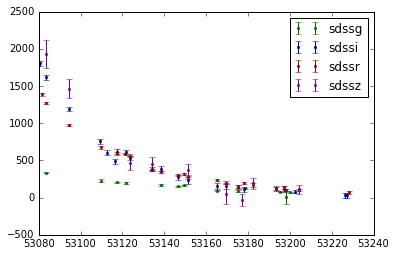

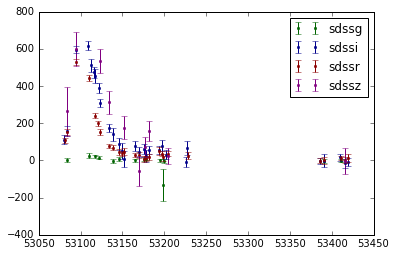

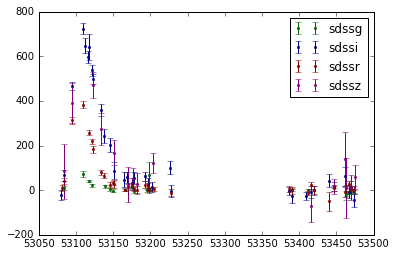

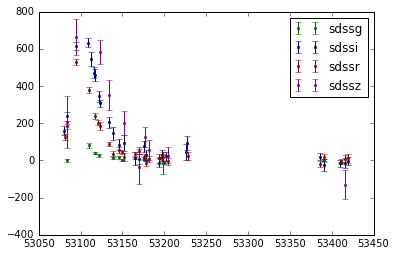

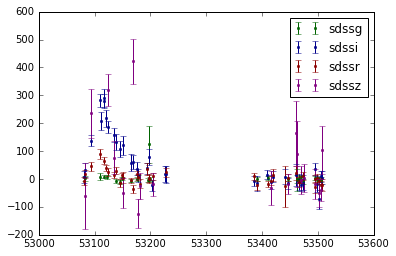

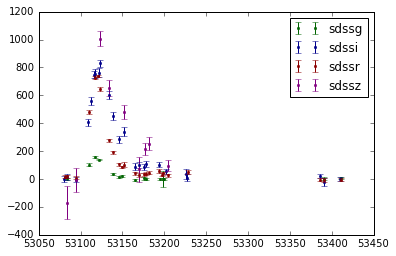

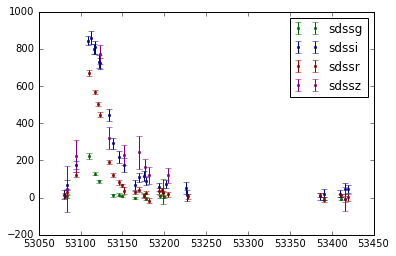

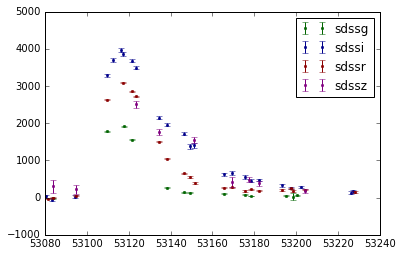

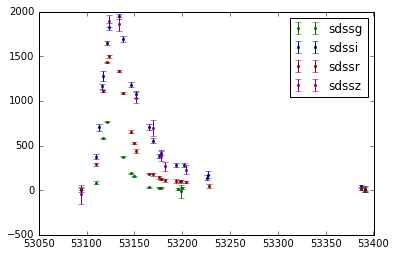

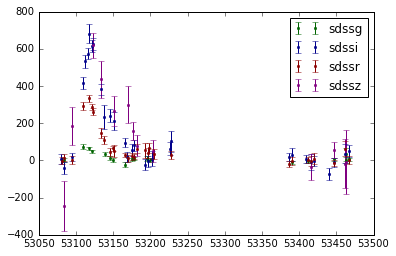

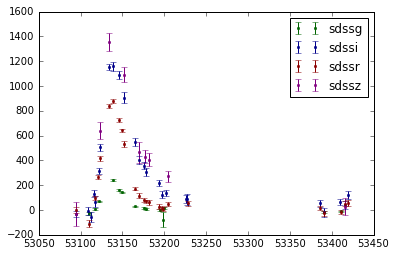

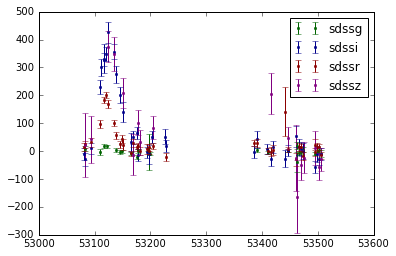

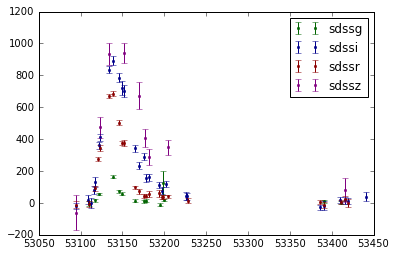

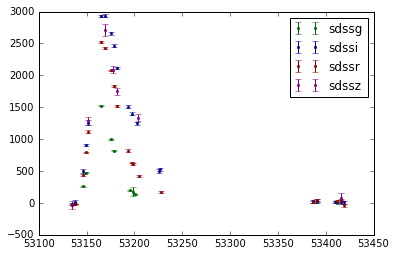

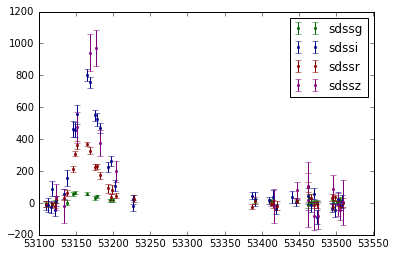

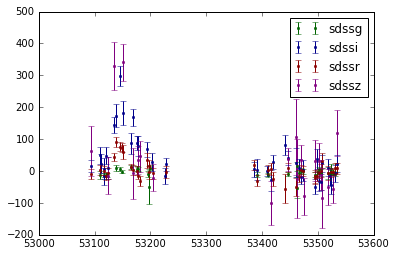

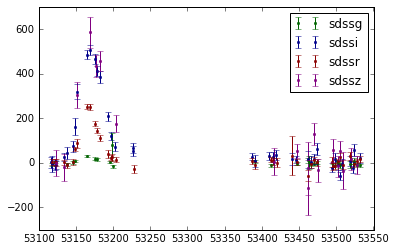

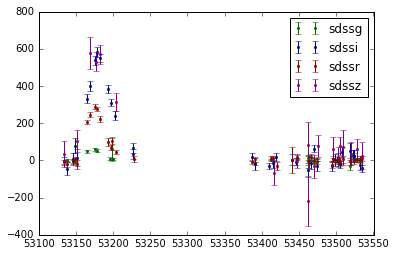

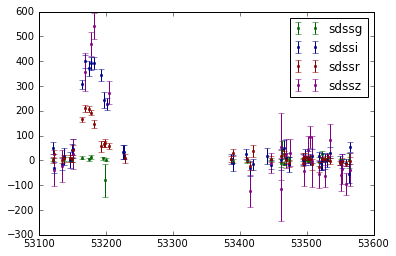

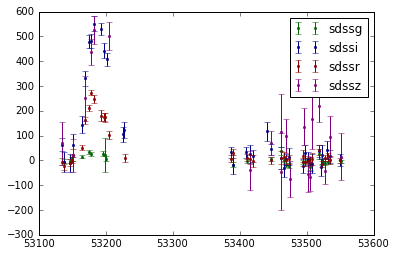

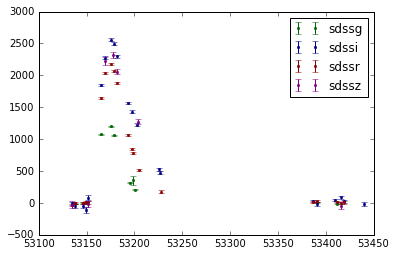

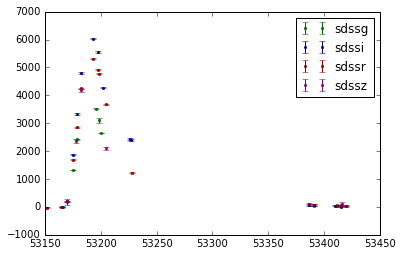

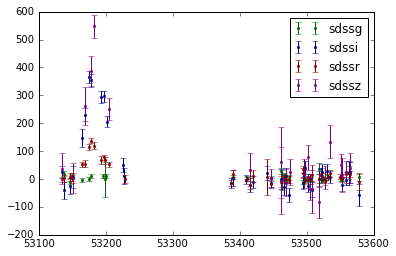

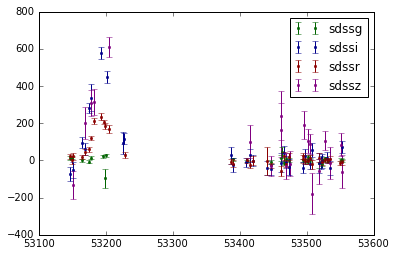

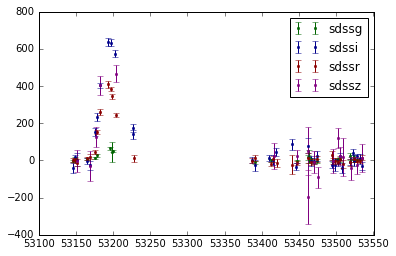

total of sn:25


In [70]:
snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

        snls_lc = DSTools.build_light_curve_from_snls_file(m, c)

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))


Matching the SNLS with Stack. Indexes are the matched curves

In [41]:
candidates_copy = copy.deepcopy(s_candidates)

In [42]:
len(s_candidates)

30360

In [43]:
f_models_cand = []
chi_sqrds_cand = []
final_c = []
errors = 0
for s in candidates_copy:
    data = sncosmo.load_example_data()
    model = sncosmo.Model(source='salt2')
    try:
        res, fitted_model = sncosmo.fit_lc(s, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.3, 0.9)})
        #sncosmo.plot_lc(s, model=fitted_model)
        plt.show()
        df = res.ndof  # number of degrees of freedom in fit
        chisq = res.chisq
        f_models_cand.append(fitted_model)
        chi_sqrds_cand.append(chisq/df)
        final_c.append(s)
    except Exception as e:
        errors+=1
        print e
        continue

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896511
    t0 = +53124.137926
    x0 = +3263458863.308523
    x1 = -104.879928
     c = -7482.204617

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896511
    t0 = +53124.137926
    x0 = +3263458863.308523
    x1 = -104.879928
     c = -7482.204617



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.881662
    t0 = +53128.814629
    x0 = -645198467.199553
    x1 = +24.702718
     c = -140.259418

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.881662
    t0 = +53128.814629
    x0 = -645198467.199553
    x1 = +24.702718
     c = -140.259418

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.504117
    t0 = +53061.650776
    x0 = -35136893193.564102
    x1 = -92.134085
     c = -934.987392

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.504117
    t0 = +53061.650776
    x0 = -35136893193.564102
    x1 = -92.134085
     c = -934.987392



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.847923
    t0 = +53055.284991
    x0 = +0.000008
    x1 = +140.290567
     c = -6874.493939

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.847923
    t0 = +53055.284991
    x0 = +0.000008
    x1 = +140.290567
     c = -6874.493939

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.746187
    t0 = +53229.290778
    x0 = -1192004910.887414
    x1 = +578.194741
     c = +5358.034694

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.746187
    t0 = +53229.290778
    x0 = -1192004910.887414
    x1 = +578.194741
     c = +5358.034694



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.625742
    t0 = +53135.034863
    x0 = -3544933422.080548
    x1 = -41.610139
     c = -829.588972

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.625742
    t0 = +53135.034863
    x0 = -3544933422.080548
    x1 = -41.610139
     c = -829.588972

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.596039
    t0 = +53234.823748
    x0 = +2985745970234.359863
    x1 = +310.105461
     c = +78162.478141

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.596039
    t0 = +53234.823748
    x0 = +2985745970234.359863
    x1 = +310.105461
     c = +78162.478141

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.821589
    t0 = +53169.659565
    x0 = -96725559.973299
    x1 = +41.831686
     c = -798.270625

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.821589
    t0 = +53169.659565
    x0 = -96725559.973299
    x1 = +41.831686
     c = -798.270625

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.602425
    t0 = +53205.795952
    x0 = +3319190343.235698
    x1 = +154.002140
     c = -2237.019722

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.573957
    t0 = +53003.787717
    x0 = -3068062053.508823
    x1 = +612.478735
     c = -1372.250683

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.602425
    t0 = +53205.795952
    x0 = +3319190343.235698
    x1 = +154.002140
     c = -2237.019722

fcn returns Nan
fcn is called with following arguments:
     z = +0.573957
    t0 = +53003.787717
    x0 = -3068062053.508823
    x1 = +612.478735
     c = -1372.250683



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.393643
    t0 = +53209.716195
    x0 = +12497017737.366966
    x1 = +476.831079
     c = -2648.806569

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.393643
    t0 = +53209.716195
    x0 = +12497017737.366966
    x1 = +476.831079
     c = -2648.806569

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.868146
    t0 = +53226.845891
    x0 = +2760887288.999991
    x1 = +391.299861
     c = -1028.746282

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.868146
    t0 = +53226.845891
    x0 = +2760887288.999991
    x1 = +391.299861
     c = -1028.746282



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899727
    t0 = +53036.701955
    x0 = -41852541034.646545
    x1 = -2270.713791
     c = +86928.355087

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899727
    t0 = +53036.701955
    x0 = -41852541034.646545
    x1 = -2270.713791
     c = +86928.355087

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.889340
    t0 = +53099.042989
    x0 = -316127156.137052
    x1 = -73.181492
     c = -1748.502393

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.889340
    t0 = +53099.042989
    x0 = -316127156.137052
    x1 = -73.181492
     c = -1748.502393

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.690793
    t0 = +53235.678643
    x0 = +19063578947.291935
    x1 = +109.271894
     c = +2079.356064

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.690793
    t0 = +53235.678643
    x0 = +19063578947.291935
    x1 = +109.271894
     c = +2079.356064

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.364336
    t0 = +53163.287972
    x0 = -11756897031.483711
    x1 = -525.305031
     c = +1316.729292

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.364336
    t0 = +53163.287972
    x0 = -11756897031.483711
    x1 = -525.305031
     c = +1316.729292

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.368250
    t0 = +53042.249004
    x0 = -66672700071.906235
    x1 = -16933.063116
     c = +41605.691810

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.368250
    t0 = +53042.249004
    x0 = -66672700071.906235
    x1 = -16933.063116
     c = +41605.691810



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.397689
    t0 = +53191.298057
    x0 = -23290609229.182312
    x1 = -1984.429176
     c = +75867.428061

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.397689
    t0 = +53191.298057
    x0 = -23290609229.182312
    x1 = -1984.429176
     c = +75867.428061

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.657189
    t0 = +53235.469329
    x0 = +991694256762.113647
    x1 = -241.758590
     c = +13821.524842

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.657189
    t0 = +53235.469329
    x0 = +991694256762.113647
    x1 = -241.758590
     c = +13821.524842

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.770918
    t0 = +53031.656263
    x0 = -338473019.689991
    x1 = +3068.767771
     c = +105980.908524

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.770918
    t0 = +53031.656263
    x0 = -338473019.689991
    x1 = +3068.767771
     c = +105980.908524

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.312641
    t0 = +53059.436041
    x0 = +13922591237.696609
    x1 = +0.262625
     c = +559.684212

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.312641
    t0 = +53059.436041
    x0 = +13922591237.696609
    x1 = +0.262625
     c = +559.684212

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893831
    t0 = +53106.275398
    x0 = -141032054.087918
    x1 = +12886.341092
     c = +175875.429331

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893831
    t0 = +53106.275398
    x0 = -141032054.087918
    x1 = +12886.341092
     c = +175875.429331

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886139
    t0 = +53038.988041
    x0 = +7152184476.534988
    x1 = +82.926799
     c = +1547.128533

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.886139
    t0 = +53038.988041
    x0 = +7152184476.534988
    x1 = +82.926799
     c = +1547.128533

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.454717
    t0 = +53010.049242
    x0 = -21667187112.608269
    x1 = +36.036086
     c = +709.363013

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.454717
    t0 = +53010.049242
    x0 = -21667187112.608269
    x1 = +36.036086
     c = +709.363013

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.458556
    t0 = +53104.822694
    x0 = +16922098165.119537
    x1 = -154.416913
     c = +3220.386458

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.458556
    t0 = +53104.822694
    x0 = +16922098165.119537
    x1 = -154.416913
     c = +3220.386458

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.664989
    t0 = +53001.232514
    x0 = -5957368426.923372
    x1 = -633.187102
     c = +8732.768099

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.664989
    t0 = +53001.232514
    x0 = -5957368426.923372
    x1 = -633.187102
     c = +8732.768099

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.822933
    t0 = +53186.509047
    x0 = +403551702.256859
    x1 = +29755.350647
     c = +57718.640838

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.822933
    t0 = +53186.509047
    x0 = +403551702.256859
    x1 = +29755.350647
     c = +57718.640838



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.868384
    t0 = +53005.785066
    x0 = -7963363984.596213
    x1 = -263.886259
     c = -3240.198014

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.868384
    t0 = +53005.785066
    x0 = -7963363984.596213
    x1 = -263.886259
     c = -3240.198014

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.739731
    t0 = +53093.816471
    x0 = +227850028.935630
    x1 = +1375.589106
     c = +9349.347828

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.739731
    t0 = +53093.816471
    x0 = +227850028.935630
    x1 = +1375.589106
     c = +9349.347828

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.765037
    t0 = +53046.368559
    x0 = +893913581.252652
    x1 = +8549.296937
     c = +81088.892164

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.765037
    t0 = +53046.368559
    x0 = +893913581.252652
    x1 = +8549.296937
     c = +81088.892164

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.341160
    t0 = +53065.637095
    x0 = +698749816.278065
    x1 = +7160.850938
     c = +3000.284947

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.341160
    t0 = +53065.637095
    x0 = +698749816.278065
    x1 = +7160.850938
     c = +3000.284947



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.448657
    t0 = +53053.795310
    x0 = +804371993236.888184
    x1 = +331.269262
     c = +889.576787

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.448657
    t0 = +53053.795310
    x0 = +804371993236.888184
    x1 = +331.269262
     c = +889.576787



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.805517
    t0 = +53218.738684
    x0 = -3525431059.548969
    x1 = -301838.635712
     c = +88175.903533

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.805517
    t0 = +53218.738684
    x0 = -3525431059.548969
    x1 = -301838.635712
     c = +88175.903533



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.838270
    t0 = +53197.114999
    x0 = +15212409367.403740
    x1 = -49.153577
     c = +741.213092

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.838270
    t0 = +53197.114999
    x0 = +15212409367.403740
    x1 = -49.153577
     c = +741.213092

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.407848
    t0 = +53055.359578
    x0 = +8349447334.044365
    x1 = +32.759071
     c = +468.859285

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.407848
    t0 = +53055.359578
    x0 = +8349447334.044365
    x1 = +32.759071
     c = +468.859285



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.360908
    t0 = +53191.386341
    x0 = +17380882967.740673
    x1 = -22.025630
     c = +587.687100

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.360908
    t0 = +53191.386341
    x0 = +17380882967.740673
    x1 = -22.025630
     c = +587.687100

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892188
    t0 = +53191.700170
    x0 = +0.000051
    x1 = +37.856098
     c = -151.981747

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.588608
    t0 = +53111.245453
    x0 = -0.145177
    x1 = -25.394123
     c = +1777.041780

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892188
    t0 = +53191.700170
    x0 = +0.000051
    x1 = +37.856098
     c = -151.981747

fcn returns Nan
fcn is called with following arguments:
     z = +0.588608
    t0 = +53111.245453
    x0 = -0.145177
    x1 = -25.394123
     c = +1777.041780

float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.429113
    t0 = +53227.895725
    x0 = -36617826950.937706
    x1 = -76.931245
     c = +2227.310015



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.429113
    t0 = +53227.895725
    x0 = -36617826950.937706
    x1 = -76.931245
     c = +2227.310015

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.664575
    t0 = +53091.397876
    x0 = -42355757356.476051
    x1 = -85.831305
     c = +2576.679536

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.664575
    t0 = +53091.397876
    x0 = -42355757356.476051
    x1 = -85.831305
     c = +2576.679536



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.879519
    t0 = +53227.858846
    x0 = +1086413.848050
    x1 = +42661.742437
     c = +14652.393385

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.879519
    t0 = +53227.858846
    x0 = +1086413.848050
    x1 = +42661.742437
     c = +14652.393385

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.869184
    t0 = +53070.557222
    x0 = +3902365399.878016
    x1 = +423.598786
     c = +2098.212743

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.869184
    t0 = +53070.557222
    x0 = +3902365399.878016
    x1 = +423.598786
     c = +2098.212743



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.640942
    t0 = +53179.305345
    x0 = -1529562.029575
    x1 = +313931.583505
     c = -26257.852820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.640942
    t0 = +53179.305345
    x0 = -1529562.029575
    x1 = +313931.583505
     c = -26257.852820

float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.355493
    t0 = +53008.571736
    x0 = -0.000003
    x1 = -206.329431
     c = +4528.550902



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.355493
    t0 = +53008.571736
    x0 = -0.000003
    x1 = -206.329431
     c = +4528.550902

  d, l = m.migrad(ncall=maxcall)


No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897838
    t0 = +53228.885983
    x0 = -5855143027.086543
    x1 = -13.153696
     c = -1526.589912

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897838
    t0 = +53228.885983
    x0 = -5855143027.086543
    x1 = -13.153696
     c = -1526.589912

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.363714
    t0 = +53185.027190
    x0 = +35784995636.813675
    x1 = +7320.334399
     c = +488742.019710

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.363714
    t0 = +53185.027190
    x0 = +35784995636.813675
    x1 = +7320.334399
     c = +488742.019710

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.679643
    t0 = +53159.617566
    x0 = -87993025.746926
    x1 = +32.930140
     c = -825.297044

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.679643
    t0 = +53159.617566
    x0 = -87993025.746926
    x1 = +32.930140
     c = -825.297044

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896341
    t0 = +53232.936396
    x0 = +1801882656.050679
    x1 = +2445.663707
     c = -11119.533813

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896341
    t0 = +53232.936396
    x0 = +1801882656.050679
    x1 = +2445.663707
     c = -11119.533813

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.828063
    t0 = +53235.668892
    x0 = +10842679757.583433
    x1 = +127.396058
     c = -1292.878124

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.828063
    t0 = +53235.668892
    x0 = +10842679757.583433
    x1 = +127.396058
     c = -1292.878124



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.851175
    t0 = +53052.962025
    x0 = -16522412723.517204
    x1 = -81.191540
     c = -402.051754

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.851175
    t0 = +53052.962025
    x0 = -16522412723.517204
    x1 = -81.191540
     c = -402.051754

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.340208
    t0 = +53071.100912
    x0 = +43619876223.218269
    x1 = +29884.845710
     c = -646789.349077

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.340208
    t0 = +53071.100912
    x0 = +43619876223.218269
    x1 = +29884.845710
     c = -646789.349077

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.862496
    t0 = +53003.107736
    x0 = +23837730473.369896
    x1 = -3376.081026
     c = +524709.704004

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.862496
    t0 = +53003.107736
    x0 = +23837730473.369896
    x1 = -3376.081026
     c = +524709.704004

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897133
    t0 = +53067.663222
    x0 = +2241625885869.280273
    x1 = +343.119592
     c = +6292.681877

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897133
    t0 = +53067.663222
    x0 = +2241625885869.280273
    x1 = +343.119592
     c = +6292.681877



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.457997
    t0 = +53054.608199
    x0 = +34295756.156013
    x1 = +4211.978138
     c = -42461.106884

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.457997
    t0 = +53054.608199
    x0 = +34295756.156013
    x1 = +4211.978138
     c = -42461.106884

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.590855
    t0 = +53219.327214
    x0 = +287303492049.820374
    x1 = +50889.087537
     c = +3456620.446539

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.590855
    t0 = +53219.327214
    x0 = +287303492049.820374
    x1 = +50889.087537
     c = +3456620.446539

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.489379
    t0 = +53090.735640
    x0 = -124928701808.230728
    x1 = -574.134869
     c = -835.561517

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.489379
    t0 = +53090.735640
    x0 = -124928701808.230728
    x1 = -574.134869
     c = -835.561517

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301106
    t0 = +53149.240235
    x0 = +50161018061.428848
    x1 = -37.189927
     c = +1849.340311

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301106
    t0 = +53149.240235
    x0 = +50161018061.428848
    x1 = -37.189927
     c = +1849.340311

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899680
    t0 = +53229.552997
    x0 = +35.927867
    x1 = +579555.449074
     c = +6068.113239

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899680
    t0 = +53229.552997
    x0 = +35.927867
    x1 = +579555.449074
     c = +6068.113239

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.455140
    t0 = +53011.515169
    x0 = -166435402247.083405
    x1 = -8.540896
     c = -1586.042685

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.455140
    t0 = +53011.515169
    x0 = -166435402247.083405
    x1 = -8.540896
     c = -1586.042685

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.630937
    t0 = +53068.155712
    x0 = +2082413.187638
    x1 = +62.115375
     c = -1133.597127

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.412197
    t0 = +53016.577409
    x0 = +81687758522.408310
    x1 = +266.433762
     c = -2809.081799

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.630937
    t0 = +53068.155712
    x0 = +2082413.187638
    x1 = +62.115375
     c = -1133.597127

fcn returns Nan
fcn is called with following arguments:
     z = +0.412197
    t0 = +53016.577409
    x0 = +81687758522.408310
    x1 = +266.433762
     c = -2809.081799

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.659080
    t0 = +53132.098497
    x0 = +144746398117.250793
    x1 = -9.109652
     c = +7467.536177



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.659080
    t0 = +53132.098497
    x0 = +144746398117.250793
    x1 = -9.109652
     c = +7467.536177

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.758812
    t0 = +53121.620801
    x0 = +6389799727.053396
    x1 = +18569.362851
     c = -189319.653340

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.758812
    t0 = +53121.620801
    x0 = +6389799727.053396
    x1 = +18569.362851
     c = -189319.653340

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.372858
    t0 = +53091.074408
    x0 = +0.000000
    x1 = +10.235161
     c = +1038.256306

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.372858
    t0 = +53091.074408
    x0 = +0.000000
    x1 = +10.235161
     c = +1038.256306



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.855746
    t0 = +53025.271979
    x0 = +34504905103.457619
    x1 = +1165.109699
     c = +20809.488397

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.855746
    t0 = +53025.271979
    x0 = +34504905103.457619
    x1 = +1165.109699
     c = +20809.488397

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.702516
    t0 = +53099.627765
    x0 = -668298862.162913
    x1 = -627.987436
     c = -1947.016681

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.702516
    t0 = +53099.627765
    x0 = -668298862.162913
    x1 = -627.987436
     c = -1947.016681

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.625409
    t0 = +53234.539792
    x0 = +23868162307.333595
    x1 = +29.060121
     c = +958.229147

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.625409
    t0 = +53234.539792
    x0 = +23868162307.333595
    x1 = +29.060121
     c = +958.229147



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.427363
    t0 = +53032.680813
    x0 = +97774704502.569351
    x1 = +1507.639268
     c = -40592.909597

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.427363
    t0 = +53032.680813
    x0 = +97774704502.569351
    x1 = +1507.639268
     c = -40592.909597



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300968
    t0 = +53226.033830
    x0 = +6720372471510.840820
    x1 = +6134.255998
     c = +2498068.126326

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300968
    t0 = +53226.033830
    x0 = +6720372471510.840820
    x1 = +6134.255998
     c = +2498068.126326



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.499674
    t0 = +53180.360180
    x0 = +173229372.475603
    x1 = -17735.093050
     c = -11203.363539

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.499674
    t0 = +53180.360180
    x0 = +173229372.475603
    x1 = -17735.093050
     c = -11203.363539



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.857942
    t0 = +53187.689175
    x0 = -19751358.250317
    x1 = -8.097598
     c = +628.058300

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.857942
    t0 = +53187.689175
    x0 = -19751358.250317
    x1 = -8.097598
     c = +628.058300

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892540
    t0 = +53208.501180
    x0 = +11754791558.587894
    x1 = +123.729433
     c = -253.091754

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892540
    t0 = +53208.501180
    x0 = +11754791558.587894
    x1 = +123.729433
     c = -253.091754

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.830495
    t0 = +53021.811411
    x0 = +0.000007
    x1 = +29.283032
     c = +2358.271926

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.830495
    t0 = +53021.811411
    x0 = +0.000007
    x1 = +29.283032
     c = +2358.271926

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895123
    t0 = +53131.179911
    x0 = +25308531841.035126
    x1 = +100.379976
     c = +931.137544

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895123
    t0 = +53131.179911
    x0 = +25308531841.035126
    x1 = +100.379976
     c = +931.137544



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.485788
    t0 = +53009.086230
    x0 = +46761329854.455772
    x1 = +44.830428
     c = +1709.594782

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.485788
    t0 = +53009.086230
    x0 = +46761329854.455772
    x1 = +44.830428
     c = +1709.594782



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899887
    t0 = +53220.550883
    x0 = +858569968.018468
    x1 = +38211.919858
     c = +137301.280491

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899887
    t0 = +53220.550883
    x0 = +858569968.018468
    x1 = +38211.919858
     c = +137301.280491

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.409140
    t0 = +53124.329883
    x0 = +12119628231.244820
    x1 = +189.009086
     c = +1252.183301

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.409140
    t0 = +53124.329883
    x0 = +12119628231.244820
    x1 = +189.009086
     c = +1252.183301

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.626899
    t0 = +53047.143769
    x0 = +75316680014329.828125
    x1 = +117.161062
     c = +16562.056478

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.626899
    t0 = +53047.143769
    x0 = +75316680014329.828125
    x1 = +117.161062
     c = +16562.056478

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.796946
    t0 = +53230.399609
    x0 = -6381737942.585118
    x1 = +12.999058
     c = -324.064023

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.796946
    t0 = +53230.399609
    x0 = -6381737942.585118
    x1 = +12.999058
     c = -324.064023



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898145
    t0 = +53001.122525
    x0 = +22555954949.679054
    x1 = +92.407789
     c = -159.798141

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898145
    t0 = +53001.122525
    x0 = +22555954949.679054
    x1 = +92.407789
     c = -159.798141

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.881973
    t0 = +53197.758785
    x0 = +1526518225.751882
    x1 = -32.825064
     c = +814.027506

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.881973
    t0 = +53197.758785
    x0 = +1526518225.751882
    x1 = -32.825064
     c = +814.027506

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887419
    t0 = +53121.193492
    x0 = +590699244.398339
    x1 = +1148.971927
     c = +13026.473790

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887419
    t0 = +53121.193492
    x0 = +590699244.398339
    x1 = +1148.971927
     c = +13026.473790



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.362681
    t0 = +53085.678008
    x0 = +3961953332.540211
    x1 = +129141.554451
     c = -286394.664424

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.362681
    t0 = +53085.678008
    x0 = +3961953332.540211
    x1 = +129141.554451
     c = -286394.664424

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.817393
    t0 = +53233.479725
    x0 = +168134830564.478760
    x1 = +1704.514022
     c = +229734.890222

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.817393
    t0 = +53233.479725
    x0 = +168134830564.478760
    x1 = +1704.514022
     c = +229734.890222



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899969
    t0 = +53027.751447
    x0 = +1018729879.038088
    x1 = +18.132481
     c = -238.784171

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899969
    t0 = +53027.751447
    x0 = +1018729879.038088
    x1 = +18.132481
     c = -238.784171



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.713470
    t0 = +53041.632131
    x0 = +22866233600.292686
    x1 = +66301.267819
     c = +324131.718383

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.713470
    t0 = +53041.632131
    x0 = +22866233600.292686
    x1 = +66301.267819
     c = +324131.718383



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.516825
    t0 = +53121.592798
    x0 = +4647368035.327209
    x1 = +543.506622
     c = +3581.379826

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.516825
    t0 = +53121.592798
    x0 = +4647368035.327209
    x1 = +543.506622
     c = +3581.379826



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.306270
    t0 = +53058.678092
    x0 = -8581487129.001019
    x1 = -216.343883
     c = +5453.315681

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.306270
    t0 = +53058.678092
    x0 = -8581487129.001019
    x1 = -216.343883
     c = +5453.315681

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.404387
    t0 = +53037.620037
    x0 = +11495.528723
    x1 = +338.338569
     c = +484.967547

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.404387
    t0 = +53037.620037
    x0 = +11495.528723
    x1 = +338.338569
     c = +484.967547



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.858276
    t0 = +53000.950598
    x0 = -3509726604.075568
    x1 = -2.074412
     c = -149.025028

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.858276
    t0 = +53000.950598
    x0 = -3509726604.075568
    x1 = -2.074412
     c = -149.025028



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.827714
    t0 = +53233.110487
    x0 = -6160099250.429063
    x1 = -153.842969
     c = +5806.444826

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.827714
    t0 = +53233.110487
    x0 = -6160099250.429063
    x1 = -153.842969
     c = +5806.444826



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.325898
    t0 = +53107.761930
    x0 = +4465090955800.622070
    x1 = +48.014760
     c = +1604.229962

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.325898
    t0 = +53107.761930
    x0 = +4465090955800.622070
    x1 = +48.014760
     c = +1604.229962



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.566490
    t0 = +53090.879413
    x0 = +260502164.085258
    x1 = -23.090360
     c = -2469.717274

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.566490
    t0 = +53090.879413
    x0 = +260502164.085258
    x1 = -23.090360
     c = -2469.717274

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874855
    t0 = +53072.964219
    x0 = +5712397286.183031
    x1 = +117.241486
     c = +1241.837903

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874855
    t0 = +53072.964219
    x0 = +5712397286.183031
    x1 = +117.241486
     c = +1241.837903

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.330919
    t0 = +53057.536479
    x0 = +2442064480.819631
    x1 = +125568.271976
     c = -110801.091666

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.330919
    t0 = +53057.536479
    x0 = +2442064480.819631
    x1 = +125568.271976
     c = -110801.091666



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.823732
    t0 = +53133.242392
    x0 = +0.000002
    x1 = +2699.344277
     c = +658.877471

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.823732
    t0 = +53133.242392
    x0 = +0.000002
    x1 = +2699.344277
     c = +658.877471

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.742603
    t0 = +53140.024178
    x0 = -52060119835.624771
    x1 = -1594.818974
     c = -77371.729556

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.742603
    t0 = +53140.024178
    x0 = -52060119835.624771
    x1 = -1594.818974
     c = -77371.729556



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.588632
    t0 = +53200.404475
    x0 = +6393580222.589274
    x1 = +14277.621780
     c = -190192.616297

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.588632
    t0 = +53200.404475
    x0 = +6393580222.589274
    x1 = +14277.621780
     c = -190192.616297



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.609208
    t0 = +53190.192211
    x0 = +44007362.633699
    x1 = +1004.467956
     c = +2130.876372

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.609208
    t0 = +53190.192211
    x0 = +44007362.633699
    x1 = +1004.467956
     c = +2130.876372

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.562585
    t0 = +53006.538343
    x0 = +3911094272.564544
    x1 = +806.126543
     c = -1599.351219

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.562585
    t0 = +53006.538343
    x0 = +3911094272.564544
    x1 = +806.126543
     c = -1599.351219



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.851911
    t0 = +53000.007774
    x0 = +247683658.735060
    x1 = -707.525273
     c = +5658.950320

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.851911
    t0 = +53000.007774
    x0 = +247683658.735060
    x1 = -707.525273
     c = +5658.950320

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.601089
    t0 = +53017.857064
    x0 = -15360778567.159410
    x1 = -157.105979
     c = -26002.266737

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.601089
    t0 = +53017.857064
    x0 = -15360778567.159410
    x1 = -157.105979
     c = -26002.266737



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899911
    t0 = +53208.401326
    x0 = -1452.504754
    x1 = +2127.932425
     c = +17064.494223

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899911
    t0 = +53208.401326
    x0 = -1452.504754
    x1 = +2127.932425
     c = +17064.494223



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.615016
    t0 = +53208.820771
    x0 = +13740438697.635380
    x1 = +1876.802227
     c = -45510.825641

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.615016
    t0 = +53208.820771
    x0 = +13740438697.635380
    x1 = +1876.802227
     c = -45510.825641

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895378
    t0 = +53215.848992
    x0 = -216514933.840069
    x1 = -5.202241
     c = +660.885027

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895378
    t0 = +53215.848992
    x0 = -216514933.840069
    x1 = -5.202241
     c = +660.885027



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.872429
    t0 = +53224.531499
    x0 = +26702824201.471848
    x1 = +449.542599
     c = +4609.738955

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.872429
    t0 = +53224.531499
    x0 = +26702824201.471848
    x1 = +449.542599
     c = +4609.738955

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.329088
    t0 = +53235.974894
    x0 = +19344918.797389
    x1 = +4896.587051
     c = +624.111359

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.329088
    t0 = +53235.974894
    x0 = +19344918.797389
    x1 = +4896.587051
     c = +624.111359



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896607
    t0 = +53190.613869
    x0 = -7200355375.833938
    x1 = -144.517565
     c = +562.000314

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896607
    t0 = +53190.613869
    x0 = -7200355375.833938
    x1 = -144.517565
     c = +562.000314

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.594548
    t0 = +53204.435948
    x0 = +4219642465.030706
    x1 = +891.200469
     c = +2924.087455

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.594548
    t0 = +53204.435948
    x0 = +4219642465.030706
    x1 = +891.200469
     c = +2924.087455



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.569891
    t0 = +53190.820119
    x0 = +22644.152553
    x1 = +204.098321
     c = -6042.351014

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.569891
    t0 = +53190.820119
    x0 = +22644.152553
    x1 = +204.098321
     c = -6042.351014



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.394661
    t0 = +53161.034430
    x0 = -1036859.103106
    x1 = -94590.001926
     c = +2565.560479

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.394661
    t0 = +53161.034430
    x0 = -1036859.103106
    x1 = -94590.001926
     c = +2565.560479

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899040
    t0 = +53002.005077
    x0 = -32136656698.351196
    x1 = -493.705865
     c = -1423.978618

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899040
    t0 = +53002.005077
    x0 = -32136656698.351196
    x1 = -493.705865
     c = -1423.978618

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.458304
    t0 = +53235.504517
    x0 = +1930795084.827054
    x1 = +48.307374
     c = +408.209349

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.458304
    t0 = +53235.504517
    x0 = +1930795084.827054
    x1 = +48.307374
     c = +408.209349



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886492
    t0 = +53078.713982
    x0 = -2863749527.492001
    x1 = -173.469546
     c = +2084.477805

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.886492
    t0 = +53078.713982
    x0 = -2863749527.492001
    x1 = -173.469546
     c = +2084.477805



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873239
    t0 = +53226.057088
    x0 = +32556170777.648720
    x1 = +17020.566407
     c = -63621.246062

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873239
    t0 = +53226.057088
    x0 = +32556170777.648720
    x1 = +17020.566407
     c = -63621.246062



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.877633
    t0 = +53175.999582
    x0 = +7429504311.524097
    x1 = +200.366308
     c = +849.933335

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.877633
    t0 = +53175.999582
    x0 = +7429504311.524097
    x1 = +200.366308
     c = +849.933335

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.431977
    t0 = +53065.872721
    x0 = +4137677350.427089
    x1 = +76.596050
     c = +976.369666

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.431977
    t0 = +53065.872721
    x0 = +4137677350.427089
    x1 = +76.596050
     c = +976.369666

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302573
    t0 = +53202.443957
    x0 = -77.766108
    x1 = -6952.710846
     c = +1045.038311

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302573
    t0 = +53202.443957
    x0 = -77.766108
    x1 = -6952.710846
     c = +1045.038311

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.600352
    t0 = +53113.726768
    x0 = +0.000011
    x1 = +8698.710246
     c = -2177.801924

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.600352
    t0 = +53113.726768
    x0 = +0.000011
    x1 = +8698.710246
     c = -2177.801924

float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.812562
    t0 = +53216.310076
    x0 = +73781065.585069
    x1 = -11528.479978
     c = +19489.968620

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.812562
    t0 = +53216.310076
    x0 = +73781065.585069
    x1 = -11528.479978
     c = +19489.968620



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.746353
    t0 = +53161.260689
    x0 = +10213544024.810293
    x1 = +30.754677
     c = +637.340630

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.746353
    t0 = +53161.260689
    x0 = +10213544024.810293
    x1 = +30.754677
     c = +637.340630

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.679254
    t0 = +53184.636048
    x0 = -8430179262.316724
    x1 = +57.650687
     c = -2608.813930

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.679254
    t0 = +53184.636048
    x0 = -8430179262.316724
    x1 = +57.650687
     c = -2608.813930

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.721906
    t0 = +53052.956675
    x0 = +102197859364.956055
    x1 = +73.344230
     c = -713.282242

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.721906
    t0 = +53052.956675
    x0 = +102197859364.956055
    x1 = +73.344230
     c = -713.282242

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.448408
    t0 = +53047.263958
    x0 = -5108810821.198848
    x1 = -19.664263
     c = +697.515708

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.448408
    t0 = +53047.263958
    x0 = -5108810821.198848
    x1 = -19.664263
     c = +697.515708



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.755593
    t0 = +53141.776786
    x0 = +54839242996.119896
    x1 = +16028.042130
     c = +262638.002407

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.755593
    t0 = +53141.776786
    x0 = +54839242996.119896
    x1 = +16028.042130
     c = +262638.002407

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.449258
    t0 = +53071.598828
    x0 = +5320461567.037013
    x1 = +540.121802
     c = -1117.764452

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.449258
    t0 = +53071.598828
    x0 = +5320461567.037013
    x1 = +540.121802
     c = -1117.764452

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896535
    t0 = +53091.656596
    x0 = -109762914712.744781
    x1 = +18.834089
     c = -4483.452229

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896535
    t0 = +53091.656596
    x0 = -109762914712.744781
    x1 = +18.834089
     c = -4483.452229

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.729225
    t0 = +53010.867122
    x0 = -9686587042.475620
    x1 = -51.638890
     c = -1728.167784

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.729225
    t0 = +53010.867122
    x0 = -9686587042.475620
    x1 = -51.638890
     c = -1728.167784

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.698373
    t0 = +53198.810424
    x0 = +23423807715.570316
    x1 = +3615.424298
     c = +16184.625485

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.698373
    t0 = +53198.810424
    x0 = +23423807715.570316
    x1 = +3615.424298
     c = +16184.625485



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.865190
    t0 = +53119.739296
    x0 = -38485146153.082230
    x1 = +2794.848088
     c = -90850.348643

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.865190
    t0 = +53119.739296
    x0 = -38485146153.082230
    x1 = +2794.848088
     c = -90850.348643

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.864729
    t0 = +53157.247209
    x0 = -2999796472.873729
    x1 = -52.471330
     c = -744.159022

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.864729
    t0 = +53157.247209
    x0 = -2999796472.873729
    x1 = -52.471330
     c = -744.159022

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.864399
    t0 = +53140.630822
    x0 = +3176052361.146638
    x1 = +33.661289
     c = -400.614173

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.864399
    t0 = +53140.630822
    x0 = +3176052361.146638
    x1 = +33.661289
     c = -400.614173

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.523138
    t0 = +53029.158912
    x0 = +3661482669.516917
    x1 = +17.972745
     c = -5611.095937

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.523138
    t0 = +53029.158912
    x0 = +3661482669.516917
    x1 = +17.972745
     c = -5611.095937

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.691145
    t0 = +53235.685216
    x0 = -251846958.761051
    x1 = -260046.410657
     c = +297593.916569

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.691145
    t0 = +53235.685216
    x0 = -251846958.761051
    x1 = -260046.410657
     c = +297593.916569



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.311523
    t0 = +53001.310217
    x0 = -1852923763.272758
    x1 = -2509.664614
     c = -4528.362375

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.311523
    t0 = +53001.310217
    x0 = -1852923763.272758
    x1 = -2509.664614
     c = -4528.362375

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.610359
    t0 = +53016.358769
    x0 = -3852167056.617087
    x1 = -61.896949
     c = -685.486760

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.610359
    t0 = +53016.358769
    x0 = -3852167056.617087
    x1 = -61.896949
     c = -685.486760



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892149
    t0 = +53215.053123
    x0 = +3439484820.923494
    x1 = +21.087832
     c = -946.967987

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892149
    t0 = +53215.053123
    x0 = +3439484820.923494
    x1 = +21.087832
     c = -946.967987



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.696130
    t0 = +53000.700865
    x0 = -46664400689.499458
    x1 = -7260.565713
     c = -253999.346741

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.696130
    t0 = +53000.700865
    x0 = -46664400689.499458
    x1 = -7260.565713
     c = -253999.346741



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896114
    t0 = +53204.235634
    x0 = -16902221752.513294
    x1 = +1993.848788
     c = -31135.732156

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896114
    t0 = +53204.235634
    x0 = -16902221752.513294
    x1 = +1993.848788
     c = -31135.732156



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.682449
    t0 = +53039.209453
    x0 = +944112220.441563
    x1 = +46.524350
     c = -269.822438

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.682449
    t0 = +53039.209453
    x0 = +944112220.441563
    x1 = +46.524350
     c = -269.822438



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.435122
    t0 = +53003.160760
    x0 = +1443288217.566669
    x1 = +81.092720
     c = +4003.823585

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.435122
    t0 = +53003.160760
    x0 = +1443288217.566669
    x1 = +81.092720
     c = +4003.823585

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.555955
    t0 = +53101.547373
    x0 = -1610551431.434247
    x1 = +138.912861
     c = -6628.135803

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.555955
    t0 = +53101.547373
    x0 = -1610551431.434247
    x1 = +138.912861
     c = -6628.135803



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886119
    t0 = +53014.264221
    x0 = -440113997.298595
    x1 = -72.875559
     c = +545.392895

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.886119
    t0 = +53014.264221
    x0 = -440113997.298595
    x1 = -72.875559
     c = +545.392895



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.663866
    t0 = +53107.904448
    x0 = -3746197469.786059
    x1 = -121.715395
     c = -828.093619

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.663866
    t0 = +53107.904448
    x0 = -3746197469.786059
    x1 = -121.715395
     c = -828.093619



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.677027
    t0 = +53007.040693
    x0 = +0.000004
    x1 = +139.713691
     c = -8630.898526

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.677027
    t0 = +53007.040693
    x0 = +0.000004
    x1 = +139.713691
     c = -8630.898526



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.317590
    t0 = +53008.081798
    x0 = -815457958.773950
    x1 = +550.203162
     c = +1095.524899

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.317590
    t0 = +53008.081798
    x0 = -815457958.773950
    x1 = +550.203162
     c = +1095.524899



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874106
    t0 = +53231.809119
    x0 = -385930071405.558167
    x1 = -37.224859
     c = -376.472297

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874106
    t0 = +53231.809119
    x0 = -385930071405.558167
    x1 = -37.224859
     c = -376.472297



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.576386
    t0 = +53210.094037
    x0 = -50483394243.833496
    x1 = -25341.933894
     c = +771389.159759

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.576386
    t0 = +53210.094037
    x0 = -50483394243.833496
    x1 = -25341.933894
     c = +771389.159759



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.315809
    t0 = +53198.872867
    x0 = +22691485601.621143
    x1 = +3820.361028
     c = +27125.007462

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.315809
    t0 = +53198.872867
    x0 = +22691485601.621143
    x1 = +3820.361028
     c = +27125.007462



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.314351
    t0 = +53232.057075
    x0 = +7722689586.375949
    x1 = +63.127051
     c = +1071.894080

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.314351
    t0 = +53232.057075
    x0 = +7722689586.375949
    x1 = +63.127051
     c = +1071.894080

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.690067
    t0 = +53041.031624
    x0 = -2286850807.214463
    x1 = +6.308987
     c = -260.340384

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.690067
    t0 = +53041.031624
    x0 = -2286850807.214463
    x1 = +6.308987
     c = -260.340384

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.861095
    t0 = +53050.995632
    x0 = +2456870486.268022
    x1 = +29.218093
     c = +2765.113423

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.861095
    t0 = +53050.995632
    x0 = +2456870486.268022
    x1 = +29.218093
     c = +2765.113423



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.737123
    t0 = +53002.897329
    x0 = +27781172005.257263
    x1 = +11474.726016
     c = -354606.377240

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.737123
    t0 = +53002.897329
    x0 = +27781172005.257263
    x1 = +11474.726016
     c = -354606.377240



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.587200
    t0 = +53231.255522
    x0 = +935322199.881058
    x1 = +17899.601909
     c = +603866.687906

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.587200
    t0 = +53231.255522
    x0 = +935322199.881058
    x1 = +17899.601909
     c = +603866.687906

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.852021
    t0 = +53024.917424
    x0 = +1340104041.687462
    x1 = +351.295259
     c = +1898.716429

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.852021
    t0 = +53024.917424
    x0 = +1340104041.687462
    x1 = +351.295259
     c = +1898.716429

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.356526
    t0 = +53000.984316
    x0 = +47656643714.741020
    x1 = +82938.009781
     c = -128998.688849



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.356526
    t0 = +53000.984316
    x0 = +47656643714.741020
    x1 = +82938.009781
     c = -128998.688849

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.500288
    t0 = +53022.203546
    x0 = +1993457827770.980225
    x1 = +334.179728
     c = -12576.476081

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.500288
    t0 = +53022.203546
    x0 = +1993457827770.980225
    x1 = +334.179728
     c = -12576.476081



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.457294
    t0 = +53163.196233
    x0 = +412407834.596137
    x1 = +372.755129
     c = +681.037274

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.457294
    t0 = +53163.196233
    x0 = +412407834.596137
    x1 = +372.755129
     c = +681.037274



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.416955
    t0 = +53075.463536
    x0 = -189338556224637.937500
    x1 = +83.209188
     c = +641.770219

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.416955
    t0 = +53075.463536
    x0 = -189338556224637.937500
    x1 = +83.209188
     c = +641.770219

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.451786
    t0 = +53112.314894
    x0 = +101748208.021773
    x1 = +150.191265
     c = +1989.388145

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.451786
    t0 = +53112.314894
    x0 = +101748208.021773
    x1 = +150.191265
     c = +1989.388145

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.838506
    t0 = +53011.654017
    x0 = +5500256199.999744
    x1 = +20.213015
     c = -166.234184

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.838506
    t0 = +53011.654017
    x0 = +5500256199.999744
    x1 = +20.213015
     c = -166.234184

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.556181
    t0 = +53051.434715
    x0 = +735332785.389337
    x1 = +29450.038750
     c = +88164.322125

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.556181
    t0 = +53051.434715
    x0 = +735332785.389337
    x1 = +29450.038750
     c = +88164.322125



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.500049
    t0 = +53207.325853
    x0 = -317764022494.840088
    x1 = -19.532774
     c = -5456.019504

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.500049
    t0 = +53207.325853
    x0 = -317764022494.840088
    x1 = -19.532774
     c = -5456.019504

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899733
    t0 = +53189.867899
    x0 = +99911002312.677322
    x1 = +6572.329080
     c = +123563.134034

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899733
    t0 = +53189.867899
    x0 = +99911002312.677322
    x1 = +6572.329080
     c = +123563.134034

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.634100
    t0 = +53189.561026
    x0 = +0.000157
    x1 = +5.234202
     c = +1120.177222

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.634100
    t0 = +53189.561026
    x0 = +0.000157
    x1 = +5.234202
     c = +1120.177222



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.491122
    t0 = +53003.000119
    x0 = -346843196.963229
    x1 = -26961.793797
     c = +63937.996005

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.491122
    t0 = +53003.000119
    x0 = -346843196.963229
    x1 = -26961.793797
     c = +63937.996005



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.872608
    t0 = +53015.810463
    x0 = -16449669.741624
    x1 = -28.057361
     c = -237.464575

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.872608
    t0 = +53015.810463
    x0 = -16449669.741624
    x1 = -28.057361
     c = -237.464575

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.423016
    t0 = +53056.163756
    x0 = +2488101745.162144
    x1 = +44.397837
     c = +500.245633

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.423016
    t0 = +53056.163756
    x0 = +2488101745.162144
    x1 = +44.397837
     c = +500.245633

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898679
    t0 = +53079.376410
    x0 = -18799861410.562450
    x1 = -108.871518
     c = +988.425172

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898679
    t0 = +53079.376410
    x0 = -18799861410.562450
    x1 = -108.871518
     c = +988.425172



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.696020
    t0 = +53008.760749
    x0 = -1614520000.201988
    x1 = +20894.868885
     c = +113646.020132

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.696020
    t0 = +53008.760749
    x0 = -1614520000.201988
    x1 = +20894.868885
     c = +113646.020132

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.555534
    t0 = +53223.544223
    x0 = +361820578881.363281
    x1 = +412.292476
     c = +10686.957238

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.555534
    t0 = +53223.544223
    x0 = +361820578881.363281
    x1 = +412.292476
     c = +10686.957238

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.721491
    t0 = +53145.675961
    x0 = +15237034892213.248047
    x1 = +2160.495508
     c = +528409.261703

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.721491
    t0 = +53145.675961
    x0 = +15237034892213.248047
    x1 = +2160.495508
     c = +528409.261703



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.786866
    t0 = +53203.074260
    x0 = +4991738241.361038
    x1 = +7465.256460
     c = +134961.323456

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.786866
    t0 = +53203.074260
    x0 = +4991738241.361038
    x1 = +7465.256460
     c = +134961.323456



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.591707
    t0 = +53068.787137
    x0 = +34726074271.517693
    x1 = +138865.306374
     c = -1084569.796108

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.591707
    t0 = +53068.787137
    x0 = +34726074271.517693
    x1 = +138865.306374
     c = -1084569.796108



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895441
    t0 = +53037.029814
    x0 = -43803683737.236694
    x1 = -228.315710
     c = +1554.056789

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895441
    t0 = +53037.029814
    x0 = -43803683737.236694
    x1 = -228.315710
     c = +1554.056789

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.505809
    t0 = +53077.029494
    x0 = +560765798408.361572
    x1 = +5.868438
     c = +22200.205849

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.505809
    t0 = +53077.029494
    x0 = +560765798408.361572
    x1 = +5.868438
     c = +22200.205849



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.735602
    t0 = +53003.115728
    x0 = -26471086738.143768
    x1 = -15.508872
     c = -1789.597234

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.735602
    t0 = +53003.115728
    x0 = -26471086738.143768
    x1 = -15.508872
     c = -1789.597234



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.640697
    t0 = +53232.851387
    x0 = +18984849792.381073
    x1 = +63.650961
     c = +1539.146724

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.640697
    t0 = +53232.851387
    x0 = +18984849792.381073
    x1 = +63.650961
     c = +1539.146724

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.877434
    t0 = +53199.858242
    x0 = -201939919.001729
    x1 = +1968.264494
     c = +13513.552266

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.877434
    t0 = +53199.858242
    x0 = -201939919.001729
    x1 = +1968.264494
     c = +13513.552266



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897087
    t0 = +53234.397830
    x0 = -6754757405.747061
    x1 = -38.138534
     c = -644.181162

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897087
    t0 = +53234.397830
    x0 = -6754757405.747061
    x1 = -38.138534
     c = -644.181162

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300357
    t0 = +53224.541485
    x0 = -256110368.503898
    x1 = -90277.521333
     c = +61100.837622

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300357
    t0 = +53224.541485
    x0 = -256110368.503898
    x1 = -90277.521333
     c = +61100.837622



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898830
    t0 = +53002.608058
    x0 = +244239460.513530
    x1 = +130.328515
     c = +715.760667

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898830
    t0 = +53002.608058
    x0 = +244239460.513530
    x1 = +130.328515
     c = +715.760667



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.404796
    t0 = +53001.797752
    x0 = -93168175577.842545
    x1 = -193.603973
     c = +592.451064

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.404796
    t0 = +53001.797752
    x0 = -93168175577.842545
    x1 = -193.603973
     c = +592.451064



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.309794
    t0 = +53152.351980
    x0 = +450841140.233007
    x1 = +14.564817
     c = +443.231663

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.309794
    t0 = +53152.351980
    x0 = +450841140.233007
    x1 = +14.564817
     c = +443.231663

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.399357
    t0 = +53115.168716
    x0 = +8195325730.252181
    x1 = -31.047643
     c = +679.190091

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.399357
    t0 = +53115.168716
    x0 = +8195325730.252181
    x1 = -31.047643
     c = +679.190091

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.637444
    t0 = +53184.077346
    x0 = +9814511363.284006
    x1 = +57.707030
     c = -1142.351230

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.637444
    t0 = +53184.077346
    x0 = +9814511363.284006
    x1 = +57.707030
     c = -1142.351230

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.365651
    t0 = +53146.326314
    x0 = +4339068185.652113
    x1 = +23.893322
     c = +546.239066

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.365651
    t0 = +53146.326314
    x0 = +4339068185.652113
    x1 = +23.893322
     c = +546.239066



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.495793
    t0 = +53181.012064
    x0 = -4744276302.227276
    x1 = -28.586025
     c = +813.522645

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.495793
    t0 = +53181.012064
    x0 = -4744276302.227276
    x1 = -28.586025
     c = +813.522645



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.806771
    t0 = +53221.742149
    x0 = +3288366378.424353
    x1 = +121.012422
     c = +996.890313

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.806771
    t0 = +53221.742149
    x0 = +3288366378.424353
    x1 = +121.012422
     c = +996.890313



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899071
    t0 = +53077.618895
    x0 = +1618822542.739519
    x1 = +62.144861
     c = +1009.520464

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899071
    t0 = +53077.618895
    x0 = +1618822542.739519
    x1 = +62.144861
     c = +1009.520464



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301573
    t0 = +53233.252282
    x0 = -12177887642293987328.000000
    x1 = -70849.162473
     c = -397259012.327253

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301573
    t0 = +53233.252282
    x0 = -12177887642293987328.000000
    x1 = -70849.162473
     c = -397259012.327253

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.850315
    t0 = +53047.653340
    x0 = -11199698556.633125
    x1 = -427.875240
     c = -3931.577810

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.850315
    t0 = +53047.653340
    x0 = -11199698556.633125
    x1 = -427.875240
     c = -3931.577810

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.833275
    t0 = +53119.089928
    x0 = -3603235922.304645
    x1 = +1.618956
     c = -260.992616

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.833275
    t0 = +53119.089928
    x0 = -3603235922.304645
    x1 = +1.618956
     c = -260.992616

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.836537
    t0 = +53177.643429
    x0 = +27647695250.333755
    x1 = +74.072565
     c = -435.241205

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.836537
    t0 = +53177.643429
    x0 = +27647695250.333755
    x1 = +74.072565
     c = -435.241205



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.696921
    t0 = +53235.850923
    x0 = -33846840174.975487
    x1 = -4037.081983
     c = -16593.879262

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.696921
    t0 = +53235.850923
    x0 = -33846840174.975487
    x1 = -4037.081983
     c = -16593.879262



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.867492
    t0 = +53214.109465
    x0 = +177398385921.801270
    x1 = +768.905602
     c = -4766.760940

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.867492
    t0 = +53214.109465
    x0 = +177398385921.801270
    x1 = +768.905602
     c = -4766.760940



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.701016
    t0 = +53088.280623
    x0 = -4021137951.951474
    x1 = -171.607601
     c = +680.470094

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.701016
    t0 = +53088.280623
    x0 = -4021137951.951474
    x1 = -171.607601
     c = +680.470094

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.714182
    t0 = +53182.641505
    x0 = +389759238879.117554
    x1 = +138.871553
     c = -929.617709

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.714182
    t0 = +53182.641505
    x0 = +389759238879.117554
    x1 = +138.871553
     c = -929.617709



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.808650
    t0 = +53030.932713
    x0 = -1723610514.367368
    x1 = +133.961145
     c = -1130.045860

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.808650
    t0 = +53030.932713
    x0 = -1723610514.367368
    x1 = +133.961145
     c = -1130.045860

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893494
    t0 = +53022.959494
    x0 = +0.000012
    x1 = +20.143676
     c = +3907.939827

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893494
    t0 = +53022.959494
    x0 = +0.000012
    x1 = +20.143676
     c = +3907.939827



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.644985
    t0 = +53213.307566
    x0 = -56916970.663218
    x1 = +7386.627753
     c = -49512.162693

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.644985
    t0 = +53213.307566
    x0 = -56916970.663218
    x1 = +7386.627753
     c = -49512.162693



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.478301
    t0 = +53135.705413
    x0 = +658251199.389127
    x1 = +11139.682564
     c = +70509.522206

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.478301
    t0 = +53135.705413
    x0 = +658251199.389127
    x1 = +11139.682564
     c = +70509.522206

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.386106
    t0 = +53167.095864
    x0 = -42816761584.754837
    x1 = -2095.663126
     c = +4254.500253

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.386106
    t0 = +53167.095864
    x0 = -42816761584.754837
    x1 = -2095.663126
     c = +4254.500253

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898091
    t0 = +53198.002032
    x0 = -8567973415.383557
    x1 = +334.776147
     c = +3423.788370

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898091
    t0 = +53198.002032
    x0 = -8567973415.383557
    x1 = +334.776147
     c = +3423.788370

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.880356
    t0 = +53233.714552
    x0 = -3974072470.581585
    x1 = -144.447330
     c = -1743.302047

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.880356
    t0 = +53233.714552
    x0 = -3974072470.581585
    x1 = -144.447330
     c = -1743.302047

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.303668
    t0 = +53000.934409
    x0 = -53657620665.526024
    x1 = -970.714669
     c = -4647.355488

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.303668
    t0 = +53000.934409
    x0 = -53657620665.526024
    x1 = -970.714669
     c = -4647.355488

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.881785
    t0 = +53022.213862
    x0 = +12003284663.839222
    x1 = +317.325887
     c = +10004.988271

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.881785
    t0 = +53022.213862
    x0 = +12003284663.839222
    x1 = +317.325887
     c = +10004.988271



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.780587
    t0 = +53058.819681
    x0 = +19532462.685364
    x1 = +747.965066
     c = -3210.987357

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.780587
    t0 = +53058.819681
    x0 = +19532462.685364
    x1 = +747.965066
     c = -3210.987357



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.385067
    t0 = +53024.462570
    x0 = +1862044951.534347
    x1 = +142.149851
     c = +389.883674

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.385067
    t0 = +53024.462570
    x0 = +1862044951.534347
    x1 = +142.149851
     c = +389.883674



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.505508
    t0 = +53024.559710
    x0 = -3816641086.646772
    x1 = +17.453931
     c = -1324.019858

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.505508
    t0 = +53024.559710
    x0 = -3816641086.646772
    x1 = +17.453931
     c = -1324.019858



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896080
    t0 = +53038.084137
    x0 = -11330168522.671875
    x1 = -121.023171
     c = -2665.990131

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896080
    t0 = +53038.084137
    x0 = -11330168522.671875
    x1 = -121.023171
     c = -2665.990131



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.839358
    t0 = +53005.804631
    x0 = +500842059.478119
    x1 = +67.623546
     c = -2432.567445

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.839358
    t0 = +53005.804631
    x0 = +500842059.478119
    x1 = +67.623546
     c = -2432.567445

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.499195
    t0 = +53022.116268
    x0 = +16051866170.459068
    x1 = +66.235450
     c = +1687.825739

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.499195
    t0 = +53022.116268
    x0 = +16051866170.459068
    x1 = +66.235450
     c = +1687.825739

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.648578
    t0 = +53007.404727
    x0 = +5129065216.518127
    x1 = +89.404490
     c = +3003.423817

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.648578
    t0 = +53007.404727
    x0 = +5129065216.518127
    x1 = +89.404490
     c = +3003.423817



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.651142
    t0 = +53155.192218
    x0 = -42114190099.170593
    x1 = -4825.207768
     c = -22059.850069

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.651142
    t0 = +53155.192218
    x0 = -42114190099.170593
    x1 = -4825.207768
     c = -22059.850069

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.495261
    t0 = +53118.881012
    x0 = +21219510942.264351
    x1 = +5640.997854
     c = -39057.003272

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.495261
    t0 = +53118.881012
    x0 = +21219510942.264351
    x1 = +5640.997854
     c = -39057.003272

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.833791
    t0 = +53221.473437
    x0 = -0.012044
    x1 = +111.578132
     c = -633.007416

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.833791
    t0 = +53221.473437
    x0 = -0.012044
    x1 = +111.578132
     c = -633.007416



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.649253
    t0 = +53037.332077
    x0 = +194487220816.277527
    x1 = +196.943650
     c = -2969.472499

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.649253
    t0 = +53037.332077
    x0 = +194487220816.277527
    x1 = +196.943650
     c = -2969.472499

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.723465
    t0 = +53227.492726
    x0 = +12989768747.913433
    x1 = +170.526403
     c = -607.487790

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.723465
    t0 = +53227.492726
    x0 = +12989768747.913433
    x1 = +170.526403
     c = -607.487790



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302935
    t0 = +53170.025334
    x0 = +4465051308.538033
    x1 = +11013.787966
     c = +17442.932877

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302935
    t0 = +53170.025334
    x0 = +4465051308.538033
    x1 = +11013.787966
     c = +17442.932877

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.602090
    t0 = +53045.073772
    x0 = +126506492.604751
    x1 = +1713.567161
     c = -1357.899316

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.602090
    t0 = +53045.073772
    x0 = +126506492.604751
    x1 = +1713.567161
     c = -1357.899316

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.377503
    t0 = +53040.302242
    x0 = +38458543309.595558
    x1 = +846.164803
     c = -1874.105333

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.377503
    t0 = +53040.302242
    x0 = +38458543309.595558
    x1 = +846.164803
     c = -1874.105333

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.705110
    t0 = +53217.246527
    x0 = +618229601.676071
    x1 = -4076.164626
     c = +225150.635842

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.705110
    t0 = +53217.246527
    x0 = +618229601.676071
    x1 = -4076.164626
     c = +225150.635842

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.880934
    t0 = +53043.868873
    x0 = +32201060752.999550
    x1 = +4044.798550
     c = +262736.560262

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.880934
    t0 = +53043.868873
    x0 = +32201060752.999550
    x1 = +4044.798550
     c = +262736.560262

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.313278
    t0 = +53220.205459
    x0 = -342415752.201653
    x1 = -5533.804720
     c = -95352.254362

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.313278
    t0 = +53220.205459
    x0 = -342415752.201653
    x1 = -5533.804720
     c = -95352.254362



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.481501
    t0 = +53223.751454
    x0 = -487418588.359195
    x1 = -153.906205
     c = +1421.437546

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.481501
    t0 = +53223.751454
    x0 = -487418588.359195
    x1 = -153.906205
     c = +1421.437546

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.699322
    t0 = +53161.203395
    x0 = -1318446070.934082
    x1 = -9230.518908
     c = -41265.946891

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.699322
    t0 = +53161.203395
    x0 = -1318446070.934082
    x1 = -9230.518908
     c = -41265.946891

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.693587
    t0 = +53003.144391
    x0 = +5.400639
    x1 = -127.358604
     c = +994.985441

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.693587
    t0 = +53003.144391
    x0 = +5.400639
    x1 = -127.358604
     c = +994.985441

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.777205
    t0 = +53208.983377
    x0 = -62934552749.389275
    x1 = -966.606247
     c = +38589.774946

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.777205
    t0 = +53208.983377
    x0 = -62934552749.389275
    x1 = -966.606247
     c = +38589.774946

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.599557
    t0 = +53005.384892
    x0 = +64886687041.706871
    x1 = +13596.646653
     c = -40291.873813

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.599557
    t0 = +53005.384892
    x0 = +64886687041.706871
    x1 = +13596.646653
     c = -40291.873813



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.731056
    t0 = +53235.497029
    x0 = +51389158.467794
    x1 = +23.767179
     c = -420.336659

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.731056
    t0 = +53235.497029
    x0 = +51389158.467794
    x1 = +23.767179
     c = -420.336659



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.520535
    t0 = +53223.030090
    x0 = -1943348108.486404
    x1 = +118.087088
     c = +1827.425873

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.520535
    t0 = +53223.030090
    x0 = -1943348108.486404
    x1 = +118.087088
     c = +1827.425873

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.344153
    t0 = +53014.606738
    x0 = -325.869496
    x1 = +31600.548961
     c = -38008.583877

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.344153
    t0 = +53014.606738
    x0 = -325.869496
    x1 = +31600.548961
     c = -38008.583877

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.845186
    t0 = +53226.041202
    x0 = +5952997979.493636
    x1 = +3145.954969
     c = +9141.931553

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.845186
    t0 = +53226.041202
    x0 = +5952997979.493636
    x1 = +3145.954969
     c = +9141.931553



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.576470
    t0 = +53044.922570
    x0 = +138067058070.538696
    x1 = +373380.004926
     c = +2828443.349215

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.576470
    t0 = +53044.922570
    x0 = +138067058070.538696
    x1 = +373380.004926
     c = +2828443.349215

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.388143
    t0 = +53012.551603
    x0 = +3729004233.807664
    x1 = +69.149203
     c = +4483.224713

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.388143
    t0 = +53012.551603
    x0 = +3729004233.807664
    x1 = +69.149203
     c = +4483.224713



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.787096
    t0 = +53150.855900
    x0 = -7901773740.967152
    x1 = +266.075366
     c = -75241.256197

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.787096
    t0 = +53150.855900
    x0 = -7901773740.967152
    x1 = +266.075366
     c = -75241.256197

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.341360
    t0 = +53006.484922
    x0 = -1065512244.048880
    x1 = +353.182694
     c = -8033.472066

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.341360
    t0 = +53006.484922
    x0 = -1065512244.048880
    x1 = +353.182694
     c = -8033.472066

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.890368
    t0 = +53228.080561
    x0 = +1231427166375.170898
    x1 = +699.082093
     c = +124457.280801

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.890368
    t0 = +53228.080561
    x0 = +1231427166375.170898
    x1 = +699.082093
     c = +124457.280801



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887863
    t0 = +53220.318912
    x0 = +25155137402.789062
    x1 = +2298.060272
     c = +16007.940390

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887863
    t0 = +53220.318912
    x0 = +25155137402.789062
    x1 = +2298.060272
     c = +16007.940390



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.368281
    t0 = +53061.973656
    x0 = -5706051904.016981
    x1 = -66.791224
     c = +638.521652

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.368281
    t0 = +53061.973656
    x0 = -5706051904.016981
    x1 = -66.791224
     c = +638.521652

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.609867
    t0 = +53199.987087
    x0 = -11595724460.945234
    x1 = -4.924717
     c = -415.283936

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.609867
    t0 = +53199.987087
    x0 = -11595724460.945234
    x1 = -4.924717
     c = -415.283936

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.768852
    t0 = +53214.843930
    x0 = +10439381471.181129
    x1 = -117.445415
     c = +2529.681572

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.768852
    t0 = +53214.843930
    x0 = +10439381471.181129
    x1 = -117.445415
     c = +2529.681572



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.500896
    t0 = +53021.031528
    x0 = -51231875574.343620
    x1 = -829.637538
     c = -6787.239239

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.500896
    t0 = +53021.031528
    x0 = -51231875574.343620
    x1 = -829.637538
     c = -6787.239239



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.394987
    t0 = +53228.693105
    x0 = +684237124.573829
    x1 = +88.233208
     c = +1031.348805

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.394987
    t0 = +53228.693105
    x0 = +684237124.573829
    x1 = +88.233208
     c = +1031.348805



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.310497
    t0 = +53063.035420
    x0 = +16033230533.948627
    x1 = +5681.409042
     c = +147775.890381

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.310497
    t0 = +53063.035420
    x0 = +16033230533.948627
    x1 = +5681.409042
     c = +147775.890381



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.863170
    t0 = +53035.163935
    x0 = +5665160784.684419
    x1 = +282.031677
     c = +2073.377412

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.863170
    t0 = +53035.163935
    x0 = +5665160784.684419
    x1 = +282.031677
     c = +2073.377412



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.309836
    t0 = +53190.693073
    x0 = +552896231.183767
    x1 = +757.732890
     c = -147937.056869

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.309836
    t0 = +53190.693073
    x0 = +552896231.183767
    x1 = +757.732890
     c = -147937.056869



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896598
    t0 = +53104.522141
    x0 = -2183171499.099335
    x1 = +6.589801
     c = -473.129361

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896598
    t0 = +53104.522141
    x0 = -2183171499.099335
    x1 = +6.589801
     c = -473.129361



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359544
    t0 = +53178.155908
    x0 = -152967824267.780365
    x1 = -510.090237
     c = -14349.720441

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.359544
    t0 = +53178.155908
    x0 = -152967824267.780365
    x1 = -510.090237
     c = -14349.720441



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897939
    t0 = +53130.217900
    x0 = +4606708197.646514
    x1 = -198.750352
     c = -1336.859209

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897939
    t0 = +53130.217900
    x0 = +4606708197.646514
    x1 = -198.750352
     c = -1336.859209

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.767060
    t0 = +53044.052994
    x0 = +82064376.598525
    x1 = +100.588087
     c = -440.315473

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.767060
    t0 = +53044.052994
    x0 = +82064376.598525
    x1 = +100.588087
     c = -440.315473

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.588137
    t0 = +53124.256470
    x0 = +2781122230.692431
    x1 = +163.585389
     c = +1290.078870

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.588137
    t0 = +53124.256470
    x0 = +2781122230.692431
    x1 = +163.585389
     c = +1290.078870



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.580309
    t0 = +53038.537663
    x0 = -238811778905.229584
    x1 = -63373.658643
     c = +347388.926932

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.580309
    t0 = +53038.537663
    x0 = -238811778905.229584
    x1 = -63373.658643
     c = +347388.926932

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.377157
    t0 = +53113.616936
    x0 = -1954981741.107794
    x1 = -26320.046059
     c = +428320.471579

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.377157
    t0 = +53113.616936
    x0 = -1954981741.107794
    x1 = -26320.046059
     c = +428320.471579

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.312451
    t0 = +53006.090954
    x0 = +40010601580.976311
    x1 = +3281.555299
     c = +29547.477677

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.312451
    t0 = +53006.090954
    x0 = +40010601580.976311
    x1 = +3281.555299
     c = +29547.477677

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.824014
    t0 = +53163.623114
    x0 = -173624687.614867
    x1 = -2818.198721
     c = +16989.336820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.824014
    t0 = +53163.623114
    x0 = -173624687.614867
    x1 = -2818.198721
     c = +16989.336820



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.558724
    t0 = +53013.362550
    x0 = +1807103340.444055
    x1 = +458.326688
     c = -515.497429

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.558724
    t0 = +53013.362550
    x0 = +1807103340.444055
    x1 = +458.326688
     c = -515.497429



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.368515
    t0 = +53018.900225
    x0 = +7178775263.516856
    x1 = +151.345584
     c = +703.702279

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.368515
    t0 = +53018.900225
    x0 = +7178775263.516856
    x1 = +151.345584
     c = +703.702279

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.303468
    t0 = +53207.738438
    x0 = -1403512937.180740
    x1 = +36.947372
     c = +722.772326

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.303468
    t0 = +53207.738438
    x0 = -1403512937.180740
    x1 = +36.947372
     c = +722.772326

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.532309
    t0 = +53103.824578
    x0 = -1919725738.068714
    x1 = -1265.448877
     c = -55581.230807

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.532309
    t0 = +53103.824578
    x0 = -1919725738.068714
    x1 = -1265.448877
     c = -55581.230807



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.447600
    t0 = +53021.982543
    x0 = +309706402.614270
    x1 = +1601.271364
     c = +5335.534538

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.447600
    t0 = +53021.982543
    x0 = +309706402.614270
    x1 = +1601.271364
     c = +5335.534538



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.616261
    t0 = +53188.634932
    x0 = +5065528285.874030
    x1 = +2829.490993
     c = +15131.065556

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.616261
    t0 = +53188.634932
    x0 = +5065528285.874030
    x1 = +2829.490993
     c = +15131.065556



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.562924
    t0 = +53166.223250
    x0 = -4788950902.006683
    x1 = -540.038817
     c = -40479.109968

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.562924
    t0 = +53166.223250
    x0 = -4788950902.006683
    x1 = -540.038817
     c = -40479.109968



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897834
    t0 = +53207.090713
    x0 = -74749253100.339539
    x1 = -261.369679
     c = -272.547553

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897834
    t0 = +53207.090713
    x0 = -74749253100.339539
    x1 = -261.369679
     c = -272.547553

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.888921
    t0 = +53154.455602
    x0 = +2443825903.607363
    x1 = +69.992085
     c = +576.200230

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.888921
    t0 = +53154.455602
    x0 = +2443825903.607363
    x1 = +69.992085
     c = +576.200230

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.372408
    t0 = +53095.423007
    x0 = +33898160906.441860
    x1 = +1408.192688
     c = -6180.840820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.372408
    t0 = +53095.423007
    x0 = +33898160906.441860
    x1 = +1408.192688
     c = -6180.840820

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301847
    t0 = +53068.733512
    x0 = +2025777865.275017
    x1 = +443.817844
     c = +369.719379

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301847
    t0 = +53068.733512
    x0 = +2025777865.275017
    x1 = +443.817844
     c = +369.719379



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305175
    t0 = +53037.439642
    x0 = +28883680.454973
    x1 = +66.498183
     c = +4055.921194

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305175
    t0 = +53037.439642
    x0 = +28883680.454973
    x1 = +66.498183
     c = +4055.921194



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.356579
    t0 = +53120.985725
    x0 = +4561022512.381211
    x1 = +2508.475071
     c = +72322.391859

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.356579
    t0 = +53120.985725
    x0 = +4561022512.381211
    x1 = +2508.475071
     c = +72322.391859



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.688274
    t0 = +53183.046730
    x0 = +147.642342
    x1 = +7.830063
     c = -38703563.066620

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.688274
    t0 = +53183.046730
    x0 = +147.642342
    x1 = +7.830063
     c = -38703563.066620

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.482614
    t0 = +53233.505814
    x0 = -784704691340471808.000000
    x1 = -3373.347694
     c = +62075056.259062

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.482614
    t0 = +53233.505814
    x0 = -784704691340471808.000000
    x1 = -3373.347694
     c = +62075056.259062

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899349
    t0 = +53050.280153
    x0 = +191182.951392
    x1 = +1702.703078
     c = -23801.464376

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899349
    t0 = +53050.280153
    x0 = +191182.951392
    x1 = +1702.703078
     c = -23801.464376



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.306970
    t0 = +53190.136241
    x0 = +85081639379.469681
    x1 = -15389.951704
     c = +200168.248042

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.306970
    t0 = +53190.136241
    x0 = +85081639379.469681
    x1 = -15389.951704
     c = +200168.248042



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.640504
    t0 = +53009.156349
    x0 = +640904276885.634644
    x1 = +443.252919
     c = +2710.765719

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.640504
    t0 = +53009.156349
    x0 = +640904276885.634644
    x1 = +443.252919
     c = +2710.765719



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.316309
    t0 = +53052.682249
    x0 = +6015559205343589376.000000
    x1 = +545.912645
     c = +1133.918123

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.316309
    t0 = +53052.682249
    x0 = +6015559205343589376.000000
    x1 = +545.912645
     c = +1133.918123



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.674086
    t0 = +53003.635720
    x0 = -26185390.700897
    x1 = -179.161794
     c = -8945.300049

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.674086
    t0 = +53003.635720
    x0 = -26185390.700897
    x1 = -179.161794
     c = -8945.300049

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.834445
    t0 = +53154.449545
    x0 = -2200937435.123032
    x1 = -7.858937
     c = -192.778288



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.834445
    t0 = +53154.449545
    x0 = -2200937435.123032
    x1 = -7.858937
     c = -192.778288

  d, l = m.migrad(ncall=maxcall)


float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.834509
    t0 = +53034.936519
    x0 = -4551725.552029
    x1 = +10.400754
     c = +684.069851

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.834509
    t0 = +53034.936519
    x0 = -4551725.552029
    x1 = +10.400754
     c = +684.069851

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.347118
    t0 = +53020.784043
    x0 = +59125665979.826317
    x1 = +92.971372
     c = +1978.056608

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.347118
    t0 = +53020.784043
    x0 = +59125665979.826317
    x1 = +92.971372
     c = +1978.056608



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.661658
    t0 = +53215.232216
    x0 = +71530003987.613358
    x1 = -780.237674
     c = +19648.618540

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.661658
    t0 = +53215.232216
    x0 = +71530003987.613358
    x1 = -780.237674
     c = +19648.618540

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887809
    t0 = +53000.698360
    x0 = +18273100264.667839
    x1 = +1286.590425
     c = -1072.886910

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887809
    t0 = +53000.698360
    x0 = +18273100264.667839
    x1 = +1286.590425
     c = -1072.886910

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.640855
    t0 = +53149.653792
    x0 = +0.002082
    x1 = -6.968274
     c = -635.803080

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.640855
    t0 = +53149.653792
    x0 = +0.002082
    x1 = -6.968274
     c = -635.803080

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892477
    t0 = +53013.425546
    x0 = -10359836.291254
    x1 = -107.527435
     c = -243.465725

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892477
    t0 = +53013.425546
    x0 = -10359836.291254
    x1 = -107.527435
     c = -243.465725



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.817652
    t0 = +53185.758290
    x0 = +1337812646.517724
    x1 = -522.750473
     c = -218.611055

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.817652
    t0 = +53185.758290
    x0 = +1337812646.517724
    x1 = -522.750473
     c = -218.611055

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302322
    t0 = +53013.700092
    x0 = -2765624795.114761
    x1 = +6781.737370
     c = +31870.804224

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302322
    t0 = +53013.700092
    x0 = -2765624795.114761
    x1 = +6781.737370
     c = +31870.804224

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.377844
    t0 = +53161.087642
    x0 = +1651245759.439045
    x1 = +142.837775
     c = +2521.244579

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.377844
    t0 = +53161.087642
    x0 = +1651245759.439045
    x1 = +142.837775
     c = +2521.244579

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.891585
    t0 = +53211.235232
    x0 = -0.000036
    x1 = -8.071032
     c = -233.814599

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.891585
    t0 = +53211.235232
    x0 = -0.000036
    x1 = -8.071032
     c = -233.814599

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887150
    t0 = +53141.252009
    x0 = -3366212.548180
    x1 = +3.602145
     c = +898.198407

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887150
    t0 = +53141.252009
    x0 = -3366212.548180
    x1 = +3.602145
     c = +898.198407



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.835165
    t0 = +53174.828077
    x0 = -362537951.819152
    x1 = +46.765724
     c = +31322.050820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.835165
    t0 = +53174.828077
    x0 = -362537951.819152
    x1 = +46.765724
     c = +31322.050820

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.880603
    t0 = +53020.922247
    x0 = +46999841.565419
    x1 = +106.614224
     c = -158.216746

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.880603
    t0 = +53020.922247
    x0 = +46999841.565419
    x1 = +106.614224
     c = -158.216746

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301282
    t0 = +53137.659305
    x0 = -4217004419.594567
    x1 = -14.269387
     c = +541.402031

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301282
    t0 = +53137.659305
    x0 = -4217004419.594567
    x1 = -14.269387
     c = +541.402031



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.523332
    t0 = +53099.487861
    x0 = -62679038544.254417
    x1 = -38908.322297
     c = -674696.833478

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.523332
    t0 = +53099.487861
    x0 = -62679038544.254417
    x1 = -38908.322297
     c = -674696.833478



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.804556
    t0 = +53030.064687
    x0 = -491536268.958638
    x1 = +16.946286
     c = +3098.314921

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.804556
    t0 = +53030.064687
    x0 = -491536268.958638
    x1 = +16.946286
     c = +3098.314921

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899534
    t0 = +53074.118022
    x0 = +0.000001
    x1 = +1063.895355
     c = -174.260377

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899534
    t0 = +53074.118022
    x0 = +0.000001
    x1 = +1063.895355
     c = -174.260377



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.310098
    t0 = +53198.480360
    x0 = -21989402763.799030
    x1 = -0.408027
     c = +2233.358716

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.310098
    t0 = +53198.480360
    x0 = -21989402763.799030
    x1 = -0.408027
     c = +2233.358716



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892627
    t0 = +53169.445421
    x0 = -180671776204.914551
    x1 = -137.857132
     c = -906.363450

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892627
    t0 = +53169.445421
    x0 = -180671776204.914551
    x1 = -137.857132
     c = -906.363450

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.416307
    t0 = +53223.305374
    x0 = +43361059218.020088
    x1 = +97.060425
     c = +2629.476639

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.416307
    t0 = +53223.305374
    x0 = +43361059218.020088
    x1 = +97.060425
     c = +2629.476639



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.554889
    t0 = +53057.878084
    x0 = -15008398935.511850
    x1 = +95.550867
     c = -9205.627770

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.554889
    t0 = +53057.878084
    x0 = -15008398935.511850
    x1 = +95.550867
     c = -9205.627770

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874093
    t0 = +53091.644811
    x0 = -10362718987.473122
    x1 = -39.572485
     c = -772.589679

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874093
    t0 = +53091.644811
    x0 = -10362718987.473122
    x1 = -39.572485
     c = -772.589679



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.550546
    t0 = +53133.612200
    x0 = +11645147000.847967
    x1 = +94.987269
     c = +3652.863104

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.550546
    t0 = +53133.612200
    x0 = +11645147000.847967
    x1 = +94.987269
     c = +3652.863104

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.439633
    t0 = +53094.602184
    x0 = +104185504904.070496
    x1 = +198.817914
     c = +1481.159524

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.439633
    t0 = +53094.602184
    x0 = +104185504904.070496
    x1 = +198.817914
     c = +1481.159524



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887703
    t0 = +53042.534461
    x0 = +1969002201.928070
    x1 = +463.147186
     c = -3187.074951

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887703
    t0 = +53042.534461
    x0 = +1969002201.928070
    x1 = +463.147186
     c = -3187.074951



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.497141
    t0 = +53119.555622
    x0 = +11104008687033.898438
    x1 = +1064.423779
     c = +57078.002887

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.497141
    t0 = +53119.555622
    x0 = +11104008687033.898438
    x1 = +1064.423779
     c = +57078.002887

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897489
    t0 = +53232.314241
    x0 = +30747681.141402
    x1 = +341.459409
     c = +17202.304072

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897489
    t0 = +53232.314241
    x0 = +30747681.141402
    x1 = +341.459409
     c = +17202.304072



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873972
    t0 = +53016.254397
    x0 = -35710740013.265785
    x1 = -736.091155
     c = +10667.355187

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873972
    t0 = +53016.254397
    x0 = -35710740013.265785
    x1 = -736.091155
     c = +10667.355187

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.859646
    t0 = +53216.521533
    x0 = +12689556456.313683
    x1 = +28.398232
     c = -148.290455

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.859646
    t0 = +53216.521533
    x0 = +12689556456.313683
    x1 = +28.398232
     c = -148.290455

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.572567
    t0 = +53040.790593
    x0 = +16928287420.412683
    x1 = +10429.338935
     c = -74082.876210

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.572567
    t0 = +53040.790593
    x0 = +16928287420.412683
    x1 = +10429.338935
     c = -74082.876210

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.862810
    t0 = +53215.031887
    x0 = +5744844986.507641
    x1 = -3.877097
     c = -523.105314

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.862810
    t0 = +53215.031887
    x0 = +5744844986.507641
    x1 = -3.877097
     c = -523.105314



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.317485
    t0 = +53194.556621
    x0 = +1056454893.734074
    x1 = +51459.165730
     c = +323691.240685

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.317485
    t0 = +53194.556621
    x0 = +1056454893.734074
    x1 = +51459.165730
     c = +323691.240685

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899959
    t0 = +53167.244211
    x0 = -1331138804.916630
    x1 = +42.456041
     c = -1163.338060

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899959
    t0 = +53167.244211
    x0 = -1331138804.916630
    x1 = +42.456041
     c = -1163.338060

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.442442
    t0 = +53000.039505
    x0 = -1816372540.630737
    x1 = +1339.685422
     c = -28190.454488

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.442442
    t0 = +53000.039505
    x0 = -1816372540.630737
    x1 = +1339.685422
     c = -28190.454488



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.777159
    t0 = +53215.715795
    x0 = -232226465.858805
    x1 = -124.745341
     c = -517.603268

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.777159
    t0 = +53215.715795
    x0 = -232226465.858805
    x1 = -124.745341
     c = -517.603268

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.313498
    t0 = +53170.452698
    x0 = +1053132531.901353
    x1 = +24435.304496
     c = +665296.373058

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.313498
    t0 = +53170.452698
    x0 = +1053132531.901353
    x1 = +24435.304496
     c = +665296.373058



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.663185
    t0 = +53190.915397
    x0 = -3699970832.252927
    x1 = -177.937753
     c = -2040.258239

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.663185
    t0 = +53190.915397
    x0 = -3699970832.252927
    x1 = -177.937753
     c = -2040.258239



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.794254
    t0 = +53102.769011
    x0 = -25259311750.794540
    x1 = -4024.925353
     c = -19654.278578

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.794254
    t0 = +53102.769011
    x0 = -25259311750.794540
    x1 = -4024.925353
     c = -19654.278578



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.320505
    t0 = +53220.236718
    x0 = +5812364075258142.000000
    x1 = +202.072414
     c = +2815.847724

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.320505
    t0 = +53220.236718
    x0 = +5812364075258142.000000
    x1 = +202.072414
     c = +2815.847724

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.424432
    t0 = +53194.247123
    x0 = -8427162770.978197
    x1 = -698.905978
     c = -10781.292025

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.424432
    t0 = +53194.247123
    x0 = -8427162770.978197
    x1 = -698.905978
     c = -10781.292025

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.825458
    t0 = +53005.157588
    x0 = +0.000026
    x1 = +6273.486206
     c = -1503.597672

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.825458
    t0 = +53005.157588
    x0 = +0.000026
    x1 = +6273.486206
     c = -1503.597672



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899799
    t0 = +53046.041035
    x0 = -985836295.103974
    x1 = +77.653831
     c = -366.157971

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899799
    t0 = +53046.041035
    x0 = -985836295.103974
    x1 = +77.653831
     c = -366.157971

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.326828
    t0 = +53189.535677
    x0 = -222923341.335642
    x1 = -25736.513519
     c = +146415.723296

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.326828
    t0 = +53189.535677
    x0 = -222923341.335642
    x1 = -25736.513519
     c = +146415.723296



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302737
    t0 = +53167.965191
    x0 = -4124570066.827482
    x1 = -24.272540
     c = +2649.654790

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302737
    t0 = +53167.965191
    x0 = -4124570066.827482
    x1 = -24.272540
     c = +2649.654790

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874213
    t0 = +53015.478990
    x0 = +4116467218.623677
    x1 = +223.480065
     c = -3040.562191

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874213
    t0 = +53015.478990
    x0 = +4116467218.623677
    x1 = +223.480065
     c = -3040.562191

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.859850
    t0 = +53000.144821
    x0 = +56593138502.985405
    x1 = +1675.212669
     c = +15926.997152

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.859850
    t0 = +53000.144821
    x0 = +56593138502.985405
    x1 = +1675.212669
     c = +15926.997152

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.835503
    t0 = +53220.069928
    x0 = -13179555243.339741
    x1 = -35.387467
     c = +2707.367561

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.835503
    t0 = +53220.069928
    x0 = -13179555243.339741
    x1 = -35.387467
     c = +2707.367561

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.781472
    t0 = +53038.514451
    x0 = +83373960193.508774
    x1 = +166.622907
     c = +9416.344248

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.781472
    t0 = +53038.514451
    x0 = +83373960193.508774
    x1 = +166.622907
     c = +9416.344248

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.360643
    t0 = +53000.036068
    x0 = +20218153839.063030
    x1 = +152.488988
     c = +1848.104026

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.360643
    t0 = +53000.036068
    x0 = +20218153839.063030
    x1 = +152.488988
     c = +1848.104026



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.821818
    t0 = +53093.386600
    x0 = +0.000004
    x1 = +132.511838
     c = -208.216532

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.821818
    t0 = +53093.386600
    x0 = +0.000004
    x1 = +132.511838
     c = -208.216532



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.575240
    t0 = +53044.774424
    x0 = +2804753518.355249
    x1 = +78167.154736
     c = +4740.724488

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.575240
    t0 = +53044.774424
    x0 = +2804753518.355249
    x1 = +78167.154736
     c = +4740.724488

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.839313
    t0 = +53046.698475
    x0 = +289745180.252532
    x1 = +63.401339
     c = -199.561852

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.355894
    t0 = +53096.525247
    x0 = +526184748.236400
    x1 = +9930.285472
     c = +83210.234499

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.839313
    t0 = +53046.698475
    x0 = +289745180.252532
    x1 = +63.401339
     c = -199.561852

fcn returns Nan
fcn is called with following arguments:
     z = +0.355894
    t0 = +53096.525247
    x0 = +526184748.236400
    x1 = +9930.285472
     c = +83210.234499



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.360956
    t0 = +53003.521897
    x0 = +168703408626087.250000
    x1 = +6940.889311
     c = +818729.162809

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.360956
    t0 = +53003.521897
    x0 = +168703408626087.250000
    x1 = +6940.889311
     c = +818729.162809

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.388688
    t0 = +53175.866328
    x0 = +8481953802.694451
    x1 = +54.094199
     c = +376.092966

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.388688
    t0 = +53175.866328
    x0 = +8481953802.694451
    x1 = +54.094199
     c = +376.092966



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.669275
    t0 = +53069.513324
    x0 = -4347756559.331004
    x1 = +21.879000
     c = +448.941393

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.669275
    t0 = +53069.513324
    x0 = -4347756559.331004
    x1 = +21.879000
     c = +448.941393



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.514542
    t0 = +53090.891048
    x0 = -310133708.232280
    x1 = -23.449150
     c = +992.042001

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.514542
    t0 = +53090.891048
    x0 = -310133708.232280
    x1 = -23.449150
     c = +992.042001



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885773
    t0 = +53231.411973
    x0 = -8794731540.977877
    x1 = -51503.750809
     c = +214676.942465

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885773
    t0 = +53231.411973
    x0 = -8794731540.977877
    x1 = -51503.750809
     c = +214676.942465

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.598130
    t0 = +53059.863073
    x0 = +0.000001
    x1 = -24.759802
     c = -984.863726

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.598130
    t0 = +53059.863073
    x0 = +0.000001
    x1 = -24.759802
     c = -984.863726

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874858
    t0 = +53032.143881
    x0 = +14430109327.333103
    x1 = -10.239142
     c = -287.188889

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874858
    t0 = +53032.143881
    x0 = +14430109327.333103
    x1 = -10.239142
     c = -287.188889



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874332
    t0 = +53041.574345
    x0 = -6849488836.941961
    x1 = +4.763215
     c = +812.887836

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874332
    t0 = +53041.574345
    x0 = -6849488836.941961
    x1 = +4.763215
     c = +812.887836

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.609258
    t0 = +53201.617259
    x0 = -228899012621.420197
    x1 = -286424.621148
     c = -199758.037128

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.609258
    t0 = +53201.617259
    x0 = -228899012621.420197
    x1 = -286424.621148
     c = -199758.037128

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.584847
    t0 = +53130.982185
    x0 = +464690485.774215
    x1 = -104.336065
     c = +6973.472840

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.584847
    t0 = +53130.982185
    x0 = +464690485.774215
    x1 = -104.336065
     c = +6973.472840

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.517715
    t0 = +53004.836704
    x0 = -38.313072
    x1 = +1194.786855
     c = +10135.907129

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.517715
    t0 = +53004.836704
    x0 = -38.313072
    x1 = +1194.786855
     c = +10135.907129

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.619376
    t0 = +53235.615457
    x0 = +1182773940.999824
    x1 = +186184.116612
     c = -51562.457283

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.619376
    t0 = +53235.615457
    x0 = +1182773940.999824
    x1 = +186184.116612
     c = -51562.457283

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896492
    t0 = +53078.569063
    x0 = +213982335.655200
    x1 = -736.028448
     c = -225.189669

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896492
    t0 = +53078.569063
    x0 = +213982335.655200
    x1 = -736.028448
     c = -225.189669

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.835845
    t0 = +53072.010619
    x0 = -17510744963.267452
    x1 = -56.917798
     c = -1577.880508

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.835845
    t0 = +53072.010619
    x0 = -17510744963.267452
    x1 = -56.917798
     c = -1577.880508

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893894
    t0 = +53011.445357
    x0 = -30.582056
    x1 = +5599.255762
     c = +169643.167674

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893894
    t0 = +53011.445357
    x0 = -30.582056
    x1 = +5599.255762
     c = +169643.167674

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.746961
    t0 = +53149.113647
    x0 = +5845601889932.781250
    x1 = +84.726977
     c = +1738.670636

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.746961
    t0 = +53149.113647
    x0 = +5845601889932.781250
    x1 = +84.726977
     c = +1738.670636

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.800467
    t0 = +53007.919398
    x0 = +33507973779.907738
    x1 = +1971.058271
     c = -28490.576398

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.800467
    t0 = +53007.919398
    x0 = +33507973779.907738
    x1 = +1971.058271
     c = -28490.576398



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.457075
    t0 = +53229.994100
    x0 = +961027414.005861
    x1 = +47214.264448
     c = -129594.105057

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.457075
    t0 = +53229.994100
    x0 = +961027414.005861
    x1 = +47214.264448
     c = -129594.105057



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894694
    t0 = +53178.126054
    x0 = -0.000002
    x1 = +1024.310032
     c = +3794.417585

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894694
    t0 = +53178.126054
    x0 = -0.000002
    x1 = +1024.310032
     c = +3794.417585



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.871228
    t0 = +53057.288948
    x0 = -58798153.860574
    x1 = -233.840098
     c = +688.013897

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.871228
    t0 = +53057.288948
    x0 = -58798153.860574
    x1 = -233.840098
     c = +688.013897

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300380
    t0 = +53184.683616
    x0 = -0.000036
    x1 = -174.943426
     c = +20208.109347

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300380
    t0 = +53184.683616
    x0 = -0.000036
    x1 = -174.943426
     c = +20208.109347

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.659647
    t0 = +53013.852091
    x0 = +0.000003
    x1 = +719.042316
     c = -326.640336

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.659647
    t0 = +53013.852091
    x0 = +0.000003
    x1 = +719.042316
     c = -326.640336

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.856243
    t0 = +53020.551414
    x0 = +47226870494.016365
    x1 = +258.181876
     c = +15645.086789

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.856243
    t0 = +53020.551414
    x0 = +47226870494.016365
    x1 = +258.181876
     c = +15645.086789



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886001
    t0 = +53210.534158
    x0 = -1251762.358585
    x1 = -3238432.587528
     c = -162634.869814

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.886001
    t0 = +53210.534158
    x0 = -1251762.358585
    x1 = -3238432.587528
     c = -162634.869814

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.468179
    t0 = +53133.901296
    x0 = +21835875191.055809
    x1 = +233.281973
     c = +1723.500486

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.468179
    t0 = +53133.901296
    x0 = +21835875191.055809
    x1 = +233.281973
     c = +1723.500486



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.347019
    t0 = +53229.930852
    x0 = +202151892709.259705
    x1 = -55.665784
     c = +2584.812629

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.347019
    t0 = +53229.930852
    x0 = +202151892709.259705
    x1 = -55.665784
     c = +2584.812629

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.832335
    t0 = +53213.733320
    x0 = -1828946731.063357
    x1 = -1.597350
     c = -180.996576

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.832335
    t0 = +53213.733320
    x0 = -1828946731.063357
    x1 = -1.597350
     c = -180.996576



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.462946
    t0 = +53073.139944
    x0 = -1231236034.914243
    x1 = -319312.862583
     c = +350413.918190

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.462946
    t0 = +53073.139944
    x0 = -1231236034.914243
    x1 = -319312.862583
     c = +350413.918190



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301493
    t0 = +53096.867823
    x0 = +24448824942.098816
    x1 = -19.323634
     c = +2359.170058

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301493
    t0 = +53096.867823
    x0 = +24448824942.098816
    x1 = -19.323634
     c = +2359.170058



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.809032
    t0 = +53131.868940
    x0 = +0.000105
    x1 = +87.348538
     c = -1503.735769

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.809032
    t0 = +53131.868940
    x0 = +0.000105
    x1 = +87.348538
     c = -1503.735769



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.738987
    t0 = +53001.372823
    x0 = +15596063672.293432
    x1 = +28.227223
     c = +467.904071

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.738987
    t0 = +53001.372823
    x0 = +15596063672.293432
    x1 = +28.227223
     c = +467.904071

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.889251
    t0 = +53145.222993
    x0 = -15339884.273018
    x1 = +415.228999
     c = -163.838875

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.889251
    t0 = +53145.222993
    x0 = -15339884.273018
    x1 = +415.228999
     c = -163.838875



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.338550
    t0 = +53044.315450
    x0 = +43670677427.025970
    x1 = +623758.044919
     c = +5180569.212280

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.338550
    t0 = +53044.315450
    x0 = +43670677427.025970
    x1 = +623758.044919
     c = +5180569.212280

No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.312570
    t0 = +53143.240495
    x0 = -16487737.297720
    x1 = +5082.949991
     c = +176784.460020



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.312570
    t0 = +53143.240495
    x0 = -16487737.297720
    x1 = +5082.949991
     c = +176784.460020

  d, l = m.migrad(ncall=maxcall)


float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.691249
    t0 = +53014.049168
    x0 = +370995046.491277
    x1 = +1910.753112
     c = -2103.868368

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.691249
    t0 = +53014.049168
    x0 = +370995046.491277
    x1 = +1910.753112
     c = -2103.868368

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.852415
    t0 = +53039.391401
    x0 = +5649781.217436
    x1 = +481.544778
     c = +648.990697

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.852415
    t0 = +53039.391401
    x0 = +5649781.217436
    x1 = +481.544778
     c = +648.990697

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.308936
    t0 = +53101.580495
    x0 = +17343222945.149513
    x1 = +6.130590
     c = +790.269452

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.308936
    t0 = +53101.580495
    x0 = +17343222945.149513
    x1 = +6.130590
     c = +790.269452

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.541166
    t0 = +53062.852999
    x0 = -4762603500.730904
    x1 = -15.400182
     c = +428.737090

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.541166
    t0 = +53062.852999
    x0 = -4762603500.730904
    x1 = -15.400182
     c = +428.737090



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895289
    t0 = +53136.791186
    x0 = +6688109014.287194
    x1 = +438.522039
     c = +36552.987969

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895289
    t0 = +53136.791186
    x0 = +6688109014.287194
    x1 = +438.522039
     c = +36552.987969



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.429972
    t0 = +53205.219208
    x0 = +783763117.722762
    x1 = +491.130207
     c = +2326.977652

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.429972
    t0 = +53205.219208
    x0 = +783763117.722762
    x1 = +491.130207
     c = +2326.977652



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.761621
    t0 = +53163.447590
    x0 = -278488312105.807312
    x1 = +67.462007
     c = -943.755262

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.761621
    t0 = +53163.447590
    x0 = -278488312105.807312
    x1 = +67.462007
     c = -943.755262

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.776995
    t0 = +53127.045419
    x0 = -7694339836.622741
    x1 = -955.174581
     c = -5402.981265

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.776995
    t0 = +53127.045419
    x0 = -7694339836.622741
    x1 = -955.174581
     c = -5402.981265



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.461540
    t0 = +53053.299990
    x0 = +3621176972.492526
    x1 = +29.719155
     c = +1448.099174

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.461540
    t0 = +53053.299990
    x0 = +3621176972.492526
    x1 = +29.719155
     c = +1448.099174



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300023
    t0 = +53233.272568
    x0 = +2613887629.573912
    x1 = +10.174076
     c = +744.811912

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300023
    t0 = +53233.272568
    x0 = +2613887629.573912
    x1 = +10.174076
     c = +744.811912



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.828436
    t0 = +53233.378348
    x0 = -29878746077.348995
    x1 = -78.365925
     c = -2184.141357

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.828436
    t0 = +53233.378348
    x0 = -29878746077.348995
    x1 = -78.365925
     c = -2184.141357



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.472021
    t0 = +53036.273875
    x0 = -12846629538.876982
    x1 = +9.667795
     c = +630.644511

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.472021
    t0 = +53036.273875
    x0 = -12846629538.876982
    x1 = +9.667795
     c = +630.644511



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.884227
    t0 = +53043.184766
    x0 = +6097301538243701899264.000000
    x1 = +337.004112
     c = +5409.543276

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.884227
    t0 = +53043.184766
    x0 = +6097301538243701899264.000000
    x1 = +337.004112
     c = +5409.543276



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.877517
    t0 = +53102.769194
    x0 = +1670571175638.745605
    x1 = +51.299674
     c = +1386.016127

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.877517
    t0 = +53102.769194
    x0 = +1670571175638.745605
    x1 = +51.299674
     c = +1386.016127

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.691443
    t0 = +53229.640983
    x0 = -0.000004
    x1 = -64.296317
     c = -3942.579913

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.691443
    t0 = +53229.640983
    x0 = -0.000004
    x1 = -64.296317
     c = -3942.579913

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.849531
    t0 = +53100.420182
    x0 = -475074935.157557
    x1 = -31214.694967
     c = -70265.653374

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.849531
    t0 = +53100.420182
    x0 = -475074935.157557
    x1 = -31214.694967
     c = -70265.653374

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.382854
    t0 = +53022.643548
    x0 = +57691261.014271
    x1 = -10474.988358
     c = +10898.563911

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.382854
    t0 = +53022.643548
    x0 = +57691261.014271
    x1 = -10474.988358
     c = +10898.563911



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.699558
    t0 = +53117.002054
    x0 = -4181434991829418.500000
    x1 = -315940295291416875407618298646590652416.000000
     c = +2468283556964194339122017958176489472.000000

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.699558
    t0 = +53117.002054
    x0 = -4181434991829418.500000
    x1 = -315940295291416875407618298646590652416.000000
     c = +2468283556964194339122017958176489472.000000



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.694971
    t0 = +53000.244150
    x0 = +19547710558.076778
    x1 = +458.413790
     c = +4314.627585

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.694971
    t0 = +53000.244150
    x0 = +19547710558.076778
    x1 = +458.413790
     c = +4314.627585

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.373919
    t0 = +53024.322732
    x0 = +23930242274.035133
    x1 = +493634.746883
     c = +995900.912947

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.373919
    t0 = +53024.322732
    x0 = +23930242274.035133
    x1 = +493634.746883
     c = +995900.912947



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.840763
    t0 = +53001.370599
    x0 = +721881485.826811
    x1 = +14.737540
     c = -225.015915

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.840763
    t0 = +53001.370599
    x0 = +721881485.826811
    x1 = +14.737540
     c = -225.015915



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.637867
    t0 = +53118.388193
    x0 = +8073144438.939881
    x1 = +41.855818
     c = +447.820891

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.637867
    t0 = +53118.388193
    x0 = +8073144438.939881
    x1 = +41.855818
     c = +447.820891



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.760282
    t0 = +53030.698620
    x0 = +25938550584.025658
    x1 = +6.701811
     c = -1943.317702

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.760282
    t0 = +53030.698620
    x0 = +25938550584.025658
    x1 = +6.701811
     c = -1943.317702

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.342754
    t0 = +53030.468911
    x0 = -14148713213.504440
    x1 = -64.826862
     c = -2494.698912

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.342754
    t0 = +53030.468911
    x0 = -14148713213.504440
    x1 = -64.826862
     c = -2494.698912

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.775948
    t0 = +53007.378204
    x0 = -5069882999.213373
    x1 = -478.448453
     c = -9745.204492

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.775948
    t0 = +53007.378204
    x0 = -5069882999.213373
    x1 = -478.448453
     c = -9745.204492

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.758340
    t0 = +53102.204313
    x0 = +547383134.915088
    x1 = +27847.145842
     c = -370989.017238

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.758340
    t0 = +53102.204313
    x0 = +547383134.915088
    x1 = +27847.145842
     c = -370989.017238

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898007
    t0 = +53028.718282
    x0 = -5412550267.024611
    x1 = -122.312155
     c = -6801.328936

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898007
    t0 = +53028.718282
    x0 = -5412550267.024611
    x1 = -122.312155
     c = -6801.328936



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.304310
    t0 = +53122.190655
    x0 = +16331011344.889822
    x1 = +273.359394
     c = -5221.750928

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.304310
    t0 = +53122.190655
    x0 = +16331011344.889822
    x1 = +273.359394
     c = -5221.750928



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.844790
    t0 = +53053.336421
    x0 = +765009141021.258667
    x1 = +409.773582
     c = +5280.581350

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.844790
    t0 = +53053.336421
    x0 = +765009141021.258667
    x1 = +409.773582
     c = +5280.581350



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.789728
    t0 = +53102.146940
    x0 = -2647547837.073945
    x1 = -286.420412
     c = -1287.674904

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.789728
    t0 = +53102.146940
    x0 = -2647547837.073945
    x1 = -286.420412
     c = -1287.674904



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.889213
    t0 = +53082.520316
    x0 = -3067177535.127182
    x1 = -21.516546
     c = +841.677333

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.889213
    t0 = +53082.520316
    x0 = -3067177535.127182
    x1 = -21.516546
     c = +841.677333

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895181
    t0 = +53090.628560
    x0 = -0.000041
    x1 = +17.119826
     c = -356.277478

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895181
    t0 = +53090.628560
    x0 = -0.000041
    x1 = +17.119826
     c = -356.277478

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.809654
    t0 = +53003.093467
    x0 = +5696137474.928971
    x1 = +132.207824
     c = +1206.120329

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.809654
    t0 = +53003.093467
    x0 = +5696137474.928971
    x1 = +132.207824
     c = +1206.120329



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.666143
    t0 = +53123.993735
    x0 = +3907652202.413244
    x1 = +626.464964
     c = -653.042366

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.666143
    t0 = +53123.993735
    x0 = +3907652202.413244
    x1 = +626.464964
     c = -653.042366

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.641384
    t0 = +53083.416284
    x0 = +140725356757.554199
    x1 = +1018.832332
     c = +71103.872571

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.641384
    t0 = +53083.416284
    x0 = +140725356757.554199
    x1 = +1018.832332
     c = +71103.872571



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.812741
    t0 = +53231.225016
    x0 = -80236922320.758957
    x1 = -9323.238037
     c = +555088.687660

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.812741
    t0 = +53231.225016
    x0 = -80236922320.758957
    x1 = -9323.238037
     c = +555088.687660



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899640
    t0 = +53202.459898
    x0 = -329271862.034680
    x1 = +904.011214
     c = +15684.798751

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899640
    t0 = +53202.459898
    x0 = -329271862.034680
    x1 = +904.011214
     c = +15684.798751

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.789704
    t0 = +53044.613900
    x0 = +3158508.013241
    x1 = +928.100841
     c = -121594.280522

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.789704
    t0 = +53044.613900
    x0 = +3158508.013241
    x1 = +928.100841
     c = -121594.280522

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.488358
    t0 = +53174.186710
    x0 = +2176284531.500875
    x1 = +11494.661472
     c = +41949.431282

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.488358
    t0 = +53174.186710
    x0 = +2176284531.500875
    x1 = +11494.661472
     c = +41949.431282



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.805294
    t0 = +53175.211995
    x0 = -7429630809.157840
    x1 = +309583.100024
     c = +1275060.364010

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.805294
    t0 = +53175.211995
    x0 = -7429630809.157840
    x1 = +309583.100024
     c = +1275060.364010



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.536498
    t0 = +53124.536158
    x0 = +2444689450.521724
    x1 = +550.211565
     c = -1858.091023

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.536498
    t0 = +53124.536158
    x0 = +2444689450.521724
    x1 = +550.211565
     c = -1858.091023



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885521
    t0 = +53054.504778
    x0 = -324479045.247255
    x1 = +19.410287
     c = -327.495526

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885521
    t0 = +53054.504778
    x0 = -324479045.247255
    x1 = +19.410287
     c = -327.495526



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.857796
    t0 = +53225.444447
    x0 = -1208407265.924467
    x1 = +4756.997170
     c = +96428.564352

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.857796
    t0 = +53225.444447
    x0 = -1208407265.924467
    x1 = +4756.997170
     c = +96428.564352



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.869659
    t0 = +53001.200051
    x0 = +56982265368.477280
    x1 = +4080.137680
     c = -179791.642175

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.869659
    t0 = +53001.200051
    x0 = +56982265368.477280
    x1 = +4080.137680
     c = -179791.642175



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.684066
    t0 = +53000.640584
    x0 = +1168251102.418023
    x1 = +189.700876
     c = +2262.628810

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.684066
    t0 = +53000.640584
    x0 = +1168251102.418023
    x1 = +189.700876
     c = +2262.628810



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.439955
    t0 = +53214.423388
    x0 = +6263787020.905506
    x1 = +29.637535
     c = +865.289809

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.439955
    t0 = +53214.423388
    x0 = +6263787020.905506
    x1 = +29.637535
     c = +865.289809



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.417519
    t0 = +53053.299019
    x0 = +753456864048.941895
    x1 = +356.373335
     c = +5789.041296

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.417519
    t0 = +53053.299019
    x0 = +753456864048.941895
    x1 = +356.373335
     c = +5789.041296

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.444000
    t0 = +53112.068268
    x0 = +408856381923.367615
    x1 = +57.669507
     c = +2944.524047

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.444000
    t0 = +53112.068268
    x0 = +408856381923.367615
    x1 = +57.669507
     c = +2944.524047



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.876533
    t0 = +53172.495852
    x0 = +611022634458.537354
    x1 = -1596.563048
     c = +2239.268557

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.876533
    t0 = +53172.495852
    x0 = +611022634458.537354
    x1 = -1596.563048
     c = +2239.268557

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.565309
    t0 = +53209.307740
    x0 = -0.000000
    x1 = +30358.874034
     c = +1669.731889

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.565309
    t0 = +53209.307740
    x0 = -0.000000
    x1 = +30358.874034
     c = +1669.731889



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.304972
    t0 = +53158.182872
    x0 = +7883215660.373149
    x1 = +37.885524
     c = +439.382743

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.304972
    t0 = +53158.182872
    x0 = +7883215660.373149
    x1 = +37.885524
     c = +439.382743



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.419782
    t0 = +53219.327767
    x0 = +13281738701.972763
    x1 = +71.579704
     c = +1301.220403

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.419782
    t0 = +53219.327767
    x0 = +13281738701.972763
    x1 = +71.579704
     c = +1301.220403

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895448
    t0 = +53091.941527
    x0 = -7931863243.614387
    x1 = -70.075874
     c = +554.906867

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895448
    t0 = +53091.941527
    x0 = -7931863243.614387
    x1 = -70.075874
     c = +554.906867



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.875913
    t0 = +53096.566505
    x0 = +650646989.326482
    x1 = +25.166186
     c = -146.946609

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.875913
    t0 = +53096.566505
    x0 = +650646989.326482
    x1 = +25.166186
     c = -146.946609



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.708026
    t0 = +53178.463547
    x0 = -6493672126.915014
    x1 = -4941.940165
     c = +59055.341395

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.708026
    t0 = +53178.463547
    x0 = -6493672126.915014
    x1 = -4941.940165
     c = +59055.341395



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.387109
    t0 = +53005.407481
    x0 = +5362248317159.167969
    x1 = +613.201345
     c = -12786.869910

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.387109
    t0 = +53005.407481
    x0 = +5362248317159.167969
    x1 = +613.201345
     c = -12786.869910

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.777303
    t0 = +53235.937979
    x0 = -31953676.416300
    x1 = -85189.684454
     c = +313862.514539

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.777303
    t0 = +53235.937979
    x0 = -31953676.416300
    x1 = -85189.684454
     c = +313862.514539



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.718156
    t0 = +53043.659903
    x0 = +564908005.162240
    x1 = +12382.681447
     c = +252889.102324

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.718156
    t0 = +53043.659903
    x0 = +564908005.162240
    x1 = +12382.681447
     c = +252889.102324

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.419562
    t0 = +53220.794871
    x0 = +6095860769.901517
    x1 = +59.608252
     c = +671.997085

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.419562
    t0 = +53220.794871
    x0 = +6095860769.901517
    x1 = +59.608252
     c = +671.997085

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885911
    t0 = +53072.843080
    x0 = -1666836222.709937
    x1 = +12.237691
     c = -397.953387

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885911
    t0 = +53072.843080
    x0 = -1666836222.709937
    x1 = +12.237691
     c = -397.953387

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896492
    t0 = +53119.106789
    x0 = -8162452401.190132
    x1 = -4.308358
     c = -518.694983

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896492
    t0 = +53119.106789
    x0 = -8162452401.190132
    x1 = -4.308358
     c = -518.694983



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.511677
    t0 = +53141.009902
    x0 = +3490755.285283
    x1 = +14745.794397
     c = -1766.644515

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.511677
    t0 = +53141.009902
    x0 = +3490755.285283
    x1 = +14745.794397
     c = -1766.644515

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305566
    t0 = +53192.800286
    x0 = +5219780565.291698
    x1 = +181925.304516
     c = -109510.211327

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305566
    t0 = +53192.800286
    x0 = +5219780565.291698
    x1 = +181925.304516
     c = -109510.211327

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.329292
    t0 = +53052.145667
    x0 = +1376744182.513813
    x1 = +845.987223
     c = -19988.276691

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.329292
    t0 = +53052.145667
    x0 = +1376744182.513813
    x1 = +845.987223
     c = -19988.276691

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.659165
    t0 = +53108.619029
    x0 = +242458066.771723
    x1 = +25.984648
     c = +1975.001967

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.659165
    t0 = +53108.619029
    x0 = +242458066.771723
    x1 = +25.984648
     c = +1975.001967

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.891161
    t0 = +53198.680263
    x0 = +0.000000
    x1 = +26.705025
     c = -1194.128008

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.891161
    t0 = +53198.680263
    x0 = +0.000000
    x1 = +26.705025
     c = -1194.128008



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.867978
    t0 = +53205.682476
    x0 = +17045959901.747038
    x1 = +69.789006
     c = -732.145889

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.867978
    t0 = +53205.682476
    x0 = +17045959901.747038
    x1 = +69.789006
     c = -732.145889



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.624828
    t0 = +53223.604670
    x0 = +143767428.260515
    x1 = -5.599253
     c = -396.731313

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.624828
    t0 = +53223.604670
    x0 = +143767428.260515
    x1 = -5.599253
     c = -396.731313



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.759201
    t0 = +53219.482295
    x0 = -37955790102.973015
    x1 = -125.999947
     c = -15526.767919

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.759201
    t0 = +53219.482295
    x0 = -37955790102.973015
    x1 = -125.999947
     c = -15526.767919

float division by zero
float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.787083
    t0 = +53203.039363
    x0 = +0.000001
    x1 = +158.449474
     c = -271.838431



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.787083
    t0 = +53203.039363
    x0 = +0.000001
    x1 = +158.449474
     c = -271.838431

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.316029
    t0 = +53011.118665
    x0 = -99119.014711
    x1 = -19285.745837
     c = -104744.570713

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.316029
    t0 = +53011.118665
    x0 = -99119.014711
    x1 = -19285.745837
     c = -104744.570713

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.357820
    t0 = +53001.224371
    x0 = -789045353.821724
    x1 = -2533.345107
     c = +866.742359

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.357820
    t0 = +53001.224371
    x0 = -789045353.821724
    x1 = -2533.345107
     c = +866.742359

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.650072
    t0 = +53223.058722
    x0 = -2936626655.565972
    x1 = +79.464453
     c = -432.716884

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.650072
    t0 = +53223.058722
    x0 = -2936626655.565972
    x1 = +79.464453
     c = -432.716884



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.730842
    t0 = +53179.134709
    x0 = +1223675722.894139
    x1 = +132346.170132
     c = +409908.572634

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.730842
    t0 = +53179.134709
    x0 = +1223675722.894139
    x1 = +132346.170132
     c = +409908.572634

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.311184
    t0 = +53203.945307
    x0 = -1119344944.809310
    x1 = +11648.285155
     c = -65813.100045

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.311184
    t0 = +53203.945307
    x0 = -1119344944.809310
    x1 = +11648.285155
     c = -65813.100045

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.451871
    t0 = +53146.585530
    x0 = +3211108379.789045
    x1 = +12.773198
     c = +3294.732249

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.451871
    t0 = +53146.585530
    x0 = +3211108379.789045
    x1 = +12.773198
     c = +3294.732249

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.524631
    t0 = +53235.983595
    x0 = +91705442250.288361
    x1 = +5807.895730
     c = -108411.794428

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.524631
    t0 = +53235.983595
    x0 = +91705442250.288361
    x1 = +5807.895730
     c = -108411.794428

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.802171
    t0 = +53004.670314
    x0 = -455661414.596783
    x1 = +2035.123511
     c = -78163.793428

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.802171
    t0 = +53004.670314
    x0 = -455661414.596783
    x1 = +2035.123511
     c = -78163.793428



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.468977
    t0 = +53234.336811
    x0 = +0.000023
    x1 = +14818.581507
     c = +699.501585

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.468977
    t0 = +53234.336811
    x0 = +0.000023
    x1 = +14818.581507
     c = +699.501585

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.586888
    t0 = +53026.918007
    x0 = -2093436955.586635
    x1 = -12667.415291
     c = +40428.836826

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.586888
    t0 = +53026.918007
    x0 = -2093436955.586635
    x1 = -12667.415291
     c = +40428.836826

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.319871
    t0 = +53085.944986
    x0 = +856742924.054164
    x1 = +83.026674
     c = +366.152364

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.319871
    t0 = +53085.944986
    x0 = +856742924.054164
    x1 = +83.026674
     c = +366.152364

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899941
    t0 = +53035.408965
    x0 = -5845471879.400519
    x1 = +7.787076
     c = -405.930878

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899941
    t0 = +53035.408965
    x0 = -5845471879.400519
    x1 = +7.787076
     c = -405.930878



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.588557
    t0 = +53232.645559
    x0 = -1735057787.311290
    x1 = -208.686158
     c = -2684.010336

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.588557
    t0 = +53232.645559
    x0 = -1735057787.311290
    x1 = -208.686158
     c = -2684.010336



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899455
    t0 = +53215.195363
    x0 = -10886758941.806778
    x1 = +6883.967421
     c = -30318.954590

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899455
    t0 = +53215.195363
    x0 = -10886758941.806778
    x1 = +6883.967421
     c = -30318.954590



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.331630
    t0 = +53050.071778
    x0 = +6598426557.257463
    x1 = +94.291849
     c = +464.815962

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.331630
    t0 = +53050.071778
    x0 = +6598426557.257463
    x1 = +94.291849
     c = +464.815962

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359035
    t0 = +53030.871087
    x0 = -195357571.623862
    x1 = +53282.547541
     c = +173599.616365

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.359035
    t0 = +53030.871087
    x0 = -195357571.623862
    x1 = +53282.547541
     c = +173599.616365

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.890797
    t0 = +53224.906710
    x0 = +2690120294.553284
    x1 = +58.249111
     c = -464.112020

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.890797
    t0 = +53224.906710
    x0 = +2690120294.553284
    x1 = +58.249111
     c = -464.112020

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.867672
    t0 = +53190.532949
    x0 = +1433622470.648716
    x1 = +12.542814
     c = -169.483869

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.867672
    t0 = +53190.532949
    x0 = +1433622470.648716
    x1 = +12.542814
     c = -169.483869

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.543443
    t0 = +53094.346611
    x0 = +87880330290.437653
    x1 = -144.684282
     c = +918.762884

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.543443
    t0 = +53094.346611
    x0 = +87880330290.437653
    x1 = -144.684282
     c = +918.762884



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.771707
    t0 = +53085.482309
    x0 = +6982862087.805857
    x1 = +134.326737
     c = +3594.097942

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.771707
    t0 = +53085.482309
    x0 = +6982862087.805857
    x1 = +134.326737
     c = +3594.097942

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.812451
    t0 = +53154.432056
    x0 = -12019577721.930475
    x1 = -118.413303
     c = -767.995044

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.812451
    t0 = +53154.432056
    x0 = -12019577721.930475
    x1 = -118.413303
     c = -767.995044

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.863771
    t0 = +53032.657396
    x0 = -904873057.953663
    x1 = +37.080687
     c = -1732.893996

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.863771
    t0 = +53032.657396
    x0 = -904873057.953663
    x1 = +37.080687
     c = -1732.893996



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.706873
    t0 = +53118.020491
    x0 = -965406080.363535
    x1 = -57.157159
     c = +781.816081

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.706873
    t0 = +53118.020491
    x0 = -965406080.363535
    x1 = -57.157159
     c = +781.816081



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.797184
    t0 = +53150.425038
    x0 = +30921987352.233040
    x1 = +326.972880
     c = -7695.458274

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.797184
    t0 = +53150.425038
    x0 = +30921987352.233040
    x1 = +326.972880
     c = -7695.458274



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.334056
    t0 = +53073.303396
    x0 = +297120034672.577332
    x1 = +190.424036
     c = +2131.429649

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.334056
    t0 = +53073.303396
    x0 = +297120034672.577332
    x1 = +190.424036
     c = +2131.429649

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.710823
    t0 = +53063.459853
    x0 = +0.000016
    x1 = +82.302228
     c = -2693.807414

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.710823
    t0 = +53063.459853
    x0 = +0.000016
    x1 = +82.302228
     c = -2693.807414

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.401331
    t0 = +53089.814510
    x0 = +3951403431.206961
    x1 = -40.918349
     c = +1670.989338

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.401331
    t0 = +53089.814510
    x0 = +3951403431.206961
    x1 = -40.918349
     c = +1670.989338

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.318998
    t0 = +53235.753782
    x0 = +984443594287.556152
    x1 = +185.485409
     c = +4438.080677

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.318998
    t0 = +53235.753782
    x0 = +984443594287.556152
    x1 = +185.485409
     c = +4438.080677

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.803122
    t0 = +53060.221890
    x0 = +1180312.307400
    x1 = -282.501915
     c = +1330.098209

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.803122
    t0 = +53060.221890
    x0 = +1180312.307400
    x1 = -282.501915
     c = +1330.098209



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.352673
    t0 = +53062.990583
    x0 = +5599136407.884233
    x1 = +40.701579
     c = +577.010491

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.352673
    t0 = +53062.990583
    x0 = +5599136407.884233
    x1 = +40.701579
     c = +577.010491

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.785771
    t0 = +53038.022957
    x0 = +82056833602.065781
    x1 = -9.644922
     c = +2150.114626

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.785771
    t0 = +53038.022957
    x0 = +82056833602.065781
    x1 = -9.644922
     c = +2150.114626

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.888970
    t0 = +53080.226934
    x0 = +106967841.855854
    x1 = +28.685898
     c = -760.106734

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.888970
    t0 = +53080.226934
    x0 = +106967841.855854
    x1 = +28.685898
     c = -760.106734



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.310610
    t0 = +53065.184242
    x0 = +8464152991.574536
    x1 = +243.241720
     c = -5817.866547

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.310610
    t0 = +53065.184242
    x0 = +8464152991.574536
    x1 = +243.241720
     c = -5817.866547



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.538192
    t0 = +53127.986600
    x0 = -0.001224
    x1 = +34.509105
     c = -634.182162

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.538192
    t0 = +53127.986600
    x0 = -0.001224
    x1 = +34.509105
     c = -634.182162

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.533563
    t0 = +53061.276901
    x0 = +107852039.955854
    x1 = +41271.680403
     c = +86834.948095

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.533563
    t0 = +53061.276901
    x0 = +107852039.955854
    x1 = +41271.680403
     c = +86834.948095

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.884699
    t0 = +53037.512483
    x0 = -2292864621.616465
    x1 = +5760.930945
     c = -75194.893298

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.884699
    t0 = +53037.512483
    x0 = -2292864621.616465
    x1 = +5760.930945
     c = -75194.893298

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.632221
    t0 = +53180.352147
    x0 = +0.000000
    x1 = +22.698791
     c = -478.054997

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.632221
    t0 = +53180.352147
    x0 = +0.000000
    x1 = +22.698791
     c = -478.054997

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.827489
    t0 = +53225.247335
    x0 = -5282047487.829759
    x1 = -11.433398
     c = +1300.352969

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.827489
    t0 = +53225.247335
    x0 = -5282047487.829759
    x1 = -11.433398
     c = +1300.352969



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899893
    t0 = +53034.666203
    x0 = +14763986620.266565
    x1 = +1255.483973
     c = +6307.239500

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899893
    t0 = +53034.666203
    x0 = +14763986620.266565
    x1 = +1255.483973
     c = +6307.239500

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.544051
    t0 = +53131.831289
    x0 = -9802093793.292147
    x1 = +22814.933035
     c = -116773.837098

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.544051
    t0 = +53131.831289
    x0 = -9802093793.292147
    x1 = +22814.933035
     c = -116773.837098

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.599792
    t0 = +53020.068864
    x0 = -0.000003
    x1 = -27.113324
     c = +2126.865461

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.599792
    t0 = +53020.068864
    x0 = -0.000003
    x1 = -27.113324
     c = +2126.865461

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.696582
    t0 = +53031.548411
    x0 = -568068846.154416
    x1 = +50.121524
     c = -278.504798

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.696582
    t0 = +53031.548411
    x0 = -568068846.154416
    x1 = +50.121524
     c = -278.504798

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.445259
    t0 = +53109.621212
    x0 = -4516393949.370606
    x1 = +2.565126
     c = +569.821714

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.445259
    t0 = +53109.621212
    x0 = -4516393949.370606
    x1 = +2.565126
     c = +569.821714

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.318016
    t0 = +53219.856493
    x0 = -13230452047404.316406
    x1 = -724.073813
     c = -15722.915658

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.318016
    t0 = +53219.856493
    x0 = -13230452047404.316406
    x1 = -724.073813
     c = -15722.915658

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300769
    t0 = +53235.632932
    x0 = +1427370725.926174
    x1 = +15456.833861
     c = +298377.654346

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300769
    t0 = +53235.632932
    x0 = +1427370725.926174
    x1 = +15456.833861
     c = +298377.654346



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899236
    t0 = +53233.966473
    x0 = -4462836878.423681
    x1 = -47.829241
     c = -173.738881

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899236
    t0 = +53233.966473
    x0 = -4462836878.423681
    x1 = -47.829241
     c = -173.738881



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.699351
    t0 = +53229.565917
    x0 = +11618918419.522165
    x1 = +969.079927
     c = +15141.305113

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.699351
    t0 = +53229.565917
    x0 = +11618918419.522165
    x1 = +969.079927
     c = +15141.305113

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.799940
    t0 = +53050.589069
    x0 = +41182889416.390495
    x1 = +701.074204
     c = +4772.890437

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.799940
    t0 = +53050.589069
    x0 = +41182889416.390495
    x1 = +701.074204
     c = +4772.890437



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.515737
    t0 = +53165.092415
    x0 = +980321976.803903
    x1 = +123219.405257
     c = +92477.889084

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.515737
    t0 = +53165.092415
    x0 = +980321976.803903
    x1 = +123219.405257
     c = +92477.889084

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.474370
    t0 = +53084.542940
    x0 = +4081262904.010971
    x1 = -214.912309
     c = +1436.167080

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.474370
    t0 = +53084.542940
    x0 = +4081262904.010971
    x1 = -214.912309
     c = +1436.167080

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.868331
    t0 = +53142.953322
    x0 = +1334625017.824321
    x1 = +13673.552554
     c = +101039.435514

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.868331
    t0 = +53142.953322
    x0 = +1334625017.824321
    x1 = +13673.552554
     c = +101039.435514



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.617133
    t0 = +53232.517896
    x0 = -43812839.983019
    x1 = -144971.488352
     c = -12646.233107

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.617133
    t0 = +53232.517896
    x0 = -43812839.983019
    x1 = -144971.488352
     c = -12646.233107



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.601085
    t0 = +53228.637158
    x0 = -15403132942.847860
    x1 = +178.948201
     c = -1576.092571

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.601085
    t0 = +53228.637158
    x0 = -15403132942.847860
    x1 = +178.948201
     c = -1576.092571



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.314824
    t0 = +53010.983688
    x0 = +52972244136.223465
    x1 = +51.910977
     c = +760.523064

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.314824
    t0 = +53010.983688
    x0 = +52972244136.223465
    x1 = +51.910977
     c = +760.523064

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899979
    t0 = +53222.249896
    x0 = -1619144753114.026123
    x1 = -3531.763917
     c = -177391.407812

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899979
    t0 = +53222.249896
    x0 = -1619144753114.026123
    x1 = -3531.763917
     c = -177391.407812

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.358805
    t0 = +53098.318811
    x0 = +2051964946.224115
    x1 = +84.407933
     c = +1185.331555

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.358805
    t0 = +53098.318811
    x0 = +2051964946.224115
    x1 = +84.407933
     c = +1185.331555



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.770431
    t0 = +53148.749675
    x0 = +14080683248.726574
    x1 = +162.618851
     c = +766.062405

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.770431
    t0 = +53148.749675
    x0 = +14080683248.726574
    x1 = +162.618851
     c = +766.062405

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899348
    t0 = +53187.445707
    x0 = +4968868313.887167
    x1 = +91412.703003
     c = +20264.945741

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899348
    t0 = +53187.445707
    x0 = +4968868313.887167
    x1 = +91412.703003
     c = +20264.945741

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893126
    t0 = +53052.392861
    x0 = -31349604.753960
    x1 = +754.139290
     c = -7588.271687

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893126
    t0 = +53052.392861
    x0 = -31349604.753960
    x1 = +754.139290
     c = -7588.271687

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.868739
    t0 = +53160.030161
    x0 = -45554839423.164223
    x1 = -49.767355
     c = -920.660782

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.868739
    t0 = +53160.030161
    x0 = -45554839423.164223
    x1 = -49.767355
     c = -920.660782

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.355463
    t0 = +53155.221200
    x0 = -383561282.857639
    x1 = -150.721079
     c = +722.285498

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.355463
    t0 = +53155.221200
    x0 = -383561282.857639
    x1 = -150.721079
     c = +722.285498

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.442000
    t0 = +53066.242950
    x0 = -383119154.526160
    x1 = -976.545455
     c = +5025.722733

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.442000
    t0 = +53066.242950
    x0 = -383119154.526160
    x1 = -976.545455
     c = +5025.722733



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.697393
    t0 = +53178.996990
    x0 = +660041506.208854
    x1 = +317.960026
     c = -2994.755866

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.697393
    t0 = +53178.996990
    x0 = +660041506.208854
    x1 = +317.960026
     c = -2994.755866



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.721346
    t0 = +53001.289011
    x0 = +7251456075.659048
    x1 = +37.525926
     c = -1486.250423

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.721346
    t0 = +53001.289011
    x0 = +7251456075.659048
    x1 = +37.525926
     c = -1486.250423



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.351593
    t0 = +53221.798697
    x0 = +673739297576064.750000
    x1 = +2587.933620
     c = -118392.386112

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.351593
    t0 = +53221.798697
    x0 = +673739297576064.750000
    x1 = +2587.933620
     c = -118392.386112

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.628206
    t0 = +53007.003022
    x0 = +11289316571.726173
    x1 = +40.992054
     c = -787.066526

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.628206
    t0 = +53007.003022
    x0 = +11289316571.726173
    x1 = +40.992054
     c = -787.066526



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302288
    t0 = +53168.388010
    x0 = +190758804363.140167
    x1 = +75.308307
     c = +691.926764

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302288
    t0 = +53168.388010
    x0 = +190758804363.140167
    x1 = +75.308307
     c = +691.926764

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.795966
    t0 = +53161.853796
    x0 = -11143901.724137
    x1 = +167.800814
     c = -3765.652607

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.795966
    t0 = +53161.853796
    x0 = -11143901.724137
    x1 = +167.800814
     c = -3765.652607



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.433085
    t0 = +53057.020991
    x0 = -4207081744.331088
    x1 = +31.582059
     c = -1439.228024

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.433085
    t0 = +53057.020991
    x0 = -4207081744.331088
    x1 = +31.582059
     c = -1439.228024

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.759097
    t0 = +53228.902266
    x0 = +8061502607.028115
    x1 = +95.755832
     c = +3496.293784

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.759097
    t0 = +53228.902266
    x0 = +8061502607.028115
    x1 = +95.755832
     c = +3496.293784

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.878734
    t0 = +53122.467971
    x0 = +48416057738455158127329280.000000
    x1 = +176579.273675
     c = +4957838617.671613

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.878734
    t0 = +53122.467971
    x0 = +48416057738455158127329280.000000
    x1 = +176579.273675
     c = +4957838617.671613



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.390340
    t0 = +53013.390822
    x0 = +0.704016
    x1 = +229.573486
     c = +6877.664994

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.390340
    t0 = +53013.390822
    x0 = +0.704016
    x1 = +229.573486
     c = +6877.664994



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.851159
    t0 = +53199.723237
    x0 = -402497247.735133
    x1 = +5.581336
     c = -163.200266

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.851159
    t0 = +53199.723237
    x0 = -402497247.735133
    x1 = +5.581336
     c = -163.200266

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.630975
    t0 = +53152.539161
    x0 = -33935537.296134
    x1 = -1106.719336
     c = -9563.986028

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.630975
    t0 = +53152.539161
    x0 = -33935537.296134
    x1 = -1106.719336
     c = -9563.986028



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899332
    t0 = +53134.620181
    x0 = -697013367.504166
    x1 = +2451.346787
     c = -96839.313702

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899332
    t0 = +53134.620181
    x0 = -697013367.504166
    x1 = +2451.346787
     c = -96839.313702



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.352418
    t0 = +53048.359606
    x0 = +401685039557.533386
    x1 = -619.646110
     c = +48733.724229

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.352418
    t0 = +53048.359606
    x0 = +401685039557.533386
    x1 = -619.646110
     c = +48733.724229



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.560598
    t0 = +53198.365031
    x0 = +589953812245.780273
    x1 = -28.974917
     c = -662.553166

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.560598
    t0 = +53198.365031
    x0 = +589953812245.780273
    x1 = -28.974917
     c = -662.553166

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.306183
    t0 = +53164.542711
    x0 = +43413981810.188614
    x1 = +282.597281
     c = +8209.639727

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.306183
    t0 = +53164.542711
    x0 = +43413981810.188614
    x1 = +282.597281
     c = +8209.639727

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.629516
    t0 = +53211.620045
    x0 = -13044446117.535860
    x1 = -28.239816
     c = +6108.087453

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.629516
    t0 = +53211.620045
    x0 = -13044446117.535860
    x1 = -28.239816
     c = +6108.087453



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.709420
    t0 = +53139.149269
    x0 = +27463623.347849
    x1 = +53060.407947
     c = -7742.619649

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.709420
    t0 = +53139.149269
    x0 = +27463623.347849
    x1 = +53060.407947
     c = -7742.619649

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.813077
    t0 = +53174.084288
    x0 = +11580434681.560244
    x1 = +961.961743
     c = +6773.169491

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.813077
    t0 = +53174.084288
    x0 = +11580434681.560244
    x1 = +961.961743
     c = +6773.169491

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.814860
    t0 = +53232.936486
    x0 = +1778549107.302178
    x1 = +7.367032
     c = +762.081304

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.814860
    t0 = +53232.936486
    x0 = +1778549107.302178
    x1 = +7.367032
     c = +762.081304



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.661034
    t0 = +53132.063785
    x0 = -3456792946.929132
    x1 = -106.819079
     c = +2481.183278

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.661034
    t0 = +53132.063785
    x0 = -3456792946.929132
    x1 = -106.819079
     c = +2481.183278



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.317915
    t0 = +53197.162139
    x0 = +190866894006.053986
    x1 = +109.606206
     c = +1689.829133

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.317915
    t0 = +53197.162139
    x0 = +190866894006.053986
    x1 = +109.606206
     c = +1689.829133

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.321727
    t0 = +53022.863765
    x0 = +4241005974.342167
    x1 = +19.338278
     c = +787.727839

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.321727
    t0 = +53022.863765
    x0 = +4241005974.342167
    x1 = +19.338278
     c = +787.727839

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359481
    t0 = +53154.587145
    x0 = +51489961094.017548
    x1 = -665.221109
     c = -17767.001306

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.359481
    t0 = +53154.587145
    x0 = +51489961094.017548
    x1 = -665.221109
     c = -17767.001306

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.581290
    t0 = +53017.932292
    x0 = -3434793721524361011646232577546599268352.000000
    x1 = +11157.930629
     c = +648975.340725

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.581290
    t0 = +53017.932292
    x0 = -3434793721524361011646232577546599268352.000000
    x1 = +11157.930629
     c = +648975.340725



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302347
    t0 = +53026.046974
    x0 = +8008176156.332761
    x1 = +36.471494
     c = +1681.566714

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302347
    t0 = +53026.046974
    x0 = +8008176156.332761
    x1 = +36.471494
     c = +1681.566714



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893147
    t0 = +53005.374898
    x0 = +204342924.515048
    x1 = -1483.741539
     c = -18815.018215

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893147
    t0 = +53005.374898
    x0 = +204342924.515048
    x1 = -1483.741539
     c = -18815.018215



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.727158
    t0 = +53036.612319
    x0 = -0.000002
    x1 = -136.951082
     c = -10209.812618

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.727158
    t0 = +53036.612319
    x0 = -0.000002
    x1 = -136.951082
     c = -10209.812618



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899816
    t0 = +53061.992346
    x0 = -2124822155.027256
    x1 = -163.994347
     c = -9188.987446

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899816
    t0 = +53061.992346
    x0 = -2124822155.027256
    x1 = -163.994347
     c = -9188.987446



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300010
    t0 = +53084.562750
    x0 = +1516900540.942987
    x1 = +527.629685
     c = +602.283690

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300010
    t0 = +53084.562750
    x0 = +1516900540.942987
    x1 = +527.629685
     c = +602.283690



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893215
    t0 = +53015.811009
    x0 = -2626724.178338
    x1 = +21.507441
     c = -207.813523

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893215
    t0 = +53015.811009
    x0 = -2626724.178338
    x1 = +21.507441
     c = -207.813523



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.575030
    t0 = +53014.748387
    x0 = +1662409128.778895
    x1 = +45.058307
     c = +1100.564948

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.575030
    t0 = +53014.748387
    x0 = +1662409128.778895
    x1 = +45.058307
     c = +1100.564948

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.632721
    t0 = +53160.362956
    x0 = +0.000565
    x1 = +17.241424
     c = +452.132428

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.632721
    t0 = +53160.362956
    x0 = +0.000565
    x1 = +17.241424
     c = +452.132428

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.336726
    t0 = +53020.377934
    x0 = +649049391933.108887
    x1 = +182.843982
     c = +2395.441835

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.336726
    t0 = +53020.377934
    x0 = +649049391933.108887
    x1 = +182.843982
     c = +2395.441835



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.835807
    t0 = +53134.166632
    x0 = -6219942493.777544
    x1 = +47.976702
     c = -415.894747

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.835807
    t0 = +53134.166632
    x0 = -6219942493.777544
    x1 = +47.976702
     c = -415.894747



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.779609
    t0 = +53161.154941
    x0 = -365140198.765241
    x1 = +258.303605
     c = +2522.080101

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.779609
    t0 = +53161.154941
    x0 = -365140198.765241
    x1 = +258.303605
     c = +2522.080101



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359813
    t0 = +53030.466246
    x0 = +6713888691.670855
    x1 = +75.198794
     c = +1316.806684

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.410904
    t0 = +53103.696765
    x0 = +132348193004.545609
    x1 = +109.616570
     c = -2559.156148

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.359813
    t0 = +53030.466246
    x0 = +6713888691.670855
    x1 = +75.198794
     c = +1316.806684

fcn returns Nan
fcn is called with following arguments:
     z = +0.410904
    t0 = +53103.696765
    x0 = +132348193004.545609
    x1 = +109.616570
     c = -2559.156148

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.630947
    t0 = +53206.132607
    x0 = -153421670859.683502
    x1 = -427.596669
     c = -4482.228165

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.630947
    t0 = +53206.132607
    x0 = -153421670859.683502
    x1 = -427.596669
     c = -4482.228165



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.786431
    t0 = +53174.004292
    x0 = +3588322046.210771
    x1 = +103.383847
     c = -405.700910

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.786431
    t0 = +53174.004292
    x0 = +3588322046.210771
    x1 = +103.383847
     c = -405.700910



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.344153
    t0 = +53001.179688
    x0 = +53827580.130445
    x1 = -1662.626603
     c = -155321.247393

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.344153
    t0 = +53001.179688
    x0 = +53827580.130445
    x1 = -1662.626603
     c = -155321.247393



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.303993
    t0 = +53048.745916
    x0 = +25910613773.542233
    x1 = +27.756639
     c = +1595.371892

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.303993
    t0 = +53048.745916
    x0 = +25910613773.542233
    x1 = +27.756639
     c = +1595.371892

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.329909
    t0 = +53211.576264
    x0 = -2512450098.083096
    x1 = -27.818201
     c = +1544.409223

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.329909
    t0 = +53211.576264
    x0 = -2512450098.083096
    x1 = -27.818201
     c = +1544.409223

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.341740
    t0 = +53112.312590
    x0 = -0.000086
    x1 = +217.533819
     c = +12500.018159

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.341740
    t0 = +53112.312590
    x0 = -0.000086
    x1 = +217.533819
     c = +12500.018159



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.705538
    t0 = +53032.484370
    x0 = +0.000438
    x1 = +187.648736
     c = -441.571992

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.705538
    t0 = +53032.484370
    x0 = +0.000438
    x1 = +187.648736
     c = -441.571992

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.677646
    t0 = +53003.677263
    x0 = -21538909683.608971
    x1 = -197.180937
     c = -4567.831430

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.677646
    t0 = +53003.677263
    x0 = -21538909683.608971
    x1 = -197.180937
     c = -4567.831430



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886600
    t0 = +53157.873824
    x0 = -769580950.931257
    x1 = +3235.758713
     c = -21937.925939

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.886600
    t0 = +53157.873824
    x0 = -769580950.931257
    x1 = +3235.758713
     c = -21937.925939



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.356587
    t0 = +53030.369372
    x0 = -12142980708535635965640704.000000
    x1 = +463.900674
     c = +474.485278

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.356587
    t0 = +53030.369372
    x0 = -12142980708535635965640704.000000
    x1 = +463.900674
     c = +474.485278



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894091
    t0 = +53074.327161
    x0 = +223710330125.380249
    x1 = -5.046749
     c = -4836.244271

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894091
    t0 = +53074.327161
    x0 = +223710330125.380249
    x1 = -5.046749
     c = -4836.244271

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.800521
    t0 = +53225.965240
    x0 = -19375829251.166763
    x1 = -114.733916
     c = -182.467164

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.800521
    t0 = +53225.965240
    x0 = -19375829251.166763
    x1 = -114.733916
     c = -182.467164



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.890038
    t0 = +53037.727313
    x0 = -265579447240.305603
    x1 = -29.609712
     c = -305.027029

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.890038
    t0 = +53037.727313
    x0 = -265579447240.305603
    x1 = -29.609712
     c = -305.027029

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.491368
    t0 = +53062.902720
    x0 = -130106696915.846252
    x1 = -504.060559
     c = -1624.152265

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.491368
    t0 = +53062.902720
    x0 = -130106696915.846252
    x1 = -504.060559
     c = -1624.152265

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.313307
    t0 = +53117.164830
    x0 = +52796049628.801109
    x1 = +351.725563
     c = -8878.472518

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.313307
    t0 = +53117.164830
    x0 = +52796049628.801109
    x1 = +351.725563
     c = -8878.472518



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898332
    t0 = +53010.898197
    x0 = +2090093808.797348
    x1 = +10892.710098
     c = +7360.702187

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898332
    t0 = +53010.898197
    x0 = +2090093808.797348
    x1 = +10892.710098
     c = +7360.702187

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.820654
    t0 = +53172.312288
    x0 = +18029187296.814793
    x1 = +1024.552428
     c = -50821.608053

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.820654
    t0 = +53172.312288
    x0 = +18029187296.814793
    x1 = +1024.552428
     c = -50821.608053

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.788195
    t0 = +53235.510464
    x0 = -7280252279.301657
    x1 = -166.896126
     c = -2423.899592

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.788195
    t0 = +53235.510464
    x0 = -7280252279.301657
    x1 = -166.896126
     c = -2423.899592

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.627536
    t0 = +53234.749792
    x0 = +13508204610.474487
    x1 = +58.533099
     c = +633.066157

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.627536
    t0 = +53234.749792
    x0 = +13508204610.474487
    x1 = +58.533099
     c = +633.066157

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.534177
    t0 = +53149.789398
    x0 = +119755834492.425507
    x1 = +82.604949
     c = +1074.403242

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.534177
    t0 = +53149.789398
    x0 = +119755834492.425507
    x1 = +82.604949
     c = +1074.403242

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.878110
    t0 = +53135.047032
    x0 = +214282276971.248291
    x1 = +1366.164358
     c = -155.696921

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.878110
    t0 = +53135.047032
    x0 = +214282276971.248291
    x1 = +1366.164358
     c = -155.696921



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.855040
    t0 = +53219.310569
    x0 = +1088172.987216
    x1 = +33.616228
     c = -640.612716

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.855040
    t0 = +53219.310569
    x0 = +1088172.987216
    x1 = +33.616228
     c = -640.612716

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.504595
    t0 = +53177.253015
    x0 = +41599263564.997574
    x1 = +106.373578
     c = +1895.008381

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.504595
    t0 = +53177.253015
    x0 = +41599263564.997574
    x1 = +106.373578
     c = +1895.008381



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895935
    t0 = +53108.201894
    x0 = -0.000018
    x1 = -167.947935
     c = +26974.443691

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895935
    t0 = +53108.201894
    x0 = -0.000018
    x1 = -167.947935
     c = +26974.443691

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.776531
    t0 = +53053.884098
    x0 = -2169217490.375650
    x1 = +13.967553
     c = -465.853407

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.776531
    t0 = +53053.884098
    x0 = -2169217490.375650
    x1 = +13.967553
     c = -465.853407



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.616317
    t0 = +53008.606062
    x0 = -7063234125.250691
    x1 = +100.957465
     c = +8512.849102

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.616317
    t0 = +53008.606062
    x0 = -7063234125.250691
    x1 = +100.957465
     c = +8512.849102



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.767212
    t0 = +53037.699757
    x0 = -4985962802.957028
    x1 = -129655.135867
     c = -1509522.565699

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.767212
    t0 = +53037.699757
    x0 = -4985962802.957028
    x1 = -129655.135867
     c = -1509522.565699

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.831086
    t0 = +53003.367409
    x0 = +2659685210.604332
    x1 = +78.705454
     c = -393.250741

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.831086
    t0 = +53003.367409
    x0 = +2659685210.604332
    x1 = +78.705454
     c = -393.250741

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.465858
    t0 = +53234.123640
    x0 = -46771118656284.273438
    x1 = -90.377574
     c = +9086.311736

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.465858
    t0 = +53234.123640
    x0 = -46771118656284.273438
    x1 = -90.377574
     c = +9086.311736



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874267
    t0 = +53095.973131
    x0 = -142.508622
    x1 = +32019.976533
     c = +85046.234958

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874267
    t0 = +53095.973131
    x0 = -142.508622
    x1 = +32019.976533
     c = +85046.234958



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.485152
    t0 = +53012.519772
    x0 = -2207975171.553211
    x1 = -5205.792960
     c = -149456.374484

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.485152
    t0 = +53012.519772
    x0 = -2207975171.553211
    x1 = -5205.792960
     c = -149456.374484



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.769936
    t0 = +53234.951539
    x0 = +5319333212.825438
    x1 = +78.306464
     c = -290.283165

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.769936
    t0 = +53234.951539
    x0 = +5319333212.825438
    x1 = +78.306464
     c = -290.283165

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.879839
    t0 = +53079.913009
    x0 = +12929120814386.708984
    x1 = +1134.804083
     c = -54438.853113

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.879839
    t0 = +53079.913009
    x0 = +12929120814386.708984
    x1 = +1134.804083
     c = -54438.853113

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.782011
    t0 = +53069.123701
    x0 = +19740814635.024292
    x1 = -16.544073
     c = -187.785134

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.782011
    t0 = +53069.123701
    x0 = +19740814635.024292
    x1 = -16.544073
     c = -187.785134

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.467555
    t0 = +53064.770572
    x0 = +3997088136.176121
    x1 = +170.892749
     c = +482.266209

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.467555
    t0 = +53064.770572
    x0 = +3997088136.176121
    x1 = +170.892749
     c = +482.266209



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.483408
    t0 = +53235.654179
    x0 = -0.003878
    x1 = +93.744800
     c = +472.116885

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.483408
    t0 = +53235.654179
    x0 = -0.003878
    x1 = +93.744800
     c = +472.116885

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.813459
    t0 = +53164.848858
    x0 = -41673801904.872665
    x1 = -23.586597
     c = -376.107556

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.813459
    t0 = +53164.848858
    x0 = -41673801904.872665
    x1 = -23.586597
     c = -376.107556

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.846976
    t0 = +53231.888730
    x0 = +64886706.908450
    x1 = +16.747582
     c = -186.260745

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.846976
    t0 = +53231.888730
    x0 = +64886706.908450
    x1 = +16.747582
     c = -186.260745

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.351617
    t0 = +53092.992659
    x0 = +18838238711.130447
    x1 = +510.810146
     c = -6680.513968

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.351617
    t0 = +53092.992659
    x0 = +18838238711.130447
    x1 = +510.810146
     c = -6680.513968

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894029
    t0 = +53001.068218
    x0 = +3992307594.047650
    x1 = +14.396571
     c = +595.880531

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894029
    t0 = +53001.068218
    x0 = +3992307594.047650
    x1 = +14.396571
     c = +595.880531

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300000
    t0 = +53185.490608
    x0 = +143779354.756881
    x1 = +5.832751
     c = +363.373132

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300000
    t0 = +53185.490608
    x0 = +143779354.756881
    x1 = +5.832751
     c = +363.373132

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.482517
    t0 = +53219.928896
    x0 = +1042121845.510285
    x1 = +24287.546405
     c = +3185.601444

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.482517
    t0 = +53219.928896
    x0 = +1042121845.510285
    x1 = +24287.546405
     c = +3185.601444

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.816571
    t0 = +53111.203626
    x0 = +160890850157.990387
    x1 = +37.507542
     c = +2987.259508

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.816571
    t0 = +53111.203626
    x0 = +160890850157.990387
    x1 = +37.507542
     c = +2987.259508



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.336466
    t0 = +53227.001269
    x0 = -819482870.818861
    x1 = +177.974009
     c = +2674.282891

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.336466
    t0 = +53227.001269
    x0 = -819482870.818861
    x1 = +177.974009
     c = +2674.282891

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.347977
    t0 = +53223.080204
    x0 = +522587366561.275269
    x1 = +59.404088
     c = +10112.215160

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.347977
    t0 = +53223.080204
    x0 = +522587366561.275269
    x1 = +59.404088
     c = +10112.215160



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.691129
    t0 = +53232.898789
    x0 = -18226963804.445248
    x1 = -660.920776
     c = +43234.141108

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.691129
    t0 = +53232.898789
    x0 = -18226963804.445248
    x1 = -660.920776
     c = +43234.141108



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.484715
    t0 = +53074.369717
    x0 = -701567189.548373
    x1 = +60.685054
     c = -1179.984179

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.484715
    t0 = +53074.369717
    x0 = -701567189.548373
    x1 = +60.685054
     c = -1179.984179



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.342648
    t0 = +53037.163942
    x0 = +0.000004
    x1 = +863.720655
     c = +432.708223

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.342648
    t0 = +53037.163942
    x0 = +0.000004
    x1 = +863.720655
     c = +432.708223



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.429329
    t0 = +53010.976343
    x0 = +98961546644.719543
    x1 = +140.200131
     c = +845.507298

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.429329
    t0 = +53010.976343
    x0 = +98961546644.719543
    x1 = +140.200131
     c = +845.507298

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.306691
    t0 = +53057.618419
    x0 = -7886868.681015
    x1 = +50973.081335
     c = +3420.426650

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.306691
    t0 = +53057.618419
    x0 = -7886868.681015
    x1 = +50973.081335
     c = +3420.426650



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.865706
    t0 = +53002.583888
    x0 = -795256085794.464355
    x1 = -1009.984926
     c = +21045.672692

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.865706
    t0 = +53002.583888
    x0 = -795256085794.464355
    x1 = -1009.984926
     c = +21045.672692

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300596
    t0 = +53222.696743
    x0 = +209717599140.426880
    x1 = +254.373734
     c = +9061.547319

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300596
    t0 = +53222.696743
    x0 = +209717599140.426880
    x1 = +254.373734
     c = +9061.547319

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.808676
    t0 = +53051.470639
    x0 = -0.000235
    x1 = -1838.628975
     c = +50646.925821

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.808676
    t0 = +53051.470639
    x0 = -0.000235
    x1 = -1838.628975
     c = +50646.925821

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893977
    t0 = +53221.629235
    x0 = -0.000001
    x1 = -6.096902
     c = -2601.082524

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893977
    t0 = +53221.629235
    x0 = -0.000001
    x1 = -6.096902
     c = -2601.082524



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.526903
    t0 = +53224.737664
    x0 = -4850259799.244802
    x1 = -13.308780
     c = +718.725714

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.526903
    t0 = +53224.737664
    x0 = -4850259799.244802
    x1 = -13.308780
     c = +718.725714



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.401456
    t0 = +53235.953566
    x0 = +6478136395.236237
    x1 = +102.542482
     c = +3852.004055

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.401456
    t0 = +53235.953566
    x0 = +6478136395.236237
    x1 = +102.542482
     c = +3852.004055



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873207
    t0 = +53125.515435
    x0 = +473173476.093789
    x1 = +43215.975511
     c = +28028.230773

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873207
    t0 = +53125.515435
    x0 = +473173476.093789
    x1 = +43215.975511
     c = +28028.230773

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.330959
    t0 = +53178.516112
    x0 = +27723452152.857254
    x1 = +205.790401
     c = -5088.549810

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.330959
    t0 = +53178.516112
    x0 = +27723452152.857254
    x1 = +205.790401
     c = -5088.549810

float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.594860
    t0 = +53059.191506
    x0 = +1.333956
    x1 = -488.758790
     c = -2204.250330

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.594860
    t0 = +53059.191506
    x0 = +1.333956
    x1 = -488.758790
     c = -2204.250330

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.602720
    t0 = +53230.472790
    x0 = -33232694160.462189
    x1 = -5282.230998
     c = -36507.278155

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.602720
    t0 = +53230.472790
    x0 = -33232694160.462189
    x1 = -5282.230998
     c = -36507.278155



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.547688
    t0 = +53070.937001
    x0 = +351789154.332634
    x1 = +8043.771914
     c = -116012.768648

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.547688
    t0 = +53070.937001
    x0 = +351789154.332634
    x1 = +8043.771914
     c = -116012.768648



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.615771
    t0 = +53015.377754
    x0 = +3033693656.361812
    x1 = +123377.665104
     c = +1453308.407249

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.615771
    t0 = +53015.377754
    x0 = +3033693656.361812
    x1 = +123377.665104
     c = +1453308.407249



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.776358
    t0 = +53064.280544
    x0 = -8599927646.651680
    x1 = +572.203013
     c = +106603.529605

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.776358
    t0 = +53064.280544
    x0 = -8599927646.651680
    x1 = +572.203013
     c = +106603.529605



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.662990
    t0 = +53114.561591
    x0 = -1213858478126.743896
    x1 = -331.308867
     c = -4688.153393

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.662990
    t0 = +53114.561591
    x0 = -1213858478126.743896
    x1 = -331.308867
     c = -4688.153393

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.619752
    t0 = +53013.012474
    x0 = -0.000305
    x1 = -531.022299
     c = +13530.434915

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.619752
    t0 = +53013.012474
    x0 = -0.000305
    x1 = -531.022299
     c = +13530.434915

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.522119
    t0 = +53226.709940
    x0 = -223370593.291328
    x1 = -33632.423745
     c = -58945.221008

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.522119
    t0 = +53226.709940
    x0 = -223370593.291328
    x1 = -33632.423745
     c = -58945.221008



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.321922
    t0 = +53166.393926
    x0 = +147695718307.999847
    x1 = +123.250296
     c = +2213.493216

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.321922
    t0 = +53166.393926
    x0 = +147695718307.999847
    x1 = +123.250296
     c = +2213.493216



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.884537
    t0 = +53221.507871
    x0 = +3522528067.432977
    x1 = +14848.599263
     c = +162423.012712

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.884537
    t0 = +53221.507871
    x0 = +3522528067.432977
    x1 = +14848.599263
     c = +162423.012712

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.732621
    t0 = +53002.836014
    x0 = +1236398795.383550
    x1 = +267.552503
     c = +608.671533

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.732621
    t0 = +53002.836014
    x0 = +1236398795.383550
    x1 = +267.552503
     c = +608.671533

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.421654
    t0 = +53021.790406
    x0 = -0.000049
    x1 = +75.889121
     c = +461.188117

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.421654
    t0 = +53021.790406
    x0 = -0.000049
    x1 = +75.889121
     c = +461.188117

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.669532
    t0 = +53011.130771
    x0 = +8381401.674233
    x1 = +44997.515662
     c = +14657.933292

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.669532
    t0 = +53011.130771
    x0 = +8381401.674233
    x1 = +44997.515662
     c = +14657.933292

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897861
    t0 = +53223.726793
    x0 = -115957693.427496
    x1 = -238.623883
     c = -161.478746

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897861
    t0 = +53223.726793
    x0 = -115957693.427496
    x1 = -238.623883
     c = -161.478746



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.716627
    t0 = +53080.012685
    x0 = +1515991013.068934
    x1 = +51.834238
     c = -273.270155

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.716627
    t0 = +53080.012685
    x0 = +1515991013.068934
    x1 = +51.834238
     c = -273.270155



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.722173
    t0 = +53023.634126
    x0 = -73872916562.029694
    x1 = -479.800606
     c = -3924.725366

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.722173
    t0 = +53023.634126
    x0 = -73872916562.029694
    x1 = -479.800606
     c = -3924.725366



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.726457
    t0 = +53198.932031
    x0 = +1273160785.972345
    x1 = +19803.877785
     c = +144978.225963

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.726457
    t0 = +53198.932031
    x0 = +1273160785.972345
    x1 = +19803.877785
     c = +144978.225963

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.728710
    t0 = +53150.683074
    x0 = -14514859.741028
    x1 = +3917.851102
     c = +3920.389165

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.728710
    t0 = +53150.683074
    x0 = -14514859.741028
    x1 = +3917.851102
     c = +3920.389165

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895423
    t0 = +53133.319956
    x0 = +2820083409.297300
    x1 = +53.104122
     c = +2210.523903

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895423
    t0 = +53133.319956
    x0 = +2820083409.297300
    x1 = +53.104122
     c = +2210.523903

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.308770
    t0 = +53200.017658
    x0 = +189419022400.720459
    x1 = +8.425147
     c = +8741.441269

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.308770
    t0 = +53200.017658
    x0 = +189419022400.720459
    x1 = +8.425147
     c = +8741.441269

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.542258
    t0 = +53181.254721
    x0 = +0.025596
    x1 = +28.697591
     c = +976.582705

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.542258
    t0 = +53181.254721
    x0 = +0.025596
    x1 = +28.697591
     c = +976.582705

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898477
    t0 = +53037.001029
    x0 = -0.000163
    x1 = +12.485995
     c = -146.246351

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898477
    t0 = +53037.001029
    x0 = -0.000163
    x1 = +12.485995
     c = -146.246351

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.618043
    t0 = +53191.467405
    x0 = +14101624.527837
    x1 = -330407.794248
     c = +8160.947274

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.618043
    t0 = +53191.467405
    x0 = +14101624.527837
    x1 = -330407.794248
     c = +8160.947274

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.403574
    t0 = +53000.900657
    x0 = +64604284760.860901
    x1 = +626.436081
     c = +8761.779346

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.403574
    t0 = +53000.900657
    x0 = +64604284760.860901
    x1 = +626.436081
     c = +8761.779346



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894019
    t0 = +53121.820472
    x0 = -0.000116
    x1 = +168.937684
     c = -802.540027

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894019
    t0 = +53121.820472
    x0 = -0.000116
    x1 = +168.937684
     c = -802.540027

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.858813
    t0 = +53074.415526
    x0 = -0.000151
    x1 = -335.939020
     c = +2492.839697

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.858813
    t0 = +53074.415526
    x0 = -0.000151
    x1 = -335.939020
     c = +2492.839697



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.370149
    t0 = +53056.313482
    x0 = +78596893716.879517
    x1 = +20.669163
     c = +640.932889

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.370149
    t0 = +53056.313482
    x0 = +78596893716.879517
    x1 = +20.669163
     c = +640.932889

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.451929
    t0 = +53198.445004
    x0 = -7657674849.932490
    x1 = -286.053234
     c = +2083.210256

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.451929
    t0 = +53198.445004
    x0 = -7657674849.932490
    x1 = -286.053234
     c = +2083.210256

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.304011
    t0 = +53023.216208
    x0 = +31613293781247.964844
    x1 = +8766.603404
     c = +87059.390459

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.304011
    t0 = +53023.216208
    x0 = +31613293781247.964844
    x1 = +8766.603404
     c = +87059.390459

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.386078
    t0 = +53077.082907
    x0 = -15216372387.133314
    x1 = -129.960583
     c = +522.500388

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.386078
    t0 = +53077.082907
    x0 = -15216372387.133314
    x1 = -129.960583
     c = +522.500388



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.518103
    t0 = +53023.442871
    x0 = +691513144.789814
    x1 = +24.115159
     c = -654.166941

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.518103
    t0 = +53023.442871
    x0 = +691513144.789814
    x1 = +24.115159
     c = -654.166941



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.493334
    t0 = +53222.784626
    x0 = +2761665623.892239
    x1 = +142643.221778
     c = +456859.806656

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.493334
    t0 = +53222.784626
    x0 = +2761665623.892239
    x1 = +142643.221778
     c = +456859.806656



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.669615
    t0 = +53023.964532
    x0 = +0.005798
    x1 = +10367.306846
     c = +2806.230163

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.669615
    t0 = +53023.964532
    x0 = +0.005798
    x1 = +10367.306846
     c = +2806.230163



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.683978
    t0 = +53233.074053
    x0 = +4901071486.190569
    x1 = +442.827446
     c = +6752.684484

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.683978
    t0 = +53233.074053
    x0 = +4901071486.190569
    x1 = +442.827446
     c = +6752.684484

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302059
    t0 = +53114.563670
    x0 = +264592426.449189
    x1 = -368.163759
     c = +143199.369317

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302059
    t0 = +53114.563670
    x0 = +264592426.449189
    x1 = -368.163759
     c = +143199.369317



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.523377
    t0 = +53123.706046
    x0 = +0.000266
    x1 = +87.090824
     c = -779.252826

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.523377
    t0 = +53123.706046
    x0 = +0.000266
    x1 = +87.090824
     c = -779.252826

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.650058
    t0 = +53095.942121
    x0 = -6687554148.451200
    x1 = +26.585697
     c = +1125.277686

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.650058
    t0 = +53095.942121
    x0 = -6687554148.451200
    x1 = +26.585697
     c = +1125.277686

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.648885
    t0 = +53174.281945
    x0 = -0.001243
    x1 = +499.656433
     c = +4479.531069

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.648885
    t0 = +53174.281945
    x0 = -0.001243
    x1 = +499.656433
     c = +4479.531069

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.671705
    t0 = +53054.380034
    x0 = -0.000061
    x1 = -365.415305
     c = +6539.599363

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.671705
    t0 = +53054.380034
    x0 = -0.000061
    x1 = -365.415305
     c = +6539.599363



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.667475
    t0 = +53203.672611
    x0 = +10992119901.251022
    x1 = -26.281636
     c = +4671.380040

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.667475
    t0 = +53203.672611
    x0 = +10992119901.251022
    x1 = -26.281636
     c = +4671.380040

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.694098
    t0 = +53231.878262
    x0 = +43218770853.298553
    x1 = +138.356207
     c = +5019.689009

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.694098
    t0 = +53231.878262
    x0 = +43218770853.298553
    x1 = +138.356207
     c = +5019.689009



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873820
    t0 = +53230.009121
    x0 = +74101170889.821625
    x1 = -101.709806
     c = -438.663876

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873820
    t0 = +53230.009121
    x0 = +74101170889.821625
    x1 = -101.709806
     c = -438.663876

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.501332
    t0 = +53015.498115
    x0 = -16088741478.831196
    x1 = +178.313977
     c = -4805.332923

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.501332
    t0 = +53015.498115
    x0 = -16088741478.831196
    x1 = +178.313977
     c = -4805.332923

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.528114
    t0 = +53136.430230
    x0 = -96946200.439366
    x1 = +5804.554496
     c = -415771.823909

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.528114
    t0 = +53136.430230
    x0 = -96946200.439366
    x1 = +5804.554496
     c = -415771.823909

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.608238
    t0 = +53051.414007
    x0 = +9696322298391.384766
    x1 = +171.428622
     c = +51605.539438

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.608238
    t0 = +53051.414007
    x0 = +9696322298391.384766
    x1 = +171.428622
     c = +51605.539438

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.535327
    t0 = +53235.810342
    x0 = -32530321444.713505
    x1 = +308.528849
     c = +46597.424987

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.535327
    t0 = +53235.810342
    x0 = -32530321444.713505
    x1 = +308.528849
     c = +46597.424987



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.836805
    t0 = +53023.646871
    x0 = +10509632130.722956
    x1 = +104.560374
     c = +3384.259727

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.836805
    t0 = +53023.646871
    x0 = +10509632130.722956
    x1 = +104.560374
     c = +3384.259727



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.734406
    t0 = +53064.255848
    x0 = +29918785106.500027
    x1 = +68.964851
     c = -948.752867

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.734406
    t0 = +53064.255848
    x0 = +29918785106.500027
    x1 = +68.964851
     c = -948.752867



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.552072
    t0 = +53094.421489
    x0 = +338159216720.170044
    x1 = +2680.926849
     c = +98192.449765

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.552072
    t0 = +53094.421489
    x0 = +338159216720.170044
    x1 = +2680.926849
     c = +98192.449765

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.828447
    t0 = +53041.227793
    x0 = -1662515247.640393
    x1 = +57.474175
     c = -365.914239

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.828447
    t0 = +53041.227793
    x0 = -1662515247.640393
    x1 = +57.474175
     c = -365.914239



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894337
    t0 = +53077.381976
    x0 = -169437378.346551
    x1 = -97.034976
     c = -549.470064

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894337
    t0 = +53077.381976
    x0 = -169437378.346551
    x1 = -97.034976
     c = -549.470064

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.876986
    t0 = +53207.869576
    x0 = +9395181724.573576
    x1 = -123.708242
     c = +3482.220470

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.876986
    t0 = +53207.869576
    x0 = +9395181724.573576
    x1 = -123.708242
     c = +3482.220470

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.304150
    t0 = +53003.675419
    x0 = -3477404162.804961
    x1 = -2.263460
     c = +622.128049

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.304150
    t0 = +53003.675419
    x0 = -3477404162.804961
    x1 = -2.263460
     c = +622.128049



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.767763
    t0 = +53200.828301
    x0 = +21493528379.553371
    x1 = +101.075168
     c = -843.248191

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.767763
    t0 = +53200.828301
    x0 = +21493528379.553371
    x1 = +101.075168
     c = -843.248191



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.826219
    t0 = +53098.922302
    x0 = +1788098308633.299805
    x1 = -597.846971
     c = +12171.498072

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.826219
    t0 = +53098.922302
    x0 = +1788098308633.299805
    x1 = -597.846971
     c = +12171.498072

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.309887
    t0 = +53154.765521
    x0 = -12657871857633.980469
    x1 = +305.821576
     c = -15839.730490

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.309887
    t0 = +53154.765521
    x0 = -12657871857633.980469
    x1 = +305.821576
     c = -15839.730490

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.372824
    t0 = +53062.514269
    x0 = -117420749781.145630
    x1 = -877.742045
     c = +7115.432118

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.372824
    t0 = +53062.514269
    x0 = -117420749781.145630
    x1 = -877.742045
     c = +7115.432118



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.424513
    t0 = +53225.895095
    x0 = +34187866009.989353
    x1 = +131.740363
     c = -4100.301376

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.424513
    t0 = +53225.895095
    x0 = +34187866009.989353
    x1 = +131.740363
     c = -4100.301376



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.661959
    t0 = +53053.506675
    x0 = +10999109931.544270
    x1 = -25.503434
     c = -1739.308123

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.661959
    t0 = +53053.506675
    x0 = +10999109931.544270
    x1 = -25.503434
     c = -1739.308123



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.557428
    t0 = +53004.303063
    x0 = +160517368.660745
    x1 = +53.401055
     c = -2273.310954

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.557428
    t0 = +53004.303063
    x0 = +160517368.660745
    x1 = +53.401055
     c = -2273.310954

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.619102
    t0 = +53088.722282
    x0 = +643532132.640691
    x1 = +709.381650
     c = +641.951672

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.619102
    t0 = +53088.722282
    x0 = +643532132.640691
    x1 = +709.381650
     c = +641.951672



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.635945
    t0 = +53167.049574
    x0 = +0.042846
    x1 = +12.260608
     c = -10614.187861

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.635945
    t0 = +53167.049574
    x0 = +0.042846
    x1 = +12.260608
     c = -10614.187861

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898972
    t0 = +53055.601459
    x0 = +82285623748.862137
    x1 = +42.289499
     c = +1194.697305

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898972
    t0 = +53055.601459
    x0 = +82285623748.862137
    x1 = +42.289499
     c = +1194.697305

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.363053
    t0 = +53131.288307
    x0 = -317797504.003773
    x1 = -96.006849
     c = +746.829128

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.363053
    t0 = +53131.288307
    x0 = -317797504.003773
    x1 = -96.006849
     c = +746.829128

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.307161
    t0 = +53188.268470
    x0 = -6550604847.041721
    x1 = -718.932583
     c = -36656.874957

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.307161
    t0 = +53188.268470
    x0 = -6550604847.041721
    x1 = -718.932583
     c = -36656.874957

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.772616
    t0 = +53031.661215
    x0 = +42869930195.020905
    x1 = +7557.647116
     c = +46268.648049

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.772616
    t0 = +53031.661215
    x0 = +42869930195.020905
    x1 = +7557.647116
     c = +46268.648049



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.379330
    t0 = +53072.257163
    x0 = +2591840920.853302
    x1 = +66.697706
     c = +1406.493330

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.379330
    t0 = +53072.257163
    x0 = +2591840920.853302
    x1 = +66.697706
     c = +1406.493330



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.824533
    t0 = +53031.011875
    x0 = +207286779.350253
    x1 = -812.046104
     c = +7188.495676

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.824533
    t0 = +53031.011875
    x0 = +207286779.350253
    x1 = -812.046104
     c = +7188.495676



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.596498
    t0 = +53001.529098
    x0 = -3370512211.572786
    x1 = -1603.831661
     c = -17393.362318

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.596498
    t0 = +53001.529098
    x0 = -3370512211.572786
    x1 = -1603.831661
     c = -17393.362318



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.826460
    t0 = +53015.494059
    x0 = -4803229136.360816
    x1 = -48.884258
     c = -233.676871

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.826460
    t0 = +53015.494059
    x0 = -4803229136.360816
    x1 = -48.884258
     c = -233.676871



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.772795
    t0 = +53096.109894
    x0 = +19112986935450.800781
    x1 = +85.336152
     c = +25296.911637

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.772795
    t0 = +53096.109894
    x0 = +19112986935450.800781
    x1 = +85.336152
     c = +25296.911637



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898753
    t0 = +53227.420800
    x0 = -1683643060.897715
    x1 = -32.236400
     c = -287.372330

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898753
    t0 = +53227.420800
    x0 = -1683643060.897715
    x1 = -32.236400
     c = -287.372330

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.548708
    t0 = +53233.413131
    x0 = -204941.588997
    x1 = +6.143204
     c = -2458.866847

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.548708
    t0 = +53233.413131
    x0 = -204941.588997
    x1 = +6.143204
     c = -2458.866847

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.741128
    t0 = +53234.500234
    x0 = -2934188894.320068
    x1 = -0.150338
     c = +815.121182

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.741128
    t0 = +53234.500234
    x0 = -2934188894.320068
    x1 = -0.150338
     c = +815.121182



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.380013
    t0 = +53029.711179
    x0 = +2059098612.683571
    x1 = +20.390540
     c = +752.763708

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.380013
    t0 = +53029.711179
    x0 = +2059098612.683571
    x1 = +20.390540
     c = +752.763708

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.607672
    t0 = +53081.593855
    x0 = +9503988715196.515625
    x1 = +306.888714
     c = -26016.270664

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.607672
    t0 = +53081.593855
    x0 = +9503988715196.515625
    x1 = +306.888714
     c = -26016.270664



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.575198
    t0 = +53136.334871
    x0 = +2108419003062023680.000000
    x1 = +17287.295715
     c = +31608273.111370

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.575198
    t0 = +53136.334871
    x0 = +2108419003062023680.000000
    x1 = +17287.295715
     c = +31608273.111370



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300325
    t0 = +53144.185904
    x0 = -574688074861.917725
    x1 = -299.920716
     c = -7142.069668

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300325
    t0 = +53144.185904
    x0 = -574688074861.917725
    x1 = -299.920716
     c = -7142.069668



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.616251
    t0 = +53083.403162
    x0 = -18130424374.046295
    x1 = -273.325948
     c = +23584.717628

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.616251
    t0 = +53083.403162
    x0 = -18130424374.046295
    x1 = -273.325948
     c = +23584.717628

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.768353
    t0 = +53018.249305
    x0 = +0.000001
    x1 = +11.121314
     c = -7273.427094

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.768353
    t0 = +53018.249305
    x0 = +0.000001
    x1 = +11.121314
     c = -7273.427094

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.828975
    t0 = +53101.894625
    x0 = +116646951855.642212
    x1 = +21004.473850
     c = +1604840.777026

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.828975
    t0 = +53101.894625
    x0 = +116646951855.642212
    x1 = +21004.473850
     c = +1604840.777026

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.704275
    t0 = +53235.095598
    x0 = -54115793312.881409
    x1 = -208.094899
     c = -5109.811416

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.704275
    t0 = +53235.095598
    x0 = -54115793312.881409
    x1 = -208.094899
     c = -5109.811416

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885721
    t0 = +53148.389129
    x0 = -4091195204.610059
    x1 = -25028.371520
     c = +236100.530403

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885721
    t0 = +53148.389129
    x0 = -4091195204.610059
    x1 = -25028.371520
     c = +236100.530403

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.836615
    t0 = +53042.666662
    x0 = +212639453666.611115
    x1 = +229.500855
     c = -5261.299290

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.836615
    t0 = +53042.666662
    x0 = +212639453666.611115
    x1 = +229.500855
     c = -5261.299290



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.705278
    t0 = +53041.805713
    x0 = +0.000152
    x1 = -184.817862
     c = +583.173587

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.705278
    t0 = +53041.805713
    x0 = +0.000152
    x1 = -184.817862
     c = +583.173587

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.698475
    t0 = +53041.218241
    x0 = +35870681001.344627
    x1 = +738.569650
     c = -20595.407469

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.698475
    t0 = +53041.218241
    x0 = +35870681001.344627
    x1 = +738.569650
     c = -20595.407469

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.773263
    t0 = +53041.186280
    x0 = +3021601.022109
    x1 = +23484.547337
     c = -1425.540886

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.773263
    t0 = +53041.186280
    x0 = +3021601.022109
    x1 = +23484.547337
     c = -1425.540886

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.633381
    t0 = +53021.825667
    x0 = +375101407.276151
    x1 = +81.665402
     c = +1160.122923

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.633381
    t0 = +53021.825667
    x0 = +375101407.276151
    x1 = +81.665402
     c = +1160.122923

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.888822
    t0 = +53201.997798
    x0 = -0.000152
    x1 = -5.558123
     c = -216.445319

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.888822
    t0 = +53201.997798
    x0 = -0.000152
    x1 = -5.558123
     c = -216.445319

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.730901
    t0 = +53077.910775
    x0 = -2221176691.296562
    x1 = +158.357914
     c = -3522.967676

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.730901
    t0 = +53077.910775
    x0 = -2221176691.296562
    x1 = +158.357914
     c = -3522.967676

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897636
    t0 = +53091.003993
    x0 = -292035956.277965
    x1 = -134.806029
     c = -734.491824

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897636
    t0 = +53091.003993
    x0 = -292035956.277965
    x1 = -134.806029
     c = -734.491824



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.560514
    t0 = +53068.063630
    x0 = +0.000043
    x1 = +303.421571
     c = -5944.597287

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.560514
    t0 = +53068.063630
    x0 = +0.000043
    x1 = +303.421571
     c = -5944.597287

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.407403
    t0 = +53175.898491
    x0 = -22727628946.285145
    x1 = +643.993641
     c = +27543.673793

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.407403
    t0 = +53175.898491
    x0 = -22727628946.285145
    x1 = +643.993641
     c = +27543.673793

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.868987
    t0 = +53230.014123
    x0 = +23393925934.675678
    x1 = +10254.281716
     c = +15495.889190

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.868987
    t0 = +53230.014123
    x0 = +23393925934.675678
    x1 = +10254.281716
     c = +15495.889190

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.730681
    t0 = +53221.371292
    x0 = +3130743253.223214
    x1 = +34.686930
     c = -329.823173

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.730681
    t0 = +53221.371292
    x0 = +3130743253.223214
    x1 = +34.686930
     c = -329.823173



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.870951
    t0 = +53186.736021
    x0 = +344566568262.093201
    x1 = +392.808915
     c = -16592.128135

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.870951
    t0 = +53186.736021
    x0 = +344566568262.093201
    x1 = +392.808915
     c = -16592.128135

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.841215
    t0 = +53163.231466
    x0 = +11848681687.639034
    x1 = +11.609377
     c = -434.236529

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.841215
    t0 = +53163.231466
    x0 = +11848681687.639034
    x1 = +11.609377
     c = -434.236529

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.354411
    t0 = +53227.031791
    x0 = +182820115718.081940
    x1 = -53.307417
     c = +367.375180

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.354411
    t0 = +53227.031791
    x0 = +182820115718.081940
    x1 = -53.307417
     c = +367.375180

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.449693
    t0 = +53234.896654
    x0 = -9299405811.406961
    x1 = +108.350708
     c = +4027.885138

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.449693
    t0 = +53234.896654
    x0 = -9299405811.406961
    x1 = +108.350708
     c = +4027.885138

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.480967
    t0 = +53039.771511
    x0 = -0.001992
    x1 = -468.515914
     c = -767.123720

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.480967
    t0 = +53039.771511
    x0 = -0.001992
    x1 = -468.515914
     c = -767.123720



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.316767
    t0 = +53001.992453
    x0 = +396420007.987504
    x1 = +163.219717
     c = -5300.570655

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.316767
    t0 = +53001.992453
    x0 = +396420007.987504
    x1 = +163.219717
     c = -5300.570655

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.865351
    t0 = +53150.063047
    x0 = -6532446612.200654
    x1 = -1833.858105
     c = -8086.553290

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.865351
    t0 = +53150.063047
    x0 = -6532446612.200654
    x1 = -1833.858105
     c = -8086.553290



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899972
    t0 = +53044.313868
    x0 = -251081004.309885
    x1 = -1688.592161
     c = -76320.788445

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899972
    t0 = +53044.313868
    x0 = -251081004.309885
    x1 = -1688.592161
     c = -76320.788445



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.594583
    t0 = +53068.500773
    x0 = -0.000000
    x1 = -20.142166
     c = -1447.673381

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.594583
    t0 = +53068.500773
    x0 = -0.000000
    x1 = -20.142166
     c = -1447.673381



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.724056
    t0 = +53220.889412
    x0 = -13379839009.803375
    x1 = -956.058309
     c = +30240.677476

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.724056
    t0 = +53220.889412
    x0 = -13379839009.803375
    x1 = -956.058309
     c = +30240.677476



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.874989
    t0 = +53029.471474
    x0 = +1597227050.821536
    x1 = +1903.409055
     c = +3750.763934

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.874989
    t0 = +53029.471474
    x0 = +1597227050.821536
    x1 = +1903.409055
     c = +3750.763934



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.733444
    t0 = +53172.288762
    x0 = +46.728475
    x1 = +13960.482081
     c = +5184.996684

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.733444
    t0 = +53172.288762
    x0 = +46.728475
    x1 = +13960.482081
     c = +5184.996684



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.316597
    t0 = +53213.824279
    x0 = -930660050.936590
    x1 = -157.711324
     c = +781.057045

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.316597
    t0 = +53213.824279
    x0 = -930660050.936590
    x1 = -157.711324
     c = +781.057045



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.638915
    t0 = +53035.416555
    x0 = +481140911.122418
    x1 = +9677.567448
     c = -959.567069

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.638915
    t0 = +53035.416555
    x0 = +481140911.122418
    x1 = +9677.567448
     c = -959.567069

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.771128
    t0 = +53015.048746
    x0 = +6135459465.626131
    x1 = +32.862812
     c = -539.110683

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.771128
    t0 = +53015.048746
    x0 = +6135459465.626131
    x1 = +32.862812
     c = -539.110683



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899829
    t0 = +53211.174140
    x0 = -6116693928818.551758
    x1 = -1160.592694
     c = -180599.382891

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899829
    t0 = +53211.174140
    x0 = -6116693928818.551758
    x1 = -1160.592694
     c = -180599.382891

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.858643
    t0 = +53201.571374
    x0 = -340253.804223
    x1 = -1.635956
     c = -473.517321

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.858643
    t0 = +53201.571374
    x0 = -340253.804223
    x1 = -1.635956
     c = -473.517321

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302097
    t0 = +53172.255831
    x0 = +6765102399110006177792.000000
    x1 = +34071.446999
     c = +18896436.718368

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302097
    t0 = +53172.255831
    x0 = +6765102399110006177792.000000
    x1 = +34071.446999
     c = +18896436.718368

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897729
    t0 = +53050.195957
    x0 = +46723496560.889114
    x1 = +2230.290056
     c = +21909.380389

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897729
    t0 = +53050.195957
    x0 = +46723496560.889114
    x1 = +2230.290056
     c = +21909.380389

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.816291
    t0 = +53115.236097
    x0 = +68578966572.954254
    x1 = +48.122689
     c = -258.045623

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.816291
    t0 = +53115.236097
    x0 = +68578966572.954254
    x1 = +48.122689
     c = -258.045623



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898936
    t0 = +53206.370308
    x0 = +109909898192.653503
    x1 = +148.698532
     c = +2369.042372

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898936
    t0 = +53206.370308
    x0 = +109909898192.653503
    x1 = +148.698532
     c = +2369.042372

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.307997
    t0 = +53228.161157
    x0 = +24519864938.778267
    x1 = +158003.515750
     c = +349260.576905

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.307997
    t0 = +53228.161157
    x0 = +24519864938.778267
    x1 = +158003.515750
     c = +349260.576905

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.898570
    t0 = +53044.670624
    x0 = +351765987491.846191
    x1 = +812.188257
     c = +42726.511683



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898570
    t0 = +53044.670624
    x0 = +351765987491.846191
    x1 = +812.188257
     c = +42726.511683

  d, l = m.migrad(ncall=maxcall)


No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.577461
    t0 = +53203.043188
    x0 = -344869996951.139038
    x1 = +1384.970934
     c = +5964.394422

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.577461
    t0 = +53203.043188
    x0 = -344869996951.139038
    x1 = +1384.970934
     c = +5964.394422

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.457899
    t0 = +53042.374511
    x0 = -210417295512.661591
    x1 = +41.469782
     c = -4731.961221

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.457899
    t0 = +53042.374511
    x0 = -210417295512.661591
    x1 = +41.469782
     c = -4731.961221

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.841875
    t0 = +53193.497147
    x0 = +3319.703588
    x1 = -135573.710981
     c = -165434.463871

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.841875
    t0 = +53193.497147
    x0 = +3319.703588
    x1 = -135573.710981
     c = -165434.463871

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.451404
    t0 = +53141.895467
    x0 = +347371460755.907837
    x1 = -274.452251
     c = +4179.058163

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.451404
    t0 = +53141.895467
    x0 = +347371460755.907837
    x1 = -274.452251
     c = +4179.058163



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.830198
    t0 = +53202.086260
    x0 = +72087191261.952316
    x1 = +65.647839
     c = -183.547468

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.830198
    t0 = +53202.086260
    x0 = +72087191261.952316
    x1 = +65.647839
     c = -183.547468

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.627724
    t0 = +53014.572148
    x0 = +35149725349.913452
    x1 = +17705.924460
     c = +114915.206931

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.627724
    t0 = +53014.572148
    x0 = +35149725349.913452
    x1 = +17705.924460
     c = +114915.206931



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.392212
    t0 = +53212.645824
    x0 = -7922170318.165460
    x1 = -133.252921
     c = +1948.720293

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.392212
    t0 = +53212.645824
    x0 = -7922170318.165460
    x1 = -133.252921
     c = +1948.720293

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.775050
    t0 = +53221.490363
    x0 = -375854210.679499
    x1 = -150.469374
     c = +703.125214

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.775050
    t0 = +53221.490363
    x0 = -375854210.679499
    x1 = -150.469374
     c = +703.125214



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.710705
    t0 = +53001.043611
    x0 = -6390245257.563944
    x1 = -25.234274
     c = -485.900793

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.710705
    t0 = +53001.043611
    x0 = -6390245257.563944
    x1 = -25.234274
     c = -485.900793



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.755027
    t0 = +53091.490161
    x0 = +5090683362.760686
    x1 = +28.300949
     c = +3159.148913

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.755027
    t0 = +53091.490161
    x0 = +5090683362.760686
    x1 = +28.300949
     c = +3159.148913

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.713396
    t0 = +53002.440605
    x0 = +0.000033
    x1 = +81.076119
     c = -865.937753

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.713396
    t0 = +53002.440605
    x0 = +0.000033
    x1 = +81.076119
     c = -865.937753

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.519939
    t0 = +53029.987771
    x0 = +1607114888.460986
    x1 = +15.734625
     c = +525.513646

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.519939
    t0 = +53029.987771
    x0 = +1607114888.460986
    x1 = +15.734625
     c = +525.513646



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.675833
    t0 = +53002.017851
    x0 = +0.000001
    x1 = +539.699773
     c = -627.456465

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.675833
    t0 = +53002.017851
    x0 = +0.000001
    x1 = +539.699773
     c = -627.456465

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.365746
    t0 = +53207.944141
    x0 = -344911074.689466
    x1 = +136.240296
     c = +761.215029

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.365746
    t0 = +53207.944141
    x0 = -344911074.689466
    x1 = +136.240296
     c = +761.215029



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300812
    t0 = +53035.929017
    x0 = -256488290432.951782
    x1 = -279.452275
     c = -4701.328172

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300812
    t0 = +53035.929017
    x0 = -256488290432.951782
    x1 = -279.452275
     c = -4701.328172

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.742418
    t0 = +53182.196359
    x0 = +78390876942.154663
    x1 = +15.633350
     c = +1674.955892

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.742418
    t0 = +53182.196359
    x0 = +78390876942.154663
    x1 = +15.633350
     c = +1674.955892

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.335572
    t0 = +53217.867611
    x0 = +3134505881.835507
    x1 = +5235.531526
     c = +10255.622948

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.335572
    t0 = +53217.867611
    x0 = +3134505881.835507
    x1 = +5235.531526
     c = +10255.622948



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895171
    t0 = +53061.058022
    x0 = -10006642650074.285156
    x1 = -2680.221822
     c = -8009.651021

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895171
    t0 = +53061.058022
    x0 = -10006642650074.285156
    x1 = -2680.221822
     c = -8009.651021

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.377474
    t0 = +53012.001821
    x0 = +2862902904.411566
    x1 = +155.475398
     c = +1130.432372

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.377474
    t0 = +53012.001821
    x0 = +2862902904.411566
    x1 = +155.475398
     c = +1130.432372

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300169
    t0 = +53226.359080
    x0 = -1557185226.788748
    x1 = -77.172837
     c = +465.393122

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300169
    t0 = +53226.359080
    x0 = -1557185226.788748
    x1 = -77.172837
     c = +465.393122

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893679
    t0 = +53132.868240
    x0 = -0.000019
    x1 = -9.611731
     c = -249.638291

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893679
    t0 = +53132.868240
    x0 = -0.000019
    x1 = -9.611731
     c = -249.638291

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.854069
    t0 = +53184.149871
    x0 = -12031696503.267282
    x1 = -31.032299
     c = -2963.739361

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.854069
    t0 = +53184.149871
    x0 = -12031696503.267282
    x1 = -31.032299
     c = -2963.739361

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.870839
    t0 = +53009.742005
    x0 = +2005379615430.848389
    x1 = +553.279037
     c = -17724.465039

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.870839
    t0 = +53009.742005
    x0 = +2005379615430.848389
    x1 = +553.279037
     c = -17724.465039



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.835243
    t0 = +53110.634769
    x0 = -10368838273.514765
    x1 = -106.375623
     c = -2373.929823

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.835243
    t0 = +53110.634769
    x0 = -10368838273.514765
    x1 = -106.375623
     c = -2373.929823



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301180
    t0 = +53063.068537
    x0 = +70882560463.761292
    x1 = +201.133369
     c = -4338.918133

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301180
    t0 = +53063.068537
    x0 = +70882560463.761292
    x1 = +201.133369
     c = -4338.918133



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.314316
    t0 = +53185.362267
    x0 = +14191642615.607462
    x1 = +1670.416411
     c = -7227.745801

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.314316
    t0 = +53185.362267
    x0 = +14191642615.607462
    x1 = +1670.416411
     c = -7227.745801

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.739988
    t0 = +53199.793147
    x0 = -779753269.195158
    x1 = -141249.935717
     c = +192204.669677

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.739988
    t0 = +53199.793147
    x0 = -779753269.195158
    x1 = -141249.935717
     c = +192204.669677

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.606331
    t0 = +53088.924020
    x0 = +5954830662.495703
    x1 = +44.486570
     c = +865.801752

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.606331
    t0 = +53088.924020
    x0 = +5954830662.495703
    x1 = +44.486570
     c = +865.801752



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.656562
    t0 = +53211.922311
    x0 = -23045438.308392
    x1 = -52.832003
     c = -320.797035

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.656562
    t0 = +53211.922311
    x0 = -23045438.308392
    x1 = -52.832003
     c = -320.797035

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.315674
    t0 = +53091.511429
    x0 = +1187438859.311305
    x1 = +28067.649457
     c = -64352.440870

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.315674
    t0 = +53091.511429
    x0 = +1187438859.311305
    x1 = +28067.649457
     c = -64352.440870



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.333796
    t0 = +53212.853256
    x0 = +197388432.449925
    x1 = +14.642204
     c = +1452.201095

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.333796
    t0 = +53212.853256
    x0 = +197388432.449925
    x1 = +14.642204
     c = +1452.201095



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.871276
    t0 = +53234.709292
    x0 = -385163844.992163
    x1 = +6.344020
     c = -193.367039

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.871276
    t0 = +53234.709292
    x0 = -385163844.992163
    x1 = +6.344020
     c = -193.367039



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.306928
    t0 = +53129.300084
    x0 = +166286492699.958496
    x1 = +229.966226
     c = +2441.468881

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.306928
    t0 = +53129.300084
    x0 = +166286492699.958496
    x1 = +229.966226
     c = +2441.468881

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.444465
    t0 = +53158.553491
    x0 = +136308964200.379028
    x1 = -55.708469
     c = -56831.411729

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.444465
    t0 = +53158.553491
    x0 = +136308964200.379028
    x1 = -55.708469
     c = -56831.411729

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.782566
    t0 = +53170.905939
    x0 = -0.000020
    x1 = +860.636904
     c = +12006.399006

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.782566
    t0 = +53170.905939
    x0 = -0.000020
    x1 = +860.636904
     c = +12006.399006



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.532138
    t0 = +53225.660225
    x0 = +521650407600.559448
    x1 = +234672.814925
     c = +5174073.615572

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.532138
    t0 = +53225.660225
    x0 = +521650407600.559448
    x1 = +234672.814925
     c = +5174073.615572



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.898147
    t0 = +53129.928286
    x0 = +1077296625.785547
    x1 = +149.238688
     c = +2079.528798

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.898147
    t0 = +53129.928286
    x0 = +1077296625.785547
    x1 = +149.238688
     c = +2079.528798



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.860317
    t0 = +53058.012052
    x0 = +28639903.024534
    x1 = +7184.169041
     c = -15319.891218

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.860317
    t0 = +53058.012052
    x0 = +28639903.024534
    x1 = +7184.169041
     c = -15319.891218

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.739678
    t0 = +53166.886299
    x0 = +2111622704.349216
    x1 = -298.232833
     c = +4959.583733

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.739678
    t0 = +53166.886299
    x0 = +2111622704.349216
    x1 = -298.232833
     c = +4959.583733



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.588482
    t0 = +53227.325869
    x0 = +1462434192.366998
    x1 = +14067.776718
     c = +114277.810657

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.588482
    t0 = +53227.325869
    x0 = +1462434192.366998
    x1 = +14067.776718
     c = +114277.810657

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305155
    t0 = +53171.490417
    x0 = +0.000003
    x1 = +8.718916
     c = +2931.651366

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305155
    t0 = +53171.490417
    x0 = +0.000003
    x1 = +8.718916
     c = +2931.651366



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.642378
    t0 = +53099.948809
    x0 = -0.000184
    x1 = +408.233620
     c = -55964.596455

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.642378
    t0 = +53099.948809
    x0 = -0.000184
    x1 = +408.233620
     c = -55964.596455



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894146
    t0 = +53038.093560
    x0 = +230190738594.723877
    x1 = +264.194088
     c = -907.391007

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894146
    t0 = +53038.093560
    x0 = +230190738594.723877
    x1 = +264.194088
     c = -907.391007

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.364221
    t0 = +53040.523674
    x0 = +11915505244.045593
    x1 = +276.976011
     c = -1910.503600

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.364221
    t0 = +53040.523674
    x0 = +11915505244.045593
    x1 = +276.976011
     c = -1910.503600

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.630483
    t0 = +53095.794588
    x0 = -7172693431.020410
    x1 = +781.976850
     c = -10240.221878

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.630483
    t0 = +53095.794588
    x0 = -7172693431.020410
    x1 = +781.976850
     c = -10240.221878

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.635596
    t0 = +53118.000010
    x0 = +0.000011
    x1 = +1631.095289
     c = -914.773034

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.635596
    t0 = +53118.000010
    x0 = +0.000011
    x1 = +1631.095289
     c = -914.773034

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.338526
    t0 = +53109.744258
    x0 = +180570822.671266
    x1 = +87.664332
     c = +1319.589714

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.338526
    t0 = +53109.744258
    x0 = +180570822.671266
    x1 = +87.664332
     c = +1319.589714



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.754560
    t0 = +53119.705020
    x0 = +357532126.031602
    x1 = +64.713705
     c = -379.966625

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.754560
    t0 = +53119.705020
    x0 = +357532126.031602
    x1 = +64.713705
     c = -379.966625



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.711005
    t0 = +53019.932505
    x0 = -8578089805797.836914
    x1 = +1428.820962
     c = -9473.607097

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.711005
    t0 = +53019.932505
    x0 = -8578089805797.836914
    x1 = +1428.820962
     c = -9473.607097

fcn returns Nan
fcn is called with following arguments:
     z = +0.338526
    t0 = +53109.744258
    x0 = +180570822.671266
    x1 = +87.664332
     c = +1319.589714

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.341125
    t0 = +53168.213549
    x0 = +4919916206876.118164
    x1 = +299.511215
     c = +19507.790203

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.341125
    t0 = +53168.213549
    x0 = +4919916206876.118164
    x1 = +299.511215
     c = +19507.790203

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.851451
    t0 = +53162.369603
    x0 = +1519161898865272.250000
    x1 = +7430.492398
     c = -5349669.870752

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.851451
    t0 = +53162.369603
    x0 = +1519161898865272.250000
    x1 = +7430.492398
     c = -5349669.870752



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896586
    t0 = +53235.536390
    x0 = +862327257.235266
    x1 = +330.056140
     c = +8491.088647

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896586
    t0 = +53235.536390
    x0 = +862327257.235266
    x1 = +330.056140
     c = +8491.088647

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897057
    t0 = +53199.535929
    x0 = -17909809.515533
    x1 = -2134.625018
     c = -1053.509137

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897057
    t0 = +53199.535929
    x0 = -17909809.515533
    x1 = -2134.625018
     c = -1053.509137

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.888002
    t0 = +53035.607700
    x0 = -1252094352.729569
    x1 = -14.677487
     c = -236.143398

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.888002
    t0 = +53035.607700
    x0 = -1252094352.729569
    x1 = -14.677487
     c = -236.143398



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.400377
    t0 = +53203.352531
    x0 = -179759226064.609283
    x1 = -35782.257033
     c = +864123.574211

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.400377
    t0 = +53203.352531
    x0 = -179759226064.609283
    x1 = -35782.257033
     c = +864123.574211

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899485
    t0 = +53094.297626
    x0 = +441574381.976170
    x1 = +3856.742303
     c = +1549.332776

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899485
    t0 = +53094.297626
    x0 = +441574381.976170
    x1 = +3856.742303
     c = +1549.332776

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.822797
    t0 = +53118.000010
    x0 = +0.000002
    x1 = +1803.563437
     c = -475.610721

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.822797
    t0 = +53118.000010
    x0 = +0.000002
    x1 = +1803.563437
     c = -475.610721



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.366943
    t0 = +53045.258646
    x0 = +356057810858.005066
    x1 = +169.092020
     c = +1803.048951

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.366943
    t0 = +53045.258646
    x0 = +356057810858.005066
    x1 = +169.092020
     c = +1803.048951

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302970
    t0 = +53052.114895
    x0 = +300383944473.976746
    x1 = +153.421093
     c = +3187.398421

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302970
    t0 = +53052.114895
    x0 = +300383944473.976746
    x1 = +153.421093
     c = +3187.398421

fcn returns Nan
fcn is called with following arguments:
     z = +0.366943
    t0 = +53045.258646
    x0 = +356057810858.005066
    x1 = +169.092020
     c = +1803.048951



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.335471
    t0 = +53135.271416
    x0 = +75665626205616224.000000
    x1 = +23.742989
     c = -4450987262.234879

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.335471
    t0 = +53135.271416
    x0 = +75665626205616224.000000
    x1 = +23.742989
     c = -4450987262.234879

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.643293
    t0 = +53234.098024
    x0 = +71848510631.112473
    x1 = +98.892527
     c = +2515.669832

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.643293
    t0 = +53234.098024
    x0 = +71848510631.112473
    x1 = +98.892527
     c = +2515.669832



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.504421
    t0 = +53186.258135
    x0 = +158782349430.683533
    x1 = +36.617144
     c = -3369.297842

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.504421
    t0 = +53186.258135
    x0 = +158782349430.683533
    x1 = +36.617144
     c = -3369.297842

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.840318
    t0 = +53173.250957
    x0 = -23677640726.492119
    x1 = -2640.572108
     c = +265855.694495

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.840318
    t0 = +53173.250957
    x0 = -23677640726.492119
    x1 = -2640.572108
     c = +265855.694495

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305150
    t0 = +53025.480937
    x0 = -508875523471754.250000
    x1 = -6529.120199
     c = +999269.751419

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305150
    t0 = +53025.480937
    x0 = -508875523471754.250000
    x1 = -6529.120199
     c = +999269.751419

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.717604
    t0 = +53061.586675
    x0 = -14595036968.005915
    x1 = -20.334241
     c = -268.238222

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.717604
    t0 = +53061.586675
    x0 = -14595036968.005915
    x1 = -20.334241
     c = -268.238222

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.401779
    t0 = +53126.528899
    x0 = -52472085445.273788
    x1 = -302.818384
     c = -4074.412554

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.401779
    t0 = +53126.528899
    x0 = -52472085445.273788
    x1 = -302.818384
     c = -4074.412554

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.486587
    t0 = +53093.231772
    x0 = +3365583509206.767090
    x1 = +572.573497
     c = -13550.813477

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.486587
    t0 = +53093.231772
    x0 = +3365583509206.767090
    x1 = +572.573497
     c = -13550.813477

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.715136
    t0 = +53003.098296
    x0 = -35727371842.577766
    x1 = -249.287959
     c = -571.974284

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.715136
    t0 = +53003.098296
    x0 = -35727371842.577766
    x1 = -249.287959
     c = -571.974284

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.424255
    t0 = +53018.648185
    x0 = +289066226.601415
    x1 = -1894.725780
     c = -33853.052414

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.424255
    t0 = +53018.648185
    x0 = +289066226.601415
    x1 = -1894.725780
     c = -33853.052414

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.780403
    t0 = +53219.085331
    x0 = -6297477858060.433594
    x1 = -188.198831
     c = -12196.476373

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.780403
    t0 = +53219.085331
    x0 = -6297477858060.433594
    x1 = -188.198831
     c = -12196.476373

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.794539
    t0 = +53037.013989
    x0 = -37252852292.156364
    x1 = -254.892572
     c = -690.993393

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.794539
    t0 = +53037.013989
    x0 = -37252852292.156364
    x1 = -254.892572
     c = -690.993393



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.877897
    t0 = +53038.025137
    x0 = -685503707.571419
    x1 = +7.171334
     c = -244.853670

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.877897
    t0 = +53038.025137
    x0 = -685503707.571419
    x1 = +7.171334
     c = -244.853670



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.673123
    t0 = +53169.311578
    x0 = +3299822602.162663
    x1 = +353.944633
     c = -823.676552

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.673123
    t0 = +53169.311578
    x0 = +3299822602.162663
    x1 = +353.944633
     c = -823.676552

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.303931
    t0 = +53041.239755
    x0 = +68190901112.467499
    x1 = +110.944294
     c = +1685.474112

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.303931
    t0 = +53041.239755
    x0 = +68190901112.467499
    x1 = +110.944294
     c = +1685.474112

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.360063
    t0 = +53184.921194
    x0 = -14933487736.375116
    x1 = +387.472818
     c = -46811.127720

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.360063
    t0 = +53184.921194
    x0 = -14933487736.375116
    x1 = +387.472818
     c = -46811.127720

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.312221
    t0 = +53010.850778
    x0 = +545798687.021265
    x1 = -107913.770051
     c = +1117916.386955

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.312221
    t0 = +53010.850778
    x0 = +545798687.021265
    x1 = -107913.770051
     c = +1117916.386955

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.400909
    t0 = +53182.927854
    x0 = +0.001134
    x1 = -543410.703674
     c = +649.336251

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.400909
    t0 = +53182.927854
    x0 = +0.001134
    x1 = -543410.703674
     c = +649.336251

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.804335
    t0 = +53194.801807
    x0 = +409896318.375581
    x1 = -56.883262
     c = +1583.622958

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.804335
    t0 = +53194.801807
    x0 = +409896318.375581
    x1 = -56.883262
     c = +1583.622958



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.665247
    t0 = +53047.132573
    x0 = -778009835.373260
    x1 = -31075.272493
     c = +140260.172522

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.665247
    t0 = +53047.132573
    x0 = -778009835.373260
    x1 = -31075.272493
     c = +140260.172522

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301575
    t0 = +53008.476487
    x0 = +20667622759.275040
    x1 = +58.638061
     c = +1040.922315

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301575
    t0 = +53008.476487
    x0 = +20667622759.275040
    x1 = +58.638061
     c = +1040.922315



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.623635
    t0 = +53203.888593
    x0 = -75609121177.490082
    x1 = -229.194157
     c = +1195.660122

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.623635
    t0 = +53203.888593
    x0 = -75609121177.490082
    x1 = -229.194157
     c = +1195.660122



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.890453
    t0 = +53087.045881
    x0 = +93467037260307.921875
    x1 = +66.743287
     c = +3048.586821

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.890453
    t0 = +53087.045881
    x0 = +93467037260307.921875
    x1 = +66.743287
     c = +3048.586821



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.542139
    t0 = +53108.201885
    x0 = -0.000000
    x1 = -20.769295
     c = +2441.081466

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.542139
    t0 = +53108.201885
    x0 = -0.000000
    x1 = -20.769295
     c = +2441.081466

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.882666
    t0 = +53016.579000
    x0 = +7866062.728505
    x1 = -457430.903069
     c = +1417618.289377

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.882666
    t0 = +53016.579000
    x0 = +7866062.728505
    x1 = -457430.903069
     c = +1417618.289377

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301515
    t0 = +53159.789333
    x0 = +162529826.269319
    x1 = -295.187198
     c = +13134.442747

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301515
    t0 = +53159.789333
    x0 = +162529826.269319
    x1 = -295.187198
     c = +13134.442747

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.579277
    t0 = +53190.722833
    x0 = +2500351517.000532
    x1 = +99.010103
     c = +1777.904760

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.579277
    t0 = +53190.722833
    x0 = +2500351517.000532
    x1 = +99.010103
     c = +1777.904760



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.315455
    t0 = +53193.250976
    x0 = +416817745.012709
    x1 = +866.896959
     c = +10374.935053

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.315455
    t0 = +53193.250976
    x0 = +416817745.012709
    x1 = +866.896959
     c = +10374.935053

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.864463
    t0 = +53182.434141
    x0 = -0.000005
    x1 = -24.636088
     c = -458.826001

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.864463
    t0 = +53182.434141
    x0 = -0.000005
    x1 = -24.636088
     c = -458.826001

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.675988
    t0 = +53219.102367
    x0 = +1738030191.295905
    x1 = -0.249140
     c = +648.755514

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.675988
    t0 = +53219.102367
    x0 = +1738030191.295905
    x1 = -0.249140
     c = +648.755514

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.883557
    t0 = +53154.317114
    x0 = -522341747.627016
    x1 = +41948.047304
     c = +141749.543254

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.883557
    t0 = +53154.317114
    x0 = -522341747.627016
    x1 = +41948.047304
     c = +141749.543254



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.326517
    t0 = +53117.977792
    x0 = +366644074380.510925
    x1 = +257.463052
     c = -5173.420338

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.326517
    t0 = +53117.977792
    x0 = +366644074380.510925
    x1 = +257.463052
     c = -5173.420338



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.848687
    t0 = +53005.627345
    x0 = +381398780.554300
    x1 = +4378.061605
     c = +80965.946722

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.848687
    t0 = +53005.627345
    x0 = +381398780.554300
    x1 = +4378.061605
     c = +80965.946722

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899751
    t0 = +53235.999108
    x0 = -3783556692.982757
    x1 = -19311.424973
     c = -90088.538242

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899751
    t0 = +53235.999108
    x0 = -3783556692.982757
    x1 = -19311.424973
     c = -90088.538242

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.651710
    t0 = +53086.874486
    x0 = -958018300.940059
    x1 = -940.144545
     c = -5912.116881

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.651710
    t0 = +53086.874486
    x0 = -958018300.940059
    x1 = -940.144545
     c = -5912.116881

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897541
    t0 = +53045.807389
    x0 = -2275944720.824069
    x1 = -43.044815
     c = -1952.249548

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897541
    t0 = +53045.807389
    x0 = -2275944720.824069
    x1 = -43.044815
     c = -1952.249548



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.348788
    t0 = +53123.993246
    x0 = -316.804732
    x1 = +31192.256906
     c = -95584.336901

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.348788
    t0 = +53123.993246
    x0 = -316.804732
    x1 = +31192.256906
     c = -95584.336901

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.632713
    t0 = +53131.969733
    x0 = +0.000000
    x1 = +5.771061
     c = +1459.760770

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.632713
    t0 = +53131.969733
    x0 = +0.000000
    x1 = +5.771061
     c = +1459.760770

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885931
    t0 = +53190.768225
    x0 = +4953726219.441801
    x1 = +1211.884711
     c = +11283.675925

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885931
    t0 = +53190.768225
    x0 = +4953726219.441801
    x1 = +1211.884711
     c = +11283.675925

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.769344
    t0 = +53203.840304
    x0 = +45423361605641.242188
    x1 = +2868.558191
     c = +187311.479117

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.769344
    t0 = +53203.840304
    x0 = +45423361605641.242188
    x1 = +2868.558191
     c = +187311.479117



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.596090
    t0 = +53003.177265
    x0 = -5294461115.565845
    x1 = -23893.721958
     c = +547500.201930

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.596090
    t0 = +53003.177265
    x0 = -5294461115.565845
    x1 = -23893.721958
     c = +547500.201930



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897873
    t0 = +53096.944992
    x0 = +380999773.499349
    x1 = +26.567693
     c = -268.864289

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897873
    t0 = +53096.944992
    x0 = +380999773.499349
    x1 = +26.567693
     c = -268.864289

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.857990
    t0 = +53210.127359
    x0 = +233800238.584886
    x1 = -7.986914
     c = +878.765735

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.857990
    t0 = +53210.127359
    x0 = +233800238.584886
    x1 = -7.986914
     c = +878.765735

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.684452
    t0 = +53047.628332
    x0 = -8174519431.437623
    x1 = -59.276652
     c = -286.739761

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.684452
    t0 = +53047.628332
    x0 = -8174519431.437623
    x1 = -59.276652
     c = -286.739761

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893230
    t0 = +53235.927494
    x0 = +6313320977.243254
    x1 = +346.329889
     c = -155.060517

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893230
    t0 = +53235.927494
    x0 = +6313320977.243254
    x1 = +346.329889
     c = -155.060517



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.762964
    t0 = +53096.555630
    x0 = +3884376666.733429
    x1 = +332.976942
     c = +2892.945069

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.762964
    t0 = +53096.555630
    x0 = +3884376666.733429
    x1 = +332.976942
     c = +2892.945069

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.505536
    t0 = +53015.569147
    x0 = +83684849825.390503
    x1 = +157.606712
     c = +2307.568431

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.505536
    t0 = +53015.569147
    x0 = +83684849825.390503
    x1 = +157.606712
     c = +2307.568431

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.587654
    t0 = +53070.105980
    x0 = -75784903773.053894
    x1 = -44.766240
     c = -1860.275416

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.587654
    t0 = +53070.105980
    x0 = -75784903773.053894
    x1 = -44.766240
     c = -1860.275416

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.561631
    t0 = +53178.367128
    x0 = -67320690.243227
    x1 = -160.330293
     c = +439.415384

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.561631
    t0 = +53178.367128
    x0 = -67320690.243227
    x1 = -160.330293
     c = +439.415384

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.741428
    t0 = +53052.867350
    x0 = +2979059061.615040
    x1 = +33.250693
     c = +518.108740

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.741428
    t0 = +53052.867350
    x0 = +2979059061.615040
    x1 = +33.250693
     c = +518.108740

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.659459
    t0 = +53205.702746
    x0 = -233255497.278745
    x1 = -6067.438444
     c = +275766.266071

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.659459
    t0 = +53205.702746
    x0 = -233255497.278745
    x1 = -6067.438444
     c = +275766.266071



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.606098
    t0 = +53207.599206
    x0 = +2886078385.268494
    x1 = +10189.066328
     c = -90042.262604

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.606098
    t0 = +53207.599206
    x0 = +2886078385.268494
    x1 = +10189.066328
     c = -90042.262604



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895392
    t0 = +53193.944898
    x0 = -0.000003
    x1 = -428.044346
     c = -1101.355225

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895392
    t0 = +53193.944898
    x0 = -0.000003
    x1 = -428.044346
     c = -1101.355225



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.826292
    t0 = +53001.178665
    x0 = +4148840624.990323
    x1 = -446.044820
     c = +2989.385658

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.826292
    t0 = +53001.178665
    x0 = +4148840624.990323
    x1 = -446.044820
     c = +2989.385658

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899745
    t0 = +53109.014935
    x0 = -0.000000
    x1 = +11.431141
     c = -1511.018067

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899745
    t0 = +53109.014935
    x0 = -0.000000
    x1 = +11.431141
     c = -1511.018067

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.571677
    t0 = +53195.591497
    x0 = +3709180670.263594
    x1 = +112.695656
     c = -1736.045127

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.571677
    t0 = +53195.591497
    x0 = +3709180670.263594
    x1 = +112.695656
     c = -1736.045127

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.670442
    t0 = +53003.114179
    x0 = +1358214217.965474
    x1 = +1060.242372
     c = +9890.754181

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.670442
    t0 = +53003.114179
    x0 = +1358214217.965474
    x1 = +1060.242372
     c = +9890.754181



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.828214
    t0 = +53074.299477
    x0 = -186767896451.209442
    x1 = -1244.313112
     c = -1286.173400

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.828214
    t0 = +53074.299477
    x0 = -186767896451.209442
    x1 = -1244.313112
     c = -1286.173400



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.432919
    t0 = +53208.339024
    x0 = +1887140220.549417
    x1 = +33683.190985
     c = +60660.670419

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.432919
    t0 = +53208.339024
    x0 = +1887140220.549417
    x1 = +33683.190985
     c = +60660.670419



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.797564
    t0 = +53072.585424
    x0 = +550866781837709.625000
    x1 = +7431.484932
     c = -388282.778678

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.797564
    t0 = +53072.585424
    x0 = +550866781837709.625000
    x1 = +7431.484932
     c = -388282.778678



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.456277
    t0 = +53196.538244
    x0 = +26857988120.584000
    x1 = +358.784119
     c = +2386.535640

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.456277
    t0 = +53196.538244
    x0 = +26857988120.584000
    x1 = +358.784119
     c = +2386.535640



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.661507
    t0 = +53065.588939
    x0 = -79739872.275018
    x1 = +327.309537
     c = +7936.717939

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.661507
    t0 = +53065.588939
    x0 = -79739872.275018
    x1 = +327.309537
     c = +7936.717939

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.746421
    t0 = +53203.643590
    x0 = -30588372.209176
    x1 = -24531.480189
     c = -94817.847426

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.746421
    t0 = +53203.643590
    x0 = -30588372.209176
    x1 = -24531.480189
     c = -94817.847426

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.677044
    t0 = +53182.656267
    x0 = +200757328.674682
    x1 = -21736.163216
     c = +1920.629122

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.677044
    t0 = +53182.656267
    x0 = +200757328.674682
    x1 = -21736.163216
     c = +1920.629122



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.890398
    t0 = +53219.222476
    x0 = +14737029891.240879
    x1 = +34.960236
     c = +9786.276905

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.890398
    t0 = +53219.222476
    x0 = +14737029891.240879
    x1 = +34.960236
     c = +9786.276905

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.773073
    t0 = +53078.999425
    x0 = -479677806048.262939
    x1 = -270.211353
     c = +6989.756153

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.773073
    t0 = +53078.999425
    x0 = -479677806048.262939
    x1 = -270.211353
     c = +6989.756153



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.813767
    t0 = +53225.007548
    x0 = -161328264.779070
    x1 = +51.938466
     c = -222.895140

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.813767
    t0 = +53225.007548
    x0 = -161328264.779070
    x1 = +51.938466
     c = -222.895140

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.336623
    t0 = +53063.584255
    x0 = +1266109105.004510
    x1 = +33120574.596257
     c = -672629.357612

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.336623
    t0 = +53063.584255
    x0 = +1266109105.004510
    x1 = +33120574.596257
     c = -672629.357612

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.700098
    t0 = +53235.863233
    x0 = +538414534.550559
    x1 = -31791.869841
     c = +178551.254778

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.700098
    t0 = +53235.863233
    x0 = +538414534.550559
    x1 = -31791.869841
     c = +178551.254778



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873916
    t0 = +53134.210632
    x0 = +114736497655.490631
    x1 = +285.586370
     c = +2617.882200

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873916
    t0 = +53134.210632
    x0 = +114736497655.490631
    x1 = +285.586370
     c = +2617.882200



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.398209
    t0 = +53134.577674
    x0 = +68464819358.683334
    x1 = -9.295512
     c = +511.499971

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.398209
    t0 = +53134.577674
    x0 = +68464819358.683334
    x1 = -9.295512
     c = +511.499971

fcn returns Nan
fcn is called with following arguments:
     z = +0.890398
    t0 = +53219.222476
    x0 = +14737029891.240879
    x1 = +34.960236
     c = +9786.276905

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.427447
    t0 = +53054.353506
    x0 = +0.000033
    x1 = +216.750590
     c = -6351.695413

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.427447
    t0 = +53054.353506
    x0 = +0.000033
    x1 = +216.750590
     c = -6351.695413

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.858430
    t0 = +53054.871284
    x0 = -1476986155.812506
    x1 = -12.018800
     c = -401.100465

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.858430
    t0 = +53054.871284
    x0 = -1476986155.812506
    x1 = -12.018800
     c = -401.100465

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.773496
    t0 = +53135.563563
    x0 = +278067521.408517
    x1 = +112.686416
     c = -281.105253

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.773496
    t0 = +53135.563563
    x0 = +278067521.408517
    x1 = +112.686416
     c = -281.105253

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.363445
    t0 = +53229.984978
    x0 = -16044408233.925638
    x1 = -1310.325953
     c = +26331.019764

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.363445
    t0 = +53229.984978
    x0 = -16044408233.925638
    x1 = -1310.325953
     c = +26331.019764

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.538595
    t0 = +53046.400165
    x0 = +1727335176.184214
    x1 = +25.030452
     c = -1002.702774

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.538595
    t0 = +53046.400165
    x0 = +1727335176.184214
    x1 = +25.030452
     c = -1002.702774

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.528272
    t0 = +53178.406273
    x0 = +11053957541.116930
    x1 = +362.024453
     c = +1072.388359

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.528272
    t0 = +53178.406273
    x0 = +11053957541.116930
    x1 = +362.024453
     c = +1072.388359

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.401651
    t0 = +53235.752345
    x0 = +4200377787.447212
    x1 = +130.500650
     c = +1095.514034

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.401651
    t0 = +53235.752345
    x0 = +4200377787.447212
    x1 = +130.500650
     c = +1095.514034

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892890
    t0 = +53014.543714
    x0 = +3473133885.516489
    x1 = -20.002613
     c = -422.132574

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892890
    t0 = +53014.543714
    x0 = +3473133885.516489
    x1 = -20.002613
     c = -422.132574

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.316667
    t0 = +53225.879750
    x0 = +0.000007
    x1 = -2.871724
     c = +634.166963

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.316667
    t0 = +53225.879750
    x0 = +0.000007
    x1 = -2.871724
     c = +634.166963

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.343672
    t0 = +53167.532276
    x0 = +5972651634713.623047
    x1 = +592.670729
     c = +10934.107254

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.343672
    t0 = +53167.532276
    x0 = +5972651634713.623047
    x1 = +592.670729
     c = +10934.107254

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.842747
    t0 = +53163.971882
    x0 = +1910359506.372694
    x1 = +29.783820
     c = +780.125854

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.842747
    t0 = +53163.971882
    x0 = +1910359506.372694
    x1 = +29.783820
     c = +780.125854



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.308932
    t0 = +53142.580177
    x0 = -3627238070.616907
    x1 = -1639.581594
     c = +63141.922145

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.308932
    t0 = +53142.580177
    x0 = -3627238070.616907
    x1 = -1639.581594
     c = +63141.922145

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.755550
    t0 = +53037.064574
    x0 = +31346957443.584370
    x1 = +363.414389
     c = -2051.091088

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.755550
    t0 = +53037.064574
    x0 = +31346957443.584370
    x1 = +363.414389
     c = -2051.091088



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.596050
    t0 = +53213.947527
    x0 = +162818946786.550476
    x1 = +343.665317
     c = -12303.371396

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.596050
    t0 = +53213.947527
    x0 = +162818946786.550476
    x1 = +343.665317
     c = -12303.371396

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.848831
    t0 = +53183.008893
    x0 = -0.000002
    x1 = -79.972231
     c = -181.303155

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.848831
    t0 = +53183.008893
    x0 = -0.000002
    x1 = -79.972231
     c = -181.303155



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.574658
    t0 = +53171.240830
    x0 = -3750243048921.469727
    x1 = -175.056480
     c = -130251.963244

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.574658
    t0 = +53171.240830
    x0 = -3750243048921.469727
    x1 = -175.056480
     c = -130251.963244

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.395365
    t0 = +53057.430459
    x0 = -1852771761.047953
    x1 = +17.701388
     c = +4062.909485

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.395365
    t0 = +53057.430459
    x0 = -1852771761.047953
    x1 = +17.701388
     c = +4062.909485

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.793764
    t0 = +53085.076217
    x0 = +21418328709783.785156
    x1 = +393.861874
     c = +122411.805818

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.793764
    t0 = +53085.076217
    x0 = +21418328709783.785156
    x1 = +393.861874
     c = +122411.805818

float division by zero
float division by zero
float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.317915
    t0 = +53197.162139
    x0 = +190866894006.053986
    x1 = +109.606206
     c = +1689.829133

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.499733
    t0 = +53037.051068
    x0 = +1034555265814.693115
    x1 = +231.983273
     c = +10898.255800

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.499733
    t0 = +53037.051068
    x0 = +1034555265814.693115
    x1 = +231.983273
     c = +10898.255800

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.773199
    t0 = +53203.137939
    x0 = -0.000047
    x1 = -32597.943726
     c = -1996.782522

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.773199
    t0 = +53203.137939
    x0 = -0.000047
    x1 = -32597.943726
     c = -1996.782522

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899501
    t0 = +53135.693967
    x0 = +668210580.653486
    x1 = +242.592286
     c = -3314.801255

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899501
    t0 = +53135.693967
    x0 = +668210580.653486
    x1 = +242.592286
     c = -3314.801255

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.790394
    t0 = +53198.594532
    x0 = +3270703332.337420
    x1 = +29580.996342
     c = +382926.088461

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.790394
    t0 = +53198.594532
    x0 = +3270703332.337420
    x1 = +29580.996342
     c = +382926.088461

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.734331
    t0 = +53062.501880
    x0 = -1374436205.794613
    x1 = -25.361266
     c = -234.022798

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.734331
    t0 = +53062.501880
    x0 = -1374436205.794613
    x1 = -25.361266
     c = -234.022798



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.392492
    t0 = +53095.800478
    x0 = +435563267.578610
    x1 = -110.064997
     c = -1601.426567

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.392492
    t0 = +53095.800478
    x0 = +435563267.578610
    x1 = -110.064997
     c = -1601.426567

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873547
    t0 = +53231.564974
    x0 = +34177318052.979729
    x1 = +2854.673246
     c = +280909.268729

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873547
    t0 = +53231.564974
    x0 = +34177318052.979729
    x1 = +2854.673246
     c = +280909.268729



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.859921
    t0 = +53156.409901
    x0 = +63078700312.313683
    x1 = -145.191943
     c = -1234.541274

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.859921
    t0 = +53156.409901
    x0 = +63078700312.313683
    x1 = -145.191943
     c = -1234.541274



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.884532
    t0 = +53128.818874
    x0 = +439396616.395196
    x1 = +1146.656220
     c = -23737.239765

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.884532
    t0 = +53128.818874
    x0 = +439396616.395196
    x1 = +1146.656220
     c = -23737.239765



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.652284
    t0 = +53228.312478
    x0 = +39409053.487831
    x1 = +591.637094
     c = -882.175835

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.652284
    t0 = +53228.312478
    x0 = +39409053.487831
    x1 = +591.637094
     c = -882.175835

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.698331
    t0 = +53108.060414
    x0 = -5617353543.122207
    x1 = +61.402526
     c = -1016.802075

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.698331
    t0 = +53108.060414
    x0 = -5617353543.122207
    x1 = +61.402526
     c = -1016.802075



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.465504
    t0 = +53028.872621
    x0 = -593740043512600.875000
    x1 = +2514.940978
     c = -1705219.316126

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.465504
    t0 = +53028.872621
    x0 = -593740043512600.875000
    x1 = +2514.940978
     c = -1705219.316126

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.878865
    t0 = +53054.096455
    x0 = -33222852082.136517
    x1 = -135.616928
     c = +678.417782

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.878865
    t0 = +53054.096455
    x0 = -33222852082.136517
    x1 = -135.616928
     c = +678.417782



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.738063
    t0 = +53234.708053
    x0 = +25371421615.073856
    x1 = +16.243035
     c = -1053.823354

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.738063
    t0 = +53234.708053
    x0 = +25371421615.073856
    x1 = +16.243035
     c = -1053.823354

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.893880
    t0 = +53031.556150
    x0 = +150320356358.749359
    x1 = +1093.355327
     c = +1125.539125

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.893880
    t0 = +53031.556150
    x0 = +150320356358.749359
    x1 = +1093.355327
     c = +1125.539125

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.478708
    t0 = +53070.285891
    x0 = -1613334372.019352
    x1 = +189.536233
     c = +596.007597

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.478708
    t0 = +53070.285891
    x0 = -1613334372.019352
    x1 = +189.536233
     c = +596.007597

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.713036
    t0 = +53178.981007
    x0 = -2012719268.425261
    x1 = -252.519291
     c = -3070.491265

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.713036
    t0 = +53178.981007
    x0 = -2012719268.425261
    x1 = -252.519291
     c = -3070.491265



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.885619
    t0 = +53029.842089
    x0 = -30748281578.407822
    x1 = -194.204851
     c = -3709.796853

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.885619
    t0 = +53029.842089
    x0 = -30748281578.407822
    x1 = -194.204851
     c = -3709.796853



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.610845
    t0 = +53025.163646
    x0 = +5768042596.681876
    x1 = +276.337265
     c = -2575.719486

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.610845
    t0 = +53025.163646
    x0 = +5768042596.681876
    x1 = +276.337265
     c = -2575.719486

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.866081
    t0 = +53078.827852
    x0 = -60815053599.055000
    x1 = -7785.942851
     c = +120225.466141

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.866081
    t0 = +53078.827852
    x0 = -60815053599.055000
    x1 = -7785.942851
     c = +120225.466141



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892536
    t0 = +53152.130938
    x0 = +62359169261.452690
    x1 = +31.890733
     c = +727.829545

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892536
    t0 = +53152.130938
    x0 = +62359169261.452690
    x1 = +31.890733
     c = +727.829545

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305966
    t0 = +53042.577565
    x0 = +10237549705.212051
    x1 = +384.509589
     c = -8173.789801

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305966
    t0 = +53042.577565
    x0 = +10237549705.212051
    x1 = +384.509589
     c = -8173.789801



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895624
    t0 = +53214.950369
    x0 = -0.004994
    x1 = -23.110330
     c = -978.882795

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895624
    t0 = +53214.950369
    x0 = -0.004994
    x1 = -23.110330
     c = -978.882795



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.564604
    t0 = +53120.443702
    x0 = +0.000002
    x1 = +246.598871
     c = -540.508554

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.564604
    t0 = +53120.443702
    x0 = +0.000002
    x1 = +246.598871
     c = -540.508554

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.370940
    t0 = +53058.619976
    x0 = +1846361780278.173096
    x1 = +2134.542837
     c = +36915.086568

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.370940
    t0 = +53058.619976
    x0 = +1846361780278.173096
    x1 = +2134.542837
     c = +36915.086568



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.419437
    t0 = +53098.150353
    x0 = +321340526.180031
    x1 = -26.320580
     c = +3072.965121

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.419437
    t0 = +53098.150353
    x0 = +321340526.180031
    x1 = -26.320580
     c = +3072.965121



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.862829
    t0 = +53119.336730
    x0 = +508725669.630727
    x1 = -212.155858
     c = +42200.526661

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.862829
    t0 = +53119.336730
    x0 = +508725669.630727
    x1 = -212.155858
     c = +42200.526661

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.348859
    t0 = +53089.817086
    x0 = +4875489191.887789
    x1 = +386.546712
     c = +1714.202251

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.348859
    t0 = +53089.817086
    x0 = +4875489191.887789
    x1 = +386.546712
     c = +1714.202251



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.674720
    t0 = +53132.704770
    x0 = +48113570970.224480
    x1 = +43.497995
     c = -1054.861112

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.674720
    t0 = +53132.704770
    x0 = +48113570970.224480
    x1 = +43.497995
     c = -1054.861112



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.889408
    t0 = +53156.512354
    x0 = +18037059437268.335938
    x1 = +781.218204
     c = -132.121747

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.889408
    t0 = +53156.512354
    x0 = +18037059437268.335938
    x1 = +781.218204
     c = -132.121747

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.339686
    t0 = +53214.125137
    x0 = -13885604512.545248
    x1 = -40.557458
     c = +1391.444689

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.339686
    t0 = +53214.125137
    x0 = -13885604512.545248
    x1 = -40.557458
     c = +1391.444689

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.851801
    t0 = +53162.114226
    x0 = +16584605164.139223
    x1 = -8.419708
     c = -195.874897

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.851801
    t0 = +53162.114226
    x0 = +16584605164.139223
    x1 = -8.419708
     c = -195.874897

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.872883
    t0 = +53202.249611
    x0 = +90241092692.452347
    x1 = +54922.093600
     c = -151603.978977

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.872883
    t0 = +53202.249611
    x0 = +90241092692.452347
    x1 = +54922.093600
     c = -151603.978977



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.552252
    t0 = +53015.846154
    x0 = +863719955558816.125000
    x1 = +2469.668851
     c = +92305.339681

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.552252
    t0 = +53015.846154
    x0 = +863719955558816.125000
    x1 = +2469.668851
     c = +92305.339681

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.704518
    t0 = +53004.469650
    x0 = -2994005546.181108
    x1 = +5.921043
     c = -266.417219

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.704518
    t0 = +53004.469650
    x0 = -2994005546.181108
    x1 = +5.921043
     c = -266.417219

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.690412
    t0 = +53217.488772
    x0 = +31036417314.408684
    x1 = +1190.627660
     c = +11688.109212

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.690412
    t0 = +53217.488772
    x0 = +31036417314.408684
    x1 = +1190.627660
     c = +11688.109212

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.650813
    t0 = +53016.633768
    x0 = -4975489124.440191
    x1 = +9.134415
     c = -371.933740

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.650813
    t0 = +53016.633768
    x0 = -4975489124.440191
    x1 = +9.134415
     c = -371.933740

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.806435
    t0 = +53077.422575
    x0 = -485387648800074.812500
    x1 = +52.024267
     c = -2156.447612

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.806435
    t0 = +53077.422575
    x0 = -485387648800074.812500
    x1 = +52.024267
     c = -2156.447612

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.657628
    t0 = +53232.305482
    x0 = +2037722203.271919
    x1 = +73762.307962
     c = +188528.515182

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.657628
    t0 = +53232.305482
    x0 = +2037722203.271919
    x1 = +73762.307962
     c = +188528.515182

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.730677
    t0 = +53136.567924
    x0 = -982822370484.671265
    x1 = -285.604588
     c = +57584.832995

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.730677
    t0 = +53136.567924
    x0 = -982822370484.671265
    x1 = -285.604588
     c = +57584.832995

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.493757
    t0 = +53197.478789
    x0 = -5815428464.475165
    x1 = -13.222556
     c = -686.886711

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.493757
    t0 = +53197.478789
    x0 = -5815428464.475165
    x1 = -13.222556
     c = -686.886711



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.857083
    t0 = +53075.128373
    x0 = -892028907.564302
    x1 = -52.421148
     c = -412.897802

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.857083
    t0 = +53075.128373
    x0 = -892028907.564302
    x1 = -52.421148
     c = -412.897802



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895721
    t0 = +53171.010968
    x0 = -8513138476.654929
    x1 = -224.479258
     c = +6331.044961

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895721
    t0 = +53171.010968
    x0 = -8513138476.654929
    x1 = -224.479258
     c = +6331.044961



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.843795
    t0 = +53105.303008
    x0 = -120418909.754966
    x1 = -267.715001
     c = +654.748009

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.843795
    t0 = +53105.303008
    x0 = -120418909.754966
    x1 = -267.715001
     c = +654.748009

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.773115
    t0 = +53008.000364
    x0 = +469580422.938564
    x1 = +12.859235
     c = +1805.933298

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.773115
    t0 = +53008.000364
    x0 = +469580422.938564
    x1 = +12.859235
     c = +1805.933298



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.304740
    t0 = +53231.349217
    x0 = -1420503390.466996
    x1 = -93339.422168
     c = -611821.921691

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.304740
    t0 = +53231.349217
    x0 = -1420503390.466996
    x1 = -93339.422168
     c = -611821.921691

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.493934
    t0 = +53233.277960
    x0 = +329168496426.700378
    x1 = +474.074482
     c = +13588.715271

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.493934
    t0 = +53233.277960
    x0 = +329168496426.700378
    x1 = +474.074482
     c = +13588.715271

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.829649
    t0 = +53005.112576
    x0 = -25770007560.668308
    x1 = -3.191855
     c = -320.742360

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.829649
    t0 = +53005.112576
    x0 = -25770007560.668308
    x1 = -3.191855
     c = -320.742360



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.801878
    t0 = +53116.852861
    x0 = -1871978909.932034
    x1 = +0.686823
     c = -359.134053

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.801878
    t0 = +53116.852861
    x0 = -1871978909.932034
    x1 = +0.686823
     c = -359.134053

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.830694
    t0 = +53176.098182
    x0 = -938138723.119952
    x1 = +5.547880
     c = -171.052312

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.830694
    t0 = +53176.098182
    x0 = -938138723.119952
    x1 = +5.547880
     c = -171.052312

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.353013
    t0 = +53220.237954
    x0 = +15775967747.569620
    x1 = +46.314983
     c = +367.225593

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.353013
    t0 = +53220.237954
    x0 = +15775967747.569620
    x1 = +46.314983
     c = +367.225593



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.822597
    t0 = +53089.969721
    x0 = -46351300.525180
    x1 = -12342.355761
     c = +148570.370461

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.822597
    t0 = +53089.969721
    x0 = -46351300.525180
    x1 = -12342.355761
     c = +148570.370461

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.589769
    t0 = +53139.537528
    x0 = -13016189776.663464
    x1 = -205.601721
     c = -11468.566910

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.589769
    t0 = +53139.537528
    x0 = -13016189776.663464
    x1 = -205.601721
     c = -11468.566910

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887724
    t0 = +53051.127181
    x0 = +4181204141709875.000000
    x1 = +1209.842134
     c = +493968.407230

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887724
    t0 = +53051.127181
    x0 = +4181204141709875.000000
    x1 = +1209.842134
     c = +493968.407230

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.780674
    t0 = +53235.403301
    x0 = -532822115244759.750000
    x1 = +351.436805
     c = +72516.782994

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.780674
    t0 = +53235.403301
    x0 = -532822115244759.750000
    x1 = +351.436805
     c = +72516.782994

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.405803
    t0 = +53171.294915
    x0 = +103782658175.855728
    x1 = +126.470764
     c = +1348.446460

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.405803
    t0 = +53171.294915
    x0 = +103782658175.855728
    x1 = +126.470764
     c = +1348.446460



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.842432
    t0 = +53233.527424
    x0 = +0.000001
    x1 = +186.043261
     c = -176.389181

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.842432
    t0 = +53233.527424
    x0 = +0.000001
    x1 = +186.043261
     c = -176.389181

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.799721
    t0 = +53016.130326
    x0 = -1829348256.313411
    x1 = -48353.774584
     c = -130355.618762

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.799721
    t0 = +53016.130326
    x0 = -1829348256.313411
    x1 = -48353.774584
     c = -130355.618762

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.853297
    t0 = +53009.068399
    x0 = +0.000125
    x1 = +16.361707
     c = -216.836028

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.853297
    t0 = +53009.068399
    x0 = +0.000125
    x1 = +16.361707
     c = -216.836028

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305549
    t0 = +53054.677920
    x0 = -85.013730
    x1 = -868.209681
     c = +20333.911450

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305549
    t0 = +53054.677920
    x0 = -85.013730
    x1 = -868.209681
     c = +20333.911450

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.864201
    t0 = +53055.090639
    x0 = -478969088.330444
    x1 = +25.361574
     c = -520.415669

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.864201
    t0 = +53055.090639
    x0 = -478969088.330444
    x1 = +25.361574
     c = -520.415669



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897847
    t0 = +53036.458057
    x0 = -219117744.261842
    x1 = -51.119766
     c = -213.292586

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897847
    t0 = +53036.458057
    x0 = -219117744.261842
    x1 = -51.119766
     c = -213.292586



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895101
    t0 = +53144.490461
    x0 = -3909783870.595681
    x1 = +5.361060
     c = -809.994823

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895101
    t0 = +53144.490461
    x0 = -3909783870.595681
    x1 = +5.361060
     c = -809.994823

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.817827
    t0 = +53116.571246
    x0 = +115115972.538515
    x1 = +20.437655
     c = -510.245308

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.817827
    t0 = +53116.571246
    x0 = +115115972.538515
    x1 = +20.437655
     c = -510.245308



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.724648
    t0 = +53226.751291
    x0 = -74901222411.118484
    x1 = -29.295241
     c = -1363.119376

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.724648
    t0 = +53226.751291
    x0 = -74901222411.118484
    x1 = -29.295241
     c = -1363.119376



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.646098
    t0 = +53229.781146
    x0 = +0.000007
    x1 = +33.453507
     c = +9485.144795

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.646098
    t0 = +53229.781146
    x0 = +0.000007
    x1 = +33.453507
     c = +9485.144795

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.484783
    t0 = +53232.406995
    x0 = -0.000003
    x1 = +186.068118
     c = -1473.714899

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.484783
    t0 = +53232.406995
    x0 = -0.000003
    x1 = +186.068118
     c = -1473.714899

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.417765
    t0 = +53226.399040
    x0 = +3614658715.819578
    x1 = +14.414355
     c = -2481.430866

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.417765
    t0 = +53226.399040
    x0 = +3614658715.819578
    x1 = +14.414355
     c = -2481.430866

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.300137
    t0 = +53192.757535
    x0 = -18278786444.038837
    x1 = -116.299931
     c = +2194.571275

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.300137
    t0 = +53192.757535
    x0 = -18278786444.038837
    x1 = -116.299931
     c = +2194.571275

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.558014
    t0 = +53014.088971
    x0 = -152854073767.786987
    x1 = +131.710916
     c = +2899.173198

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.558014
    t0 = +53014.088971
    x0 = -152854073767.786987
    x1 = +131.710916
     c = +2899.173198

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.482491
    t0 = +53040.356276
    x0 = -30051668092.509411
    x1 = -134.981468
     c = +5821.981164

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.482491
    t0 = +53040.356276
    x0 = -30051668092.509411
    x1 = -134.981468
     c = +5821.981164

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899971
    t0 = +53162.185729
    x0 = +122925677446.003418
    x1 = +683.343131
     c = +26376.681262

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899971
    t0 = +53162.185729
    x0 = +122925677446.003418
    x1 = +683.343131
     c = +26376.681262



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.865239
    t0 = +53162.433404
    x0 = +2323232835025.539062
    x1 = -69847.835049
     c = -3430.966796

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.865239
    t0 = +53162.433404
    x0 = +2323232835025.539062
    x1 = -69847.835049
     c = -3430.966796

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.361516
    t0 = +53038.755940
    x0 = +69381042889.380692
    x1 = +231.622943
     c = +3202.245271

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.361516
    t0 = +53038.755940
    x0 = +69381042889.380692
    x1 = +231.622943
     c = +3202.245271

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.326005
    t0 = +53228.698475
    x0 = -1374729444.163146
    x1 = +6.457760
     c = +1261.275604

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.326005
    t0 = +53228.698475
    x0 = -1374729444.163146
    x1 = +6.457760
     c = +1261.275604

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.416381
    t0 = +53172.629964
    x0 = +17186884393907.804688
    x1 = +1780.915936
     c = -143377.982865

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.416381
    t0 = +53172.629964
    x0 = +17186884393907.804688
    x1 = +1780.915936
     c = -143377.982865

float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.359575
    t0 = +53224.283243
    x0 = -556122710784.351318
    x1 = +36.739476
     c = +12752.661585



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359575
    t0 = +53224.283243
    x0 = -556122710784.351318
    x1 = +36.739476
     c = +12752.661585

  d, l = m.migrad(ncall=maxcall)


float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.325888
    t0 = +53155.549948
    x0 = -1048404651.224720
    x1 = -48.177019
     c = +987.876366

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.325888
    t0 = +53155.549948
    x0 = -1048404651.224720
    x1 = -48.177019
     c = +987.876366



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.483578
    t0 = +53032.757503
    x0 = -5541277492.116610
    x1 = -50.265087
     c = +1374.184012

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.483578
    t0 = +53032.757503
    x0 = -5541277492.116610
    x1 = -50.265087
     c = +1374.184012

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.376219
    t0 = +53225.996024
    x0 = +16709481406.330116
    x1 = +318.698184
     c = -4259.069983

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.376219
    t0 = +53225.996024
    x0 = +16709481406.330116
    x1 = +318.698184
     c = -4259.069983



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.883850
    t0 = +53219.978813
    x0 = -3011120699.561306
    x1 = -12.792525
     c = -310.083820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.883850
    t0 = +53219.978813
    x0 = -3011120699.561306
    x1 = -12.792525
     c = -310.083820



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.357623
    t0 = +53116.999999
    x0 = +0.000011
    x1 = +37.203163
     c = -2168.458845

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.357623
    t0 = +53116.999999
    x0 = +0.000011
    x1 = +37.203163
     c = -2168.458845

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.696276
    t0 = +53007.383354
    x0 = -10321862502751.449219
    x1 = +325.691748
     c = -25629.241482

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.696276
    t0 = +53007.383354
    x0 = -10321862502751.449219
    x1 = +325.691748
     c = -25629.241482

float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.314485
    t0 = +53054.915874
    x0 = +10143277.894615
    x1 = +67.683547
     c = +511.351739

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.314485
    t0 = +53054.915874
    x0 = +10143277.894615
    x1 = +67.683547
     c = +511.351739



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.419358
    t0 = +53097.126161
    x0 = +56141512824.491150
    x1 = +438.474677
     c = +37936.769662

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.419358
    t0 = +53097.126161
    x0 = +56141512824.491150
    x1 = +438.474677
     c = +37936.769662

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.324144
    t0 = +53158.638124
    x0 = -9565352624.876270
    x1 = -72.965973
     c = +2925.923660

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.324144
    t0 = +53158.638124
    x0 = -9565352624.876270
    x1 = -72.965973
     c = +2925.923660



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.432460
    t0 = +53235.922215
    x0 = +843021324.815206
    x1 = +87.997861
     c = +2654.201102

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.432460
    t0 = +53235.922215
    x0 = +843021324.815206
    x1 = +87.997861
     c = +2654.201102

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.720035
    t0 = +53014.033709
    x0 = +39930604983.401031
    x1 = -399.660951
     c = +37724.614451

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.720035
    t0 = +53014.033709
    x0 = +39930604983.401031
    x1 = -399.660951
     c = +37724.614451



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.854346
    t0 = +53148.256655
    x0 = +125967086.174268
    x1 = +362.863709
     c = -4703.683519

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.854346
    t0 = +53148.256655
    x0 = +125967086.174268
    x1 = +362.863709
     c = -4703.683519

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.439758
    t0 = +53080.162896
    x0 = -0.000059
    x1 = -152.005949
     c = +19736.026426

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.439758
    t0 = +53080.162896
    x0 = -0.000059
    x1 = -152.005949
     c = +19736.026426

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.426449
    t0 = +53058.505271
    x0 = +74979729995.767960
    x1 = +67.981639
     c = -1132.601313

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.426449
    t0 = +53058.505271
    x0 = +74979729995.767960
    x1 = +67.981639
     c = -1132.601313

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.869954
    t0 = +53190.571395
    x0 = +25304209843.962978
    x1 = +23.728683
     c = -1078.639761

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.869954
    t0 = +53190.571395
    x0 = +25304209843.962978
    x1 = +23.728683
     c = -1078.639761



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.438374
    t0 = +53000.421745
    x0 = -2.261281
    x1 = +1526.181435
     c = -1847.091124

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.438374
    t0 = +53000.421745
    x0 = -2.261281
    x1 = +1526.181435
     c = -1847.091124

No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.403451
    t0 = +53014.869870
    x0 = +6378155959.532137
    x1 = -119.354874
     c = -2223.201898



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.403451
    t0 = +53014.869870
    x0 = +6378155959.532137
    x1 = -119.354874
     c = -2223.201898

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.431215
    t0 = +53171.773221
    x0 = +5133417576.689857
    x1 = +62.543455
     c = +609.534272

  d, l = m.migrad(ncall=maxcall)
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.374390
    t0 = +53224.993065
    x0 = +2687173372.666711
    x1 = -2.790263
     c = +2055.760343

  

fcn returns Nan
fcn is called with following arguments:
     z = +0.431215
    t0 = +53171.773221
    x0 = +5133417576.689857
    x1 = +62.543455
     c = +609.534272

fcn returns Nan
fcn is called with following arguments:
     z = +0.374390
    t0 = +53224.993065
    x0 = +2687173372.666711
    x1 = -2.790263
     c = +2055.760343



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.642526
    t0 = +53206.847433
    x0 = -472817186.693649
    x1 = -60.261904
     c = -372.477452

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.642526
    t0 = +53206.847433
    x0 = -472817186.693649
    x1 = -60.261904
     c = -372.477452

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.805542
    t0 = +53217.955035
    x0 = -1662934.700891
    x1 = +15.932801
     c = +527.441580

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.805542
    t0 = +53217.955035
    x0 = -1662934.700891
    x1 = +15.932801
     c = +527.441580

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.331319
    t0 = +53065.318611
    x0 = +805895902.119092
    x1 = -38.676571
     c = +514.874114

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.331319
    t0 = +53065.318611
    x0 = +805895902.119092
    x1 = -38.676571
     c = +514.874114



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.892227
    t0 = +53135.147887
    x0 = -4971000530.075720
    x1 = +112.744257
     c = -556.284969

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.892227
    t0 = +53135.147887
    x0 = -4971000530.075720
    x1 = +112.744257
     c = -556.284969

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899691
    t0 = +53231.920838
    x0 = +1286010903.266726
    x1 = +50.687675
     c = -483.500671

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899691
    t0 = +53231.920838
    x0 = +1286010903.266726
    x1 = +50.687675
     c = -483.500671



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.766853
    t0 = +53196.566715
    x0 = -18492706861.831982
    x1 = -182.652891
     c = -3517.254171

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.766853
    t0 = +53196.566715
    x0 = -18492706861.831982
    x1 = -182.652891
     c = -3517.254171

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.897657
    t0 = +53046.468156
    x0 = -0.002465
    x1 = +33.545922
     c = +965.582304

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.897657
    t0 = +53046.468156
    x0 = -0.002465
    x1 = +33.545922
     c = +965.582304

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.568196
    t0 = +53195.214258
    x0 = +0.000001
    x1 = +1578.376922
     c = -1421.710773

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.568196
    t0 = +53195.214258
    x0 = +0.000001
    x1 = +1578.376922
     c = -1421.710773

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.391738
    t0 = +53198.953603
    x0 = +14918494476.364216
    x1 = +80.246186
     c = +567.719773

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.391738
    t0 = +53198.953603
    x0 = +14918494476.364216
    x1 = +80.246186
     c = +567.719773

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.399378
    t0 = +53167.612127
    x0 = +62844859553.027130
    x1 = +4183.020937
     c = -49583.720767

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.399378
    t0 = +53167.612127
    x0 = +62844859553.027130
    x1 = +4183.020937
     c = -49583.720767

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.748011
    t0 = +53043.015762
    x0 = -3040986786.503245
    x1 = -36.750211
     c = +1589.773272

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.748011
    t0 = +53043.015762
    x0 = -3040986786.503245
    x1 = -36.750211
     c = +1589.773272

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.303883
    t0 = +53230.625919
    x0 = +837677718.393130
    x1 = +109.735850
     c = -6500.495575

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.303883
    t0 = +53230.625919
    x0 = +837677718.393130
    x1 = +109.735850
     c = -6500.495575



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.369617
    t0 = +53228.999934
    x0 = -5432534520.454929
    x1 = -270.874621
     c = +5345.920890

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.369617
    t0 = +53228.999934
    x0 = -5432534520.454929
    x1 = -270.874621
     c = +5345.920890

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.579914
    t0 = +53066.921363
    x0 = +18605051583.115784
    x1 = +33.014278
     c = +514.127557

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.579914
    t0 = +53066.921363
    x0 = +18605051583.115784
    x1 = +33.014278
     c = +514.127557

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.446284
    t0 = +53228.843112
    x0 = +1736438136420121.750000
    x1 = +12836.480836
     c = -3562813555.180052

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.446284
    t0 = +53228.843112
    x0 = +1736438136420121.750000
    x1 = +12836.480836
     c = -3562813555.180052

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.325776
    t0 = +53037.316425
    x0 = -49558715821.644630
    x1 = -650.738498
     c = +2330.646620

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.325776
    t0 = +53037.316425
    x0 = -49558715821.644630
    x1 = -650.738498
     c = +2330.646620

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.482742
    t0 = +53035.351435
    x0 = +21908983961.652168
    x1 = +334.363909
     c = -1060.254152

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.482742
    t0 = +53035.351435
    x0 = +21908983961.652168
    x1 = +334.363909
     c = -1060.254152

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.786785
    t0 = +53119.290901
    x0 = +308464.731456
    x1 = +18.258517
     c = -478.577476

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.786785
    t0 = +53119.290901
    x0 = +308464.731456
    x1 = +18.258517
     c = -478.577476



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.454655
    t0 = +53165.202830
    x0 = -6551694439.440211
    x1 = +3.673608
     c = +2544.487817

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.454655
    t0 = +53165.202830
    x0 = -6551694439.440211
    x1 = +3.673608
     c = +2544.487817



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.584064
    t0 = +53060.649065
    x0 = +26362933736.431847
    x1 = +107.127385
     c = +957.284807

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.584064
    t0 = +53060.649065
    x0 = +26362933736.431847
    x1 = +107.127385
     c = +957.284807

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.425211
    t0 = +53210.001381
    x0 = +21291631540.328083
    x1 = +45.007854
     c = +876.097299

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.425211
    t0 = +53210.001381
    x0 = +21291631540.328083
    x1 = +45.007854
     c = +876.097299

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.899981
    t0 = +53223.134076
    x0 = -2029774239.289423
    x1 = -42.143362
     c = -150.628400



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899981
    t0 = +53223.134076
    x0 = -2029774239.289423
    x1 = -42.143362
     c = -150.628400

  d, l = m.migrad(ncall=maxcall)


No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.634687
    t0 = +53161.205810
    x0 = +0.000597
    x1 = +19.862303
     c = +1064.233289

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.634687
    t0 = +53161.205810
    x0 = +0.000597
    x1 = +19.862303
     c = +1064.233289

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.534927
    t0 = +53018.858298
    x0 = -7232673788.294061
    x1 = -117.370165
     c = -1256.793760

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.534927
    t0 = +53018.858298
    x0 = -7232673788.294061
    x1 = -117.370165
     c = -1256.793760

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.715411
    t0 = +53064.143491
    x0 = -705968990.223199
    x1 = +240.470620
     c = -2260.930898

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.715411
    t0 = +53064.143491
    x0 = -705968990.223199
    x1 = +240.470620
     c = -2260.930898

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.688393
    t0 = +53235.674802
    x0 = -6255610165.687423
    x1 = -58.025786
     c = -354.013544

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.688393
    t0 = +53235.674802
    x0 = -6255610165.687423
    x1 = -58.025786
     c = -354.013544

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.755967
    t0 = +53206.206937
    x0 = +122665311675258.468750
    x1 = +735.220697
     c = -200538.492319

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.755967
    t0 = +53206.206937
    x0 = +122665311675258.468750
    x1 = +735.220697
     c = -200538.492319

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.653306
    t0 = +53214.839591
    x0 = -3186259234.668287
    x1 = -22.123132
     c = +1541.211586

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.653306
    t0 = +53214.839591
    x0 = -3186259234.668287
    x1 = -22.123132
     c = +1541.211586



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.305075
    t0 = +53124.113264
    x0 = -6203430717.915935
    x1 = -506.417349
     c = +1759.922352

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.305075
    t0 = +53124.113264
    x0 = -6203430717.915935
    x1 = -506.417349
     c = +1759.922352



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.308584
    t0 = +53212.067720
    x0 = +0.000000
    x1 = +4.274872
     c = +1580.172195

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.308584
    t0 = +53212.067720
    x0 = +0.000000
    x1 = +4.274872
     c = +1580.172195



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.549212
    t0 = +53150.928154
    x0 = -0.000002
    x1 = +161.667225
     c = -727.587452

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.549212
    t0 = +53150.928154
    x0 = -0.000002
    x1 = +161.667225
     c = -727.587452

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.391720
    t0 = +53200.451820
    x0 = -49477291170.632141
    x1 = -75.959937
     c = +533.547476

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.391720
    t0 = +53200.451820
    x0 = -49477291170.632141
    x1 = -75.959937
     c = +533.547476

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.707477
    t0 = +53054.997512
    x0 = -31800057936.876820
    x1 = -227.780734
     c = +2015.686981

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.707477
    t0 = +53054.997512
    x0 = -31800057936.876820
    x1 = -227.780734
     c = +2015.686981

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.512153
    t0 = +53179.890317
    x0 = -1598265993.690084
    x1 = -896.322323
     c = +5132.726259

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.512153
    t0 = +53179.890317
    x0 = -1598265993.690084
    x1 = -896.322323
     c = +5132.726259

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.899873
    t0 = +53056.081862
    x0 = +16073030918.113895
    x1 = -75.730223
     c = -2644.016640

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.899873
    t0 = +53056.081862
    x0 = +16073030918.113895
    x1 = -75.730223
     c = -2644.016640

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.531877
    t0 = +53196.931224
    x0 = +13181714433.829821
    x1 = -196.559578
     c = +1540.088644

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.531877
    t0 = +53196.931224
    x0 = +13181714433.829821
    x1 = -196.559578
     c = +1540.088644

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.608532
    t0 = +53013.261559
    x0 = -4786644351.997035
    x1 = -378.937638
     c = +7417.061884

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.608532
    t0 = +53013.261559
    x0 = -4786644351.997035
    x1 = -378.937638
     c = +7417.061884

float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.302186
    t0 = +53169.456881
    x0 = -158305845477.869293
    x1 = +7.498500
     c = +3846.828942

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.302186
    t0 = +53169.456881
    x0 = -158305845477.869293
    x1 = +7.498500
     c = +3846.828942



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.630059
    t0 = +53067.531044
    x0 = -31142470694.291351
    x1 = -2077.854055
     c = -5260.282559

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.630059
    t0 = +53067.531044
    x0 = -31142470694.291351
    x1 = -2077.854055
     c = -5260.282559

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.839467
    t0 = +53041.596425
    x0 = +2451043077.029989
    x1 = +70.088325
     c = -162.822820

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.839467
    t0 = +53041.596425
    x0 = +2451043077.029989
    x1 = +70.088325
     c = -162.822820



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.671762
    t0 = +53065.570951
    x0 = +13349007004.347034
    x1 = +180.604343
     c = +4443.548647

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.671762
    t0 = +53065.570951
    x0 = +13349007004.347034
    x1 = +180.604343
     c = +4443.548647



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.354772
    t0 = +53052.621090
    x0 = -130012688614.503006
    x1 = +3.540268
     c = +2951.462555

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.354772
    t0 = +53052.621090
    x0 = -130012688614.503006
    x1 = +3.540268
     c = +2951.462555

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.676920
    t0 = +53230.300433
    x0 = -118834688.673324
    x1 = -28213.288848
     c = -1876.160131

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.676920
    t0 = +53230.300433
    x0 = -118834688.673324
    x1 = -28213.288848
     c = -1876.160131

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.794855
    t0 = +53179.515094
    x0 = +75091123.933997
    x1 = +153.695629
     c = -219.671404

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.794855
    t0 = +53179.515094
    x0 = +75091123.933997
    x1 = +153.695629
     c = -219.671404

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.368340
    t0 = +53064.152978
    x0 = +956529209569.468384
    x1 = +411.124187
     c = +14272.187692

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.368340
    t0 = +53064.152978
    x0 = +956529209569.468384
    x1 = +411.124187
     c = +14272.187692



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.545874
    t0 = +53089.912213
    x0 = +495953743.945325
    x1 = +321382.126643
     c = -175406.860124

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.545874
    t0 = +53089.912213
    x0 = +495953743.945325
    x1 = +321382.126643
     c = -175406.860124

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.894898
    t0 = +53137.942983
    x0 = -140387293.518404
    x1 = -662.391543
     c = -695.610074

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.894898
    t0 = +53137.942983
    x0 = -140387293.518404
    x1 = -662.391543
     c = -695.610074

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.540007
    t0 = +53075.857977
    x0 = +7398572191.528214
    x1 = -84.028875
     c = +1233.674354

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.540007
    t0 = +53075.857977
    x0 = +7398572191.528214
    x1 = -84.028875
     c = +1233.674354



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.481987
    t0 = +53143.403029
    x0 = -13480760971.570644
    x1 = -166.204106
     c = -776.357419

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.481987
    t0 = +53143.403029
    x0 = -13480760971.570644
    x1 = -166.204106
     c = -776.357419

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.538696
    t0 = +53014.341854
    x0 = -192983623.563962
    x1 = -125.659383
     c = +819.951343

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.538696
    t0 = +53014.341854
    x0 = -192983623.563962
    x1 = -125.659383
     c = +819.951343

float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.352141
    t0 = +53011.558986
    x0 = +187271824460.436401
    x1 = +61.144022
     c = -2440.304967

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.352141
    t0 = +53011.558986
    x0 = +187271824460.436401
    x1 = +61.144022
     c = -2440.304967

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.876132
    t0 = +53204.408828
    x0 = +22307956791.446983
    x1 = +203.991056
     c = +3881.420077

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.876132
    t0 = +53204.408828
    x0 = +22307956791.446983
    x1 = +203.991056
     c = +3881.420077

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.655718
    t0 = +53216.161458
    x0 = -4878985500.864578
    x1 = -20.670227
     c = -735.616486

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.655718
    t0 = +53216.161458
    x0 = -4878985500.864578
    x1 = -20.670227
     c = -735.616486



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.699709
    t0 = +53106.595189
    x0 = +11100171796.405117
    x1 = +83.893071
     c = +547.837745

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.699709
    t0 = +53106.595189
    x0 = +11100171796.405117
    x1 = +83.893071
     c = +547.837745

float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.325848
    t0 = +53168.508341
    x0 = -3461686823.428001
    x1 = -4.913190
     c = +1346.751989

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.325848
    t0 = +53168.508341
    x0 = -3461686823.428001
    x1 = -4.913190
     c = +1346.751989

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.481498
    t0 = +53112.358682
    x0 = +5792670438.063105
    x1 = +541.967382
     c = +2535.938333

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.481498
    t0 = +53112.358682
    x0 = +5792670438.063105
    x1 = +541.967382
     c = +2535.938333

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.341050
    t0 = +53159.512604
    x0 = -3548802835.878862
    x1 = +2.036399
     c = +3373.664516

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.341050
    t0 = +53159.512604
    x0 = -3548802835.878862
    x1 = +2.036399
     c = +3373.664516

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.497161
    t0 = +53093.246119
    x0 = +2017928062.313921
    x1 = +3725.690644
     c = +72700.874256

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.497161
    t0 = +53093.246119
    x0 = +2017928062.313921
    x1 = +3725.690644
     c = +72700.874256

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.534061
    t0 = +53235.032632
    x0 = +1236782798172.804199
    x1 = +401.883681
     c = -13074.668264

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.534061
    t0 = +53235.032632
    x0 = +1236782798172.804199
    x1 = +401.883681
     c = -13074.668264

float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
fcn returns Nan
fcn is called with following arguments:
     z = +0.886114
    t0 = +53033.053143
    x0 = -44621919354.442932
    x1 = -192.622178
     c = -687.850371



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.886114
    t0 = +53033.053143
    x0 = -44621919354.442932
    x1 = -192.622178
     c = -687.850371

  d, l = m.migrad(ncall=maxcall)


float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887628
    t0 = +53178.094647
    x0 = +136372514345.091461
    x1 = +1665.744251
     c = -8804.042160

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887628
    t0 = +53178.094647
    x0 = +136372514345.091461
    x1 = +1665.744251
     c = -8804.042160



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.400733
    t0 = +53094.485153
    x0 = +20976673182.706089
    x1 = +4012.662278
     c = -69074.970659

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.400733
    t0 = +53094.485153
    x0 = +20976673182.706089
    x1 = +4012.662278
     c = -69074.970659

float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.887903
    t0 = +53036.030387
    x0 = +7851247149.736569
    x1 = +75.697395
     c = -410.905109

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.887903
    t0 = +53036.030387
    x0 = +7851247149.736569
    x1 = +75.697395
     c = -410.905109

No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.301699
    t0 = +53175.020650
    x0 = -6484892604.629124
    x1 = -492.568145
     c = -56014.163719

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.301699
    t0 = +53175.020650
    x0 = -6484892604.629124
    x1 = -492.568145
     c = -56014.163719

float division by zero
fcn returns Nan
fcn is called with following arguments:
     z = +0.599889
    t0 = +53069.048729
    x0 = -0.000006
    x1 = -1236.100995
     c = -537.967903



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.599889
    t0 = +53069.048729
    x0 = -0.000006
    x1 = -1236.100995
     c = -537.967903

  d, l = m.migrad(ncall=maxcall)


float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.641302
    t0 = +53147.949741
    x0 = +552344347419.765503
    x1 = +2795.554101
     c = +63354.045962

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.641302
    t0 = +53147.949741
    x0 = +552344347419.765503
    x1 = +2795.554101
     c = +63354.045962

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.895501
    t0 = +53101.883708
    x0 = +595541488.754900
    x1 = +22.890436
     c = -336.900333

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.895501
    t0 = +53101.883708
    x0 = +595541488.754900
    x1 = +22.890436
     c = -336.900333

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.884468
    t0 = +53071.209646
    x0 = -4508127803.767387
    x1 = -30.238061
     c = +756.605361

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.884468
    t0 = +53071.209646
    x0 = -4508127803.767387
    x1 = -30.238061
     c = +756.605361

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.896666
    t0 = +53187.354069
    x0 = -86282366034.784454
    x1 = -83.015688
     c = -779.000986

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.896666
    t0 = +53187.354069
    x0 = -86282366034.784454
    x1 = -83.015688
     c = -779.000986

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.373054
    t0 = +53235.292407
    x0 = +14243001542.246943
    x1 = +191.125529
     c = +588.674996

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.373054
    t0 = +53235.292407
    x0 = +14243001542.246943
    x1 = +191.125529
     c = +588.674996

No data points with S/N > 5.0. Initial guessing failed.


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.873113
    t0 = +53084.624183
    x0 = +0.000000
    x1 = +26.656812
     c = -196.537021

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.873113
    t0 = +53084.624183
    x0 = +0.000000
    x1 = +26.656812
     c = -196.537021



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.599999
    t0 = +53095.000074
    x0 = +0.000050
    x1 = +307.970816
     c = -5584.712577

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.599999
    t0 = +53095.000074
    x0 = +0.000050
    x1 = +307.970816
     c = -5584.712577

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.727105
    t0 = +53107.653849
    x0 = -378305381.040405
    x1 = -3.366258
     c = -457.722692

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.727105
    t0 = +53107.653849
    x0 = -378305381.040405
    x1 = -3.366258
     c = -457.722692

float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.362375
    t0 = +53100.579657
    x0 = -2901561586482.230469
    x1 = -208.248554
     c = -3899.347917

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.362375
    t0 = +53100.579657
    x0 = -2901561586482.230469
    x1 = -208.248554
     c = -3899.347917

No data points with S/N > 5.0. Initial guessing failed.
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.662616
    t0 = +53230.769263
    x0 = -34036754273.595306
    x1 = -5105.432852
     c = -740.394531

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.662616
    t0 = +53230.769263
    x0 = -34036754273.595306
    x1 = -5105.432852
     c = -740.394531

float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.349286
    t0 = +53034.718505
    x0 = +1273245449.508997
    x1 = +13171.134376
     c = -78243.274240

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.349286
    t0 = +53034.718505
    x0 = +1273245449.508997
    x1 = +13171.134376
     c = -78243.274240

float division by zero
float division by zero
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.359372
    t0 = +53222.929840
    x0 = -1249755544.284550
    x1 = -84.355870
     c = +494.861024

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.359372
    t0 = +53222.929840
    x0 = -1249755544.284550
    x1 = -84.355870
     c = +494.861024



/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2017-05-04/lsstsw/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
     z = +0.843861
    t0 = +53083.326766
    x0 = +0.000001
    x1 = +163.746839
     c = -1129.269095

  d, l = m.migrad(ncall=maxcall)


fcn returns Nan
fcn is called with following arguments:
     z = +0.843861
    t0 = +53083.326766
    x0 = +0.000001
    x1 = +163.746839
     c = -1129.269095

No data points with S/N > 5.0. Initial guessing failed.
float division by zero
No data points with S/N > 5.0. Initial guessing failed.
No data points with S/N > 5.0. Initial guessing failed.


In [44]:
chi_sqrds_cand[0]

31.855501247232567

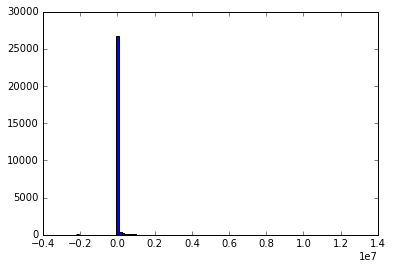

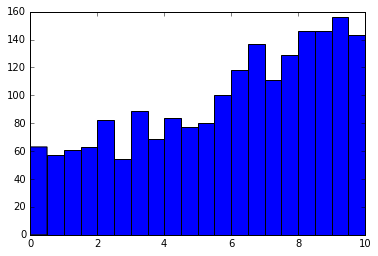

2945


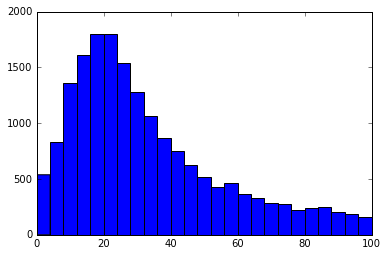

18966


In [45]:
plt.hist(chi_sqrds_cand, bins=100)
plt.show()


a = np.array(chi_sqrds_cand)
b = a[a < 10]
plt.hist(b, bins=20, range=(0,10))
plt.show()
print(len(b))



a = np.array(chi_sqrds_cand)
b = a[a < 100]
plt.hist(b, bins=25, range=(0,100))
plt.show()
print(len(b))

In [46]:
final_c[1]

mjd,classification,zpsys,flux,ra,flux_error,dec,zp,bandpass,magnitude,magnitude_error
float64,float64,str2,float64,float64,float64,float64,float64,str5,float64,float64
53083.0,6.0,ab,39.4744338989,3.7531737568,0.704656898975,0.924393040475,30.0,sdssr,26.0092102237,0.01938144342
53083.0,6.0,ab,149.228302002,3.75317387566,2.44017076492,0.924392945709,30.0,sdssz,24.5653720065,0.0177538825392
53081.0,6.0,ab,38.7743034363,3.75317368372,0.710873067379,0.924392947741,30.0,sdssr,26.0286399884,0.0199054672255
53121.0,6.0,ab,41.4338188171,3.75317361019,0.906134963036,0.924393105503,30.0,sdssr,25.9566125935,0.0237444571573
53109.0,6.0,ab,50.9398612976,3.75317394834,0.814585506916,0.924392938596,30.0,sdssr,25.7323556047,0.0173621394759
53134.0,6.0,ab,29.825252533,3.75317361432,0.896161317825,0.924393045939,30.0,sdssr,26.3135396761,0.0326231869115
53134.0,6.0,ab,204.193710327,3.75317380892,2.25895833969,0.924392982593,30.0,sdssz,24.2248940985,0.0120113046113
53146.0,6.0,ab,40.9744491577,3.75317363167,0.895824790001,0.924393023141,30.0,sdssr,25.9687171905,0.0237374614575
53151.0,6.0,ab,55.5678825378,3.75317392492,0.994415044785,0.924392898341,30.0,sdssr,25.6379403802,0.0194297923075


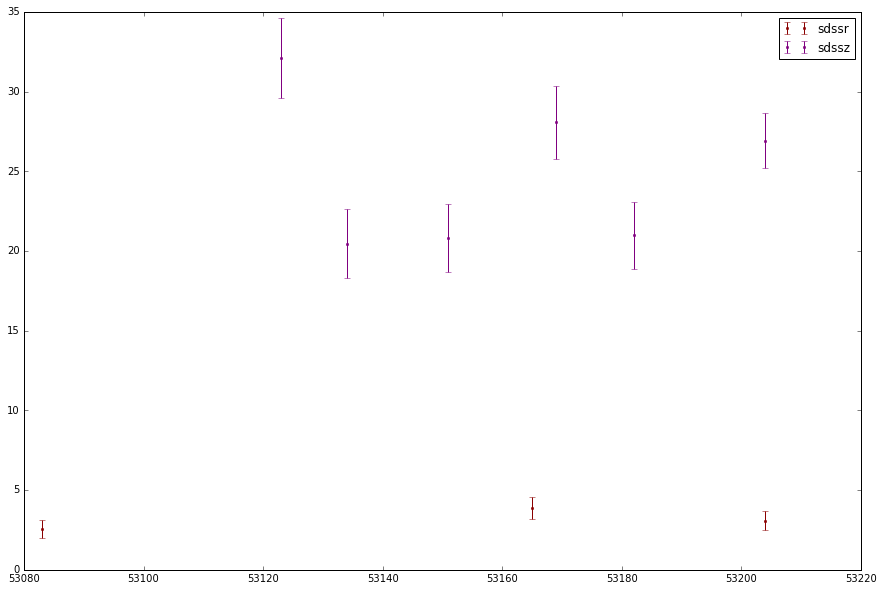

In [47]:
show_multi_filter_light_curve(final_c[0], snls_colors)

In [71]:
len(snls_array)

25

In [72]:
matches_sc = match_with_lc(snls_array, final_c)

20634
5558
20605
21266
25220
16184
21832
9841
11299
19946
3580
3933
8013
11230
5651
14764
19314
2263
25510
1230
10611
15215
77
9430
20696
1017
7776
14901
27498
8976
18821
21109
22031
33


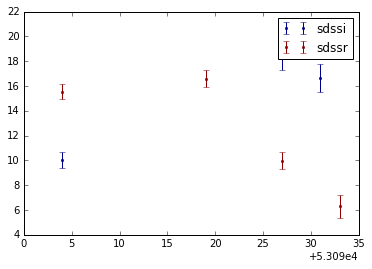

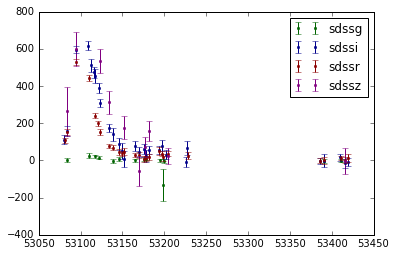

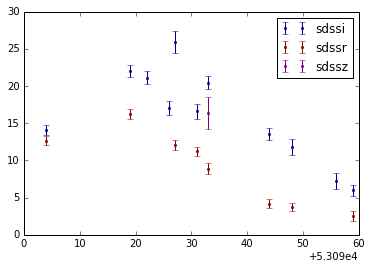

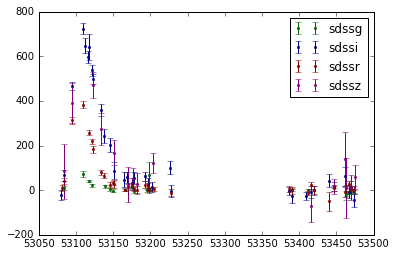

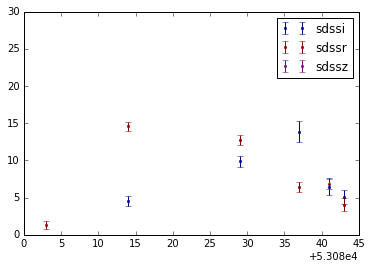

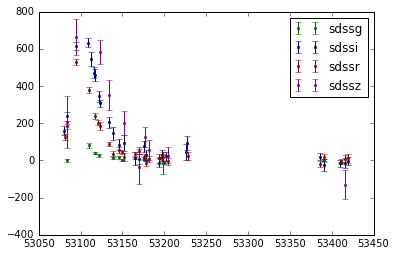

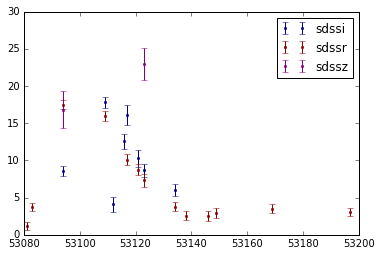

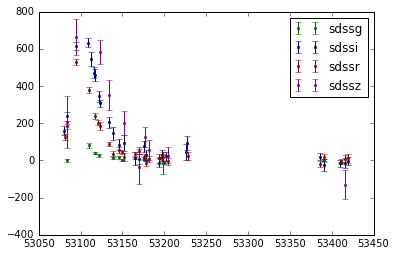

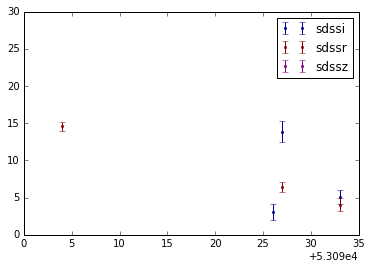

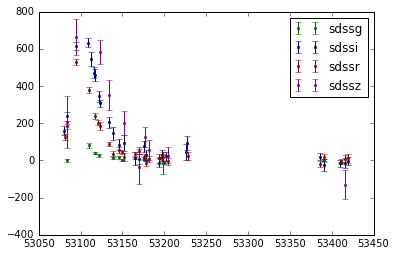

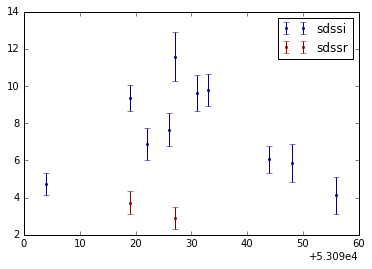

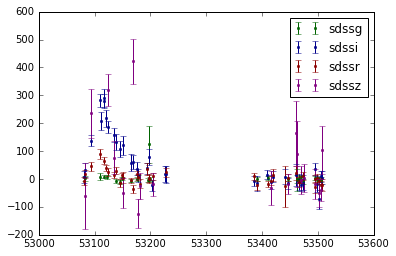

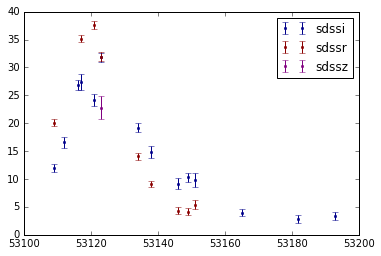

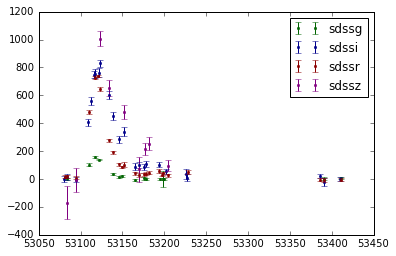

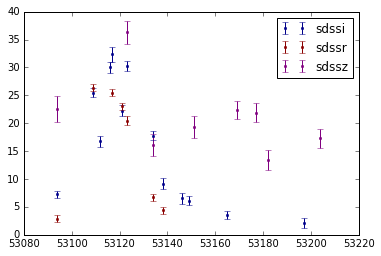

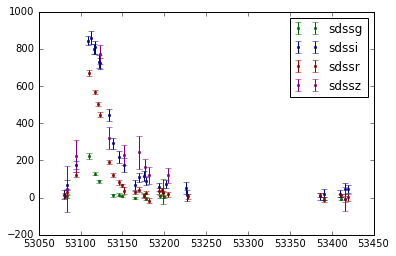

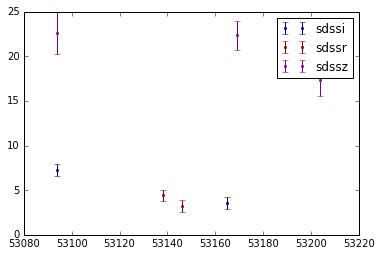

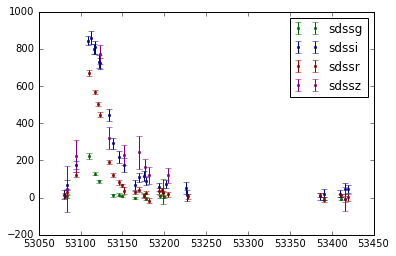

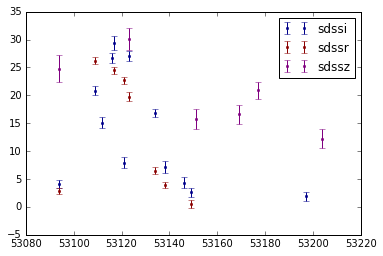

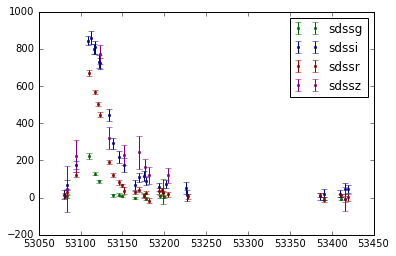

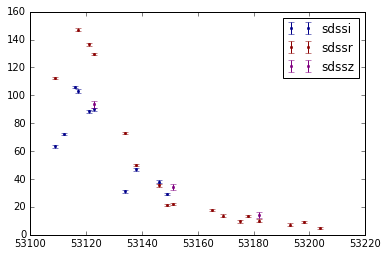

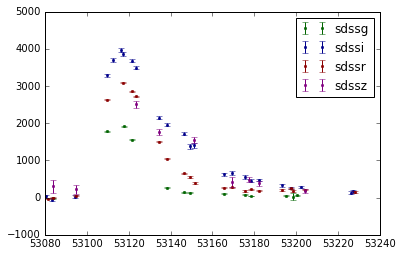

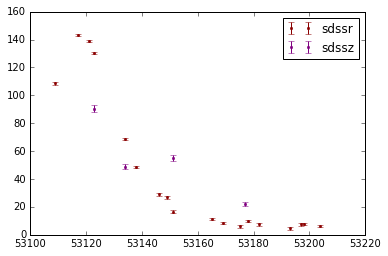

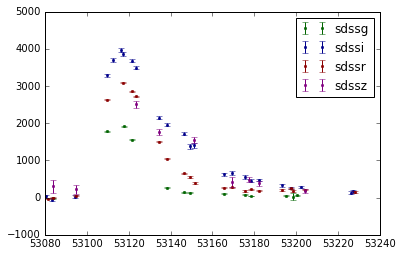

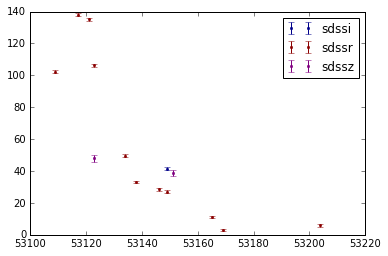

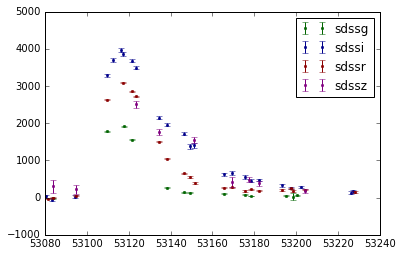

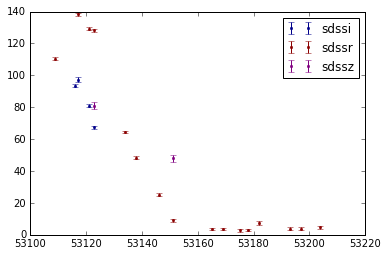

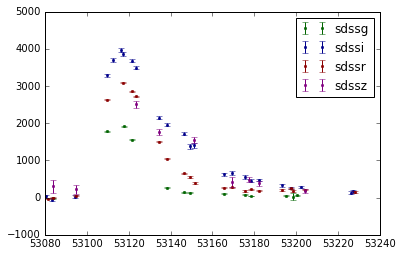

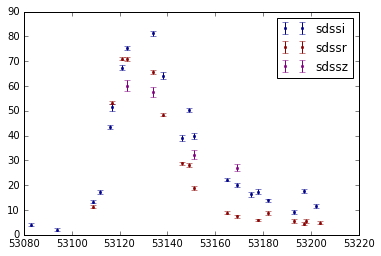

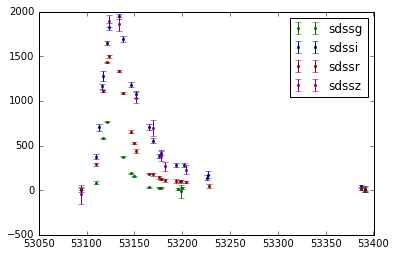

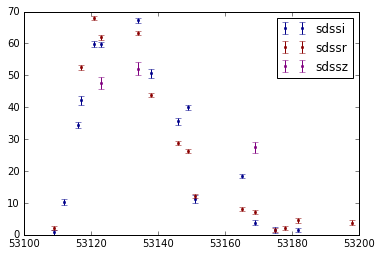

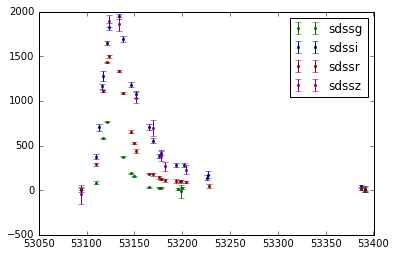

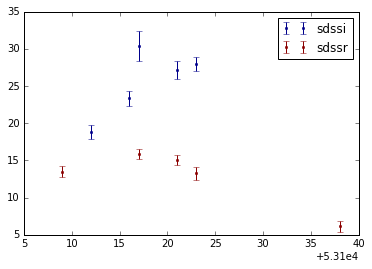

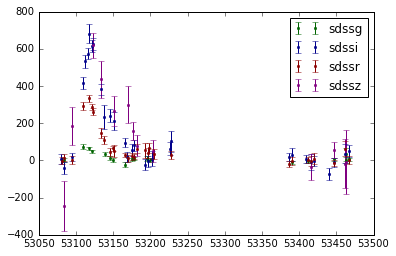

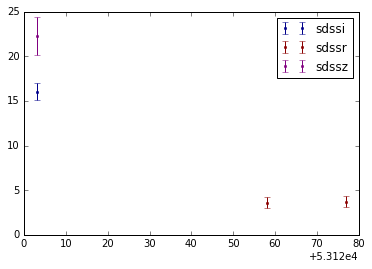

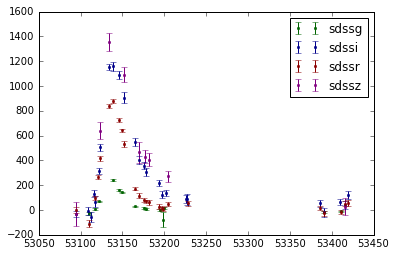

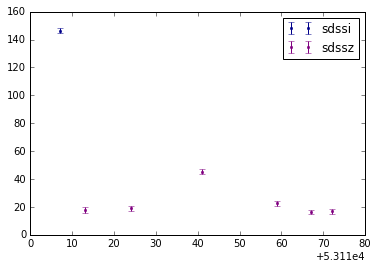

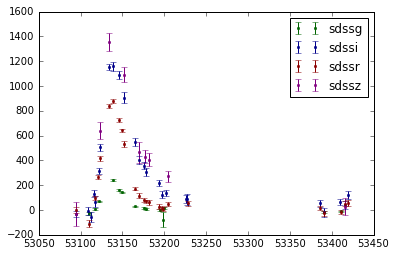

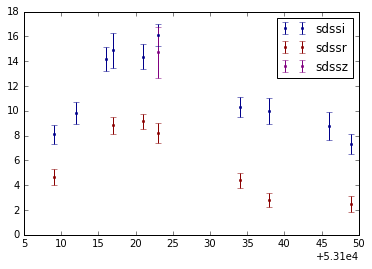

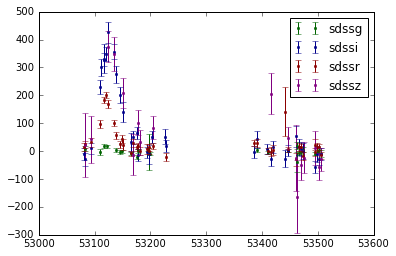

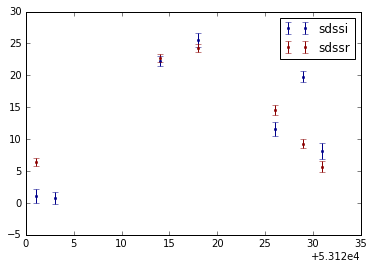

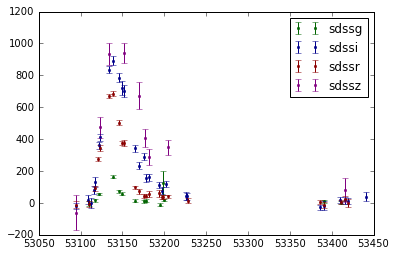

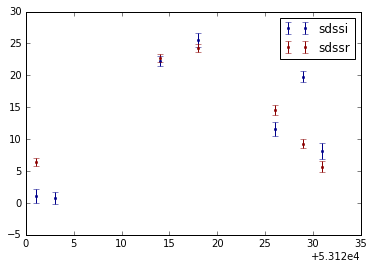

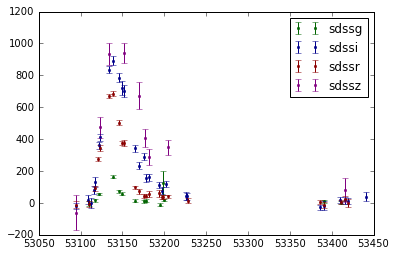

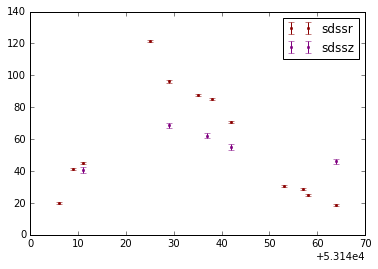

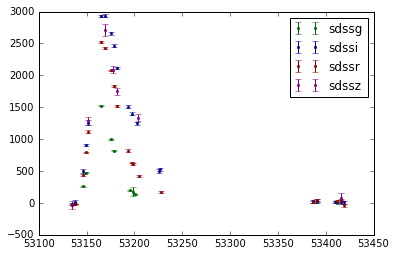

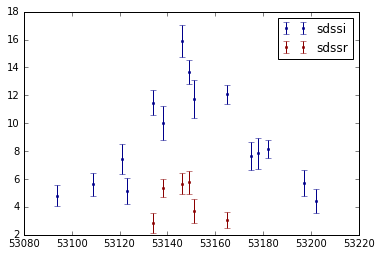

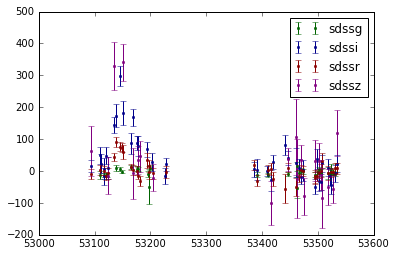

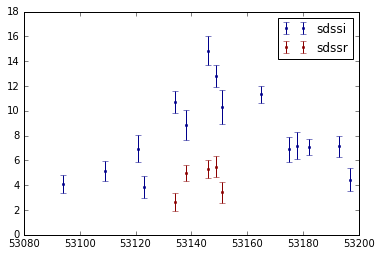

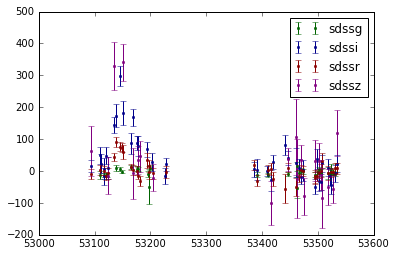

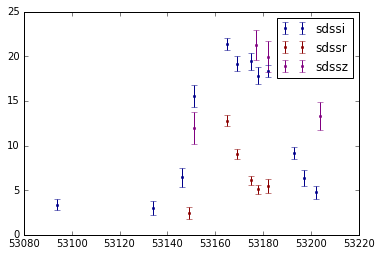

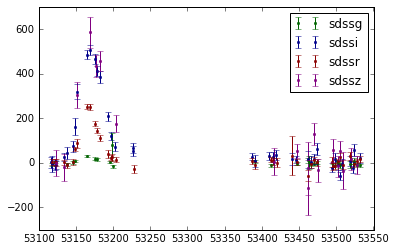

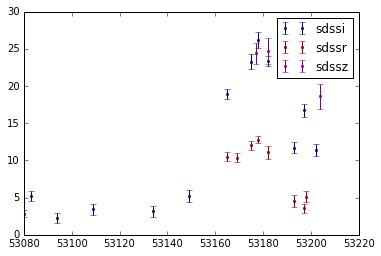

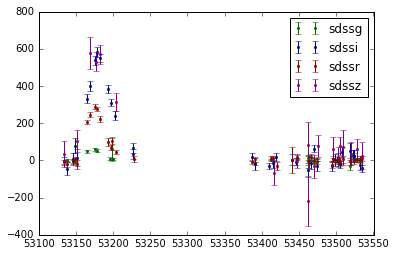

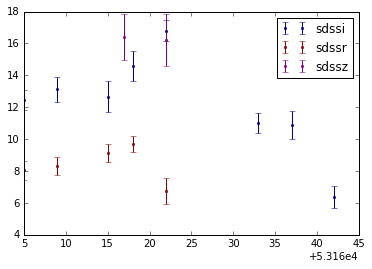

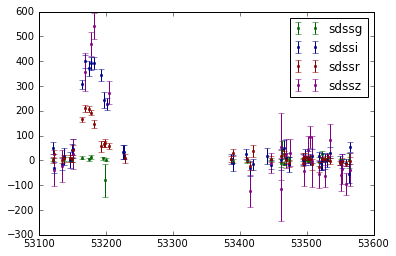

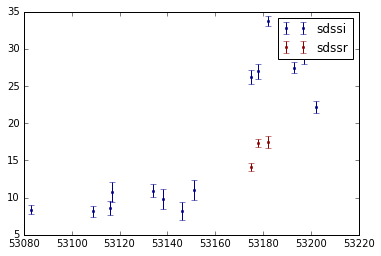

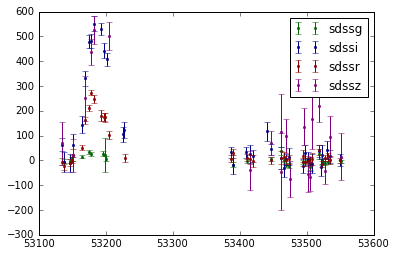

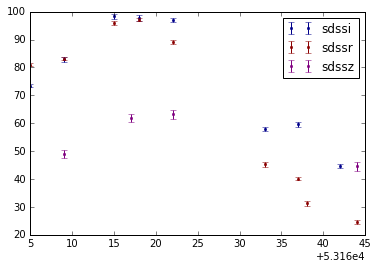

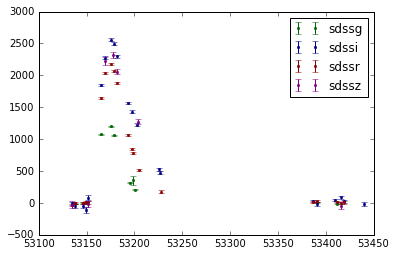

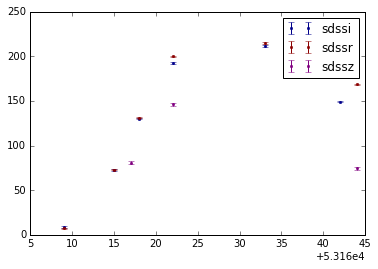

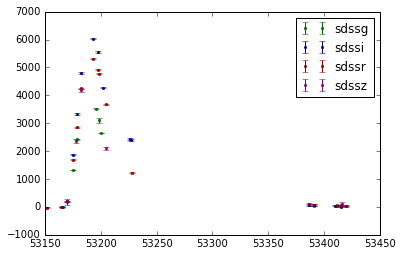

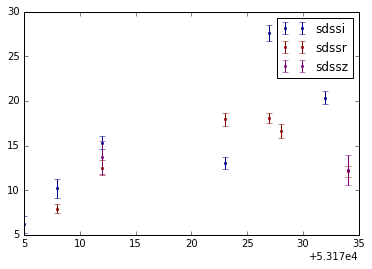

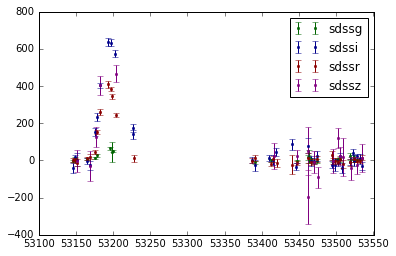

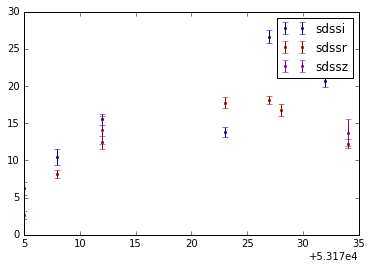

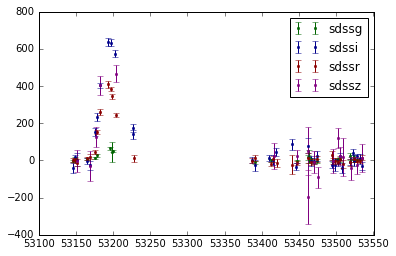

In [74]:
for match in matches_sc:
    show_multi_filter_light_curve(match[1], snls_colors)
    plt.show()
    show_multi_filter_light_curve(match[0], snls_colors)
    plt.show()
    print("=============")

In [63]:
test = np.random.choice(final_c, 20)

27881

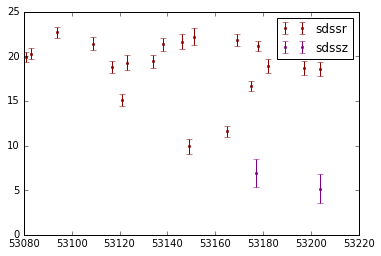

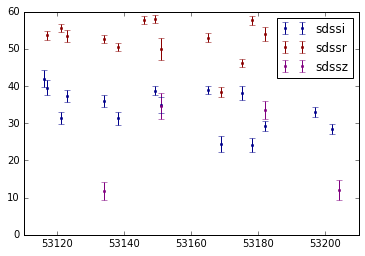

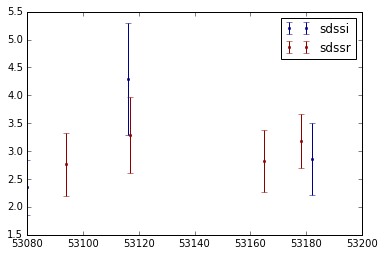

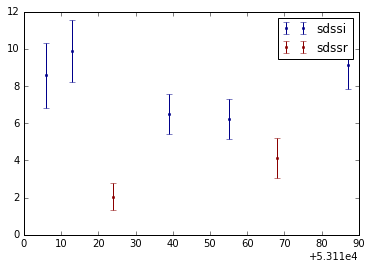

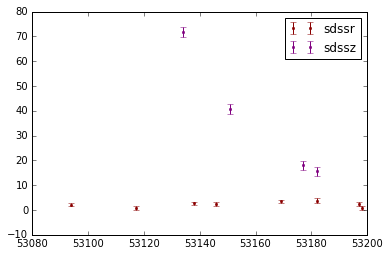

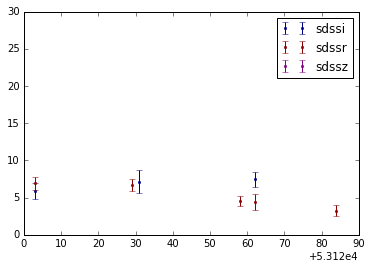

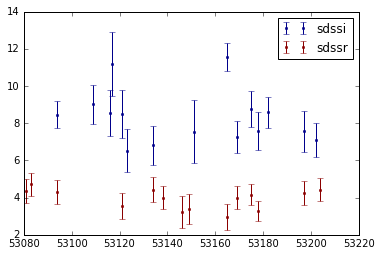

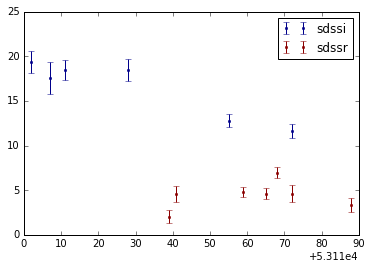

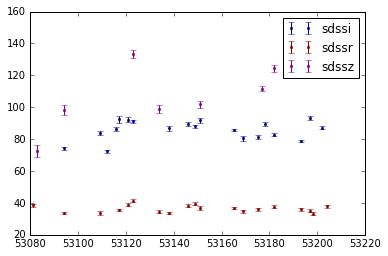

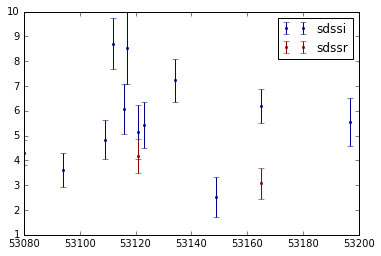

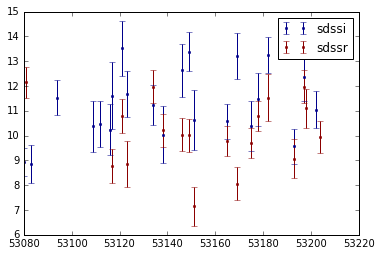

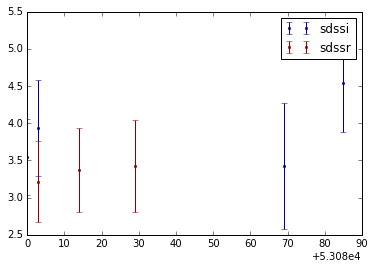

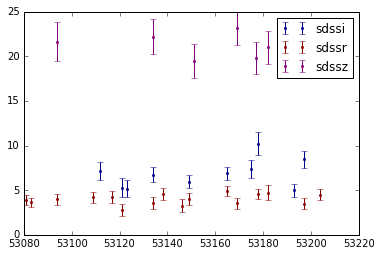

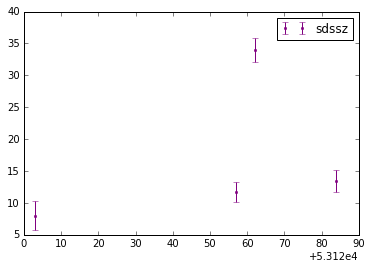

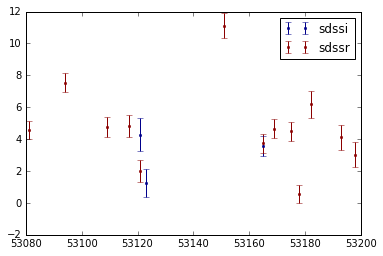

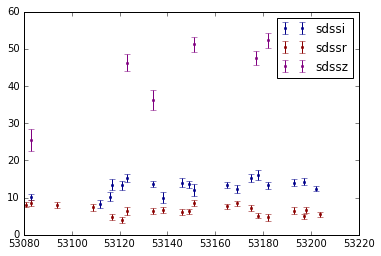

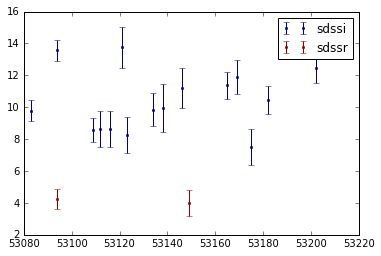

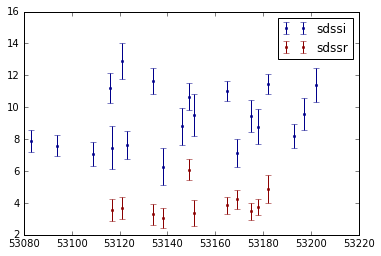

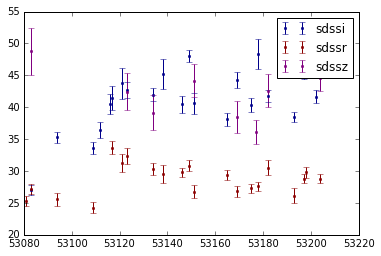

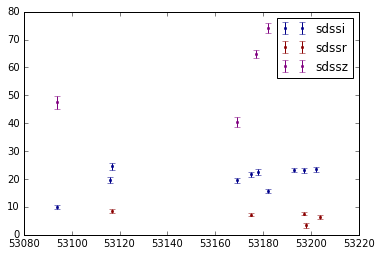

In [65]:
for t in test:
    show_multi_filter_light_curve(t, snls_colors)
    plt.show()